In [1]:
pwd

'/mnt/md0/isshamie/Projects/Mito_Trace/src/vireo'

In [2]:
# INDIR="/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat"
# COUNT_INDIR="/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor0"
# OUTDIR= "/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/results/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/clones_dendro"
# #N_DONORS=4
# DONOR=0
# var_type="init"
#INDIR=""
#sample_names="Control,Flt3l" #"Control,Flt3l,Input"

# INDIR = "/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/nclones20"
# OUTDIR = "/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/results/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/nclones20/clones_dendro"
# DONOR = 3
# COUNT_INDIR = "/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/donor3/mgatk"
# var_type = "mgatkdonor"

INDIR = "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/concat/"
COUNT_INDIR = "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor0/"
OUTDIR = "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/concat/clones_barcodes/donor0"
DONOR = 0
var_type = "init"

In [3]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import mplh.fig_utils as fu

import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

0.5.6


# Clonal reconstruction with mitochondrial mutations results

## Load cluster results and plot dendrograms

In [4]:
import seaborn as sns
from mplh import cluster_help as ch

In [5]:
out_f = join(OUTDIR, f"donor{DONOR}")

if var_type == "init":
    curr_af_f = join(COUNT_INDIR, "af.tsv")
    curr_dp_f = join(COUNT_INDIR, "dp.tsv")
    AF_df = pd.read_csv(curr_af_f, sep="\t", index_col=0).transpose()
    DP_df = pd.read_csv(curr_dp_f, sep="\t", index_col=0).transpose()
elif var_type=="simple":
    curr_ad_f = join(COUNT_INDIR, f"donor{DONOR}.AD.mtx")
    curr_dp_f = join(COUNT_INDIR, f"donor{DONOR}.DP.mtx")
    from src.utils.data_io import wrap_load_mtx_df
    AF_df, DP_df = wrap_load_mtx_df(COUNT_INDIR, prefix=f"donor{DONOR}", 
                                    vcf_prefix=f"donor{DONOR}", inc_af=True, cell_names=True, 
                                    cells_meta= f"cell_labels.donor{DONOR}.txt", cells_meta_sep=',')
elif var_type=="mgatkdonor":
    curr_af_f = join(COUNT_INDIR, f"d{DONOR}.af.tsv")
    curr_dp_f = join(COUNT_INDIR, f"d{DONOR}.coverage.tsv")
    AF_df = pd.read_csv(curr_af_f, sep="\t")
    DP_df = pd.read_csv(curr_dp_f, sep="\t")

DP_df.index.name = "Variant"
DP_df.columns.name = "Cell"
AF_df.index.name = "Variant"
AF_df.columns.name = "Cell"

In [6]:
print(AF_df.shape)
AF_df.head()

(68, 9023)


Cell     AAACGAAAGAATCAAC-1_Control  AAACGAAAGCGAGAAA-1_Control  \
Variant                                                           
10397G                     1.000000                         1.0   
10463C                     0.000000                         0.0   
10559G                     0.000000                         0.0   
10589A                     0.882353                         1.0   
11251G                     0.153846                         0.0   

Cell     AAACGAAAGTACAGAT-1_Control  AAACGAAAGTTAGCAA-1_Control  \
Variant                                                           
10397G                          0.0                         0.8   
10463C                          0.0                         0.0   
10559G                          0.0                         0.0   
10589A                          1.0                         1.0   
11251G                          0.0                         0.0   

Cell     AAACGAACACTCGCAG-1_Control  AAACGAATCAGGCGCT-1_Control  \
Variant                                                           
10397G                          1.0                         1.0   
10463C                          0.0                         0.0   
10559G                          0.0                         0.0   
10589A                          1.0                         1.0   
11251G                          0.0                         0.0   

Cell     AAACGAATCCATCGAA-1_Control  AAACGAATCTCGTAGA-1_Control  \
Variant                                                           
10397G                          1.0                         1.0   
10463C                          0.0                         0.0   
10559G                          0.0                         0.0   
10589A                          1.0                         1.0   
11251G                          0.0                         0.0   

Cell     AAACTCGAGTGAAGGA-1_Control  AAACTCGCATGCACTA-1_Control  ...  \
Variant                                                          ...   
10397G                     1.000000                         1.0  ...   
10463C                     0.000000                         0.0  ...   
10559G                     0.000000                         0.0  ...   
10589A                     1.000000                         1.0  ...   
11251G                     0.076923                         0.0  ...   

Cell     TTTGGTTTCTGATCCC-1_Input  TTTGTGTAGTTCGTTG-1_Input  \
Variant                                                       
10397G                   0.979798                  1.000000   
10463C                   0.000000                  0.000000   
10559G                   0.000000                  0.000000   
10589A                   1.000000                  0.984848   
11251G                   0.000000                  0.036145   

Cell     TTTGTGTCACACATTG-1_Input  TTTGTGTGTAAGCCGA-1_Input  \
Variant                                                       
10397G                        1.0                  1.000000   
10463C                        0.0                  0.000000   
10559G                        0.0                  0.062500   
10589A                        1.0                  0.970588   
11251G                        0.0                  0.000000   

Cell     TTTGTGTGTAGATTAG-1_Input  TTTGTGTGTAGGGTCA-1_Input  \
Variant                                                       
10397G                   1.000000                  1.000000   
10463C                   0.000000                  0.000000   
10559G                   0.000000                  0.000000   
10589A                   0.736842                  0.966102   
11251G                   0.000000                  0.000000   

Cell     TTTGTGTGTTTCTTAC-1_Input  TTTGTGTTCCTGAAAC-1_Input  \
Variant                                                       
10397G                        1.0                  0.978495   
10463C                        0.0                  0.000000   
10559G                        0.0    

In [7]:
print(DP_df.shape)
DP_df.head()

(68, 9023)


Cell     AAACGAAAGAATCAAC-1_Control  AAACGAAAGCGAGAAA-1_Control  \
Variant                                                           
10397G                          2.0                        16.0   
10463C                         11.0                        16.0   
10559G                         15.0                        26.0   
10589A                         17.0                        21.0   
11251G                         13.0                        25.0   

Cell     AAACGAAAGTACAGAT-1_Control  AAACGAAAGTTAGCAA-1_Control  \
Variant                                                           
10397G                          1.0                         5.0   
10463C                          3.0                         9.0   
10559G                          5.0                         5.0   
10589A                          6.0                         7.0   
11251G                          5.0                         7.0   

Cell     AAACGAACACTCGCAG-1_Control  AAACGAATCAGGCGCT-1_Control  \
Variant                                                           
10397G                         14.0                        58.0   
10463C                          6.0                        48.0   
10559G                         10.0                        66.0   
10589A                          9.0                        67.0   
11251G                         12.0                        91.0   

Cell     AAACGAATCCATCGAA-1_Control  AAACGAATCTCGTAGA-1_Control  \
Variant                                                           
10397G                         39.0                        12.0   
10463C                         30.0                         3.0   
10559G                         16.0                         5.0   
10589A                         24.0                        12.0   
11251G                         37.0                        16.0   

Cell     AAACTCGAGTGAAGGA-1_Control  AAACTCGCATGCACTA-1_Control  ...  \
Variant                                                          ...   
10397G                         15.0                        59.0  ...   
10463C                          8.0                        39.0  ...   
10559G                         21.0                        59.0  ...   
10589A                         18.0                        48.0  ...   
11251G                         26.0                        75.0  ...   

Cell     TTTGGTTTCTGATCCC-1_Input  TTTGTGTAGTTCGTTG-1_Input  \
Variant                                                       
10397G                       99.0                      92.0   
10463C                       78.0                      99.0   
10559G                       86.0                      80.0   
10589A                       88.0                      66.0   
11251G                       78.0                      83.0   

Cell     TTTGTGTCACACATTG-1_Input  TTTGTGTGTAAGCCGA-1_Input  \
Variant                                                       
10397G                      116.0                      39.0   
10463C                      156.0                      22.0   
10559G                      138.0                      32.0   
10589A                      135.0                      34.0   
11251G                      133.0                      45.0   

Cell     TTTGTGTGTAGATTAG-1_Input  TTTGTGTGTAGGGTCA-1_Input  \
Variant                                                       
10397G                       38.0                      69.0   
10463C                       14.0                      77.0   
10559G                       13.0                      60.0   
10589A                       19.0                      59.0   
11251G                       30.0                      81.0   

Cell     TTTGTGTGTTTCTTAC-1_Input  TTTGTGTTCCTGAAAC-1_Input  \
Variant                                                       
10397G                       72.0                      93.0   
10463C                       58.0                      89.0   
10559G                       48.0    

In [8]:
cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep='\t', index_col="ID")#.sort_values(["donor", "lineage"])
cells_meta["name"] = cells_meta["donor"].astype(str)+"_"+cells_meta["lineage"].astype(str)
# if "donor_index" in cells_meta.columns and "lineage_index" in cells_meta.columns:
#     cells_meta = cells_meta.sort_values(["donor_index", "lineage_index"])
#AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
curr_labels = cells_meta[cells_meta["donor"]==DONOR]
curr_labels

lineage  donor condition  name
ID                                                        
AAACGAAAGAATCAAC-1_Control        0      0   Control   0_0
AAATGAGAGAGACTCG-1_Control        0      0   Control   0_0
AACAAAGTCAAGTTGC-1_Control        0      0   Control   0_0
AACAAAGTCACATCCC-1_Control        0      0   Control   0_0
AACCAACGTTCATTTC-1_Control        0      0   Control   0_0
...                             ...    ...       ...   ...
TGATCAGAGAGCACTG-1_Input         33      0     Input  0_33
TGCACCTCAAGCAATA-1_Input         33      0     Input  0_33
TGCTATTTCGCGTTCT-1_Input         33      0     Input  0_33
TTGCTTATCCACACCT-1_Input         33      0     Input  0_33
TTGTTGTTCTTAAGCG-1_Input         33      0     Input  0_33

[9023 rows x 4 columns]

In [9]:
conditions = curr_labels["condition"].unique()
conditions

array(['Control', 'Flt3l', 'Input'], dtype=object)

In [10]:
def calc_mean(cells, af):
    #print(cells.head())
    return af.loc[:,cells.index.values].mean(axis=1)
#     if 'donor_index' in cells.columns:
#         return af.iloc[:, cells['donor_index'].values-1].mean(axis=1)
#     else:
#         return af.mean(axis=1)
def calc_median(cells, af):
    #print(cells.head())
    return af.loc[:,cells.index.values].median(axis=1)

## Get donor inds

In [11]:
donor_inds = AF_df.index[((AF_df>0.9).sum(axis=1)>(0.9*AF_df.shape[1]))]
donor_inds

Index(['10397G', '10589A', '11761T', '13188T', '1438G', '146C', '14766T',
       '15326G', '16126C', '16355T', '16362C', '196C', '204C', '2442C', '263G',
       '2706G', '3847C', '4769G', '58C', '64T', '7028T', '73G', '750G',
       '7598A', '827G', '8292A', '8461T', '8860G'],
      dtype='object', name='Variant')

In [12]:
# median_af = curr_labels.groupby(["lineage", "condition"]).apply(calc_median, af=AF_df)
# anno = median_af.reset_index()[["lineage", "condition"]]

# #median_dp = curr_labels.groupby(["lineage", "condition"]).apply(calc_median, af=nlog2(DP_df))
# median_dp = curr_labels.groupby(["lineage", "condition"]).apply(calc_median, af=np.log2(DP_df+1))
# anno_dp = median_dp.reset_index()[["lineage", "condition"]]
# median_dp = median_dp.reset_index(drop=True)

# na_cells = curr_labels.loc[curr_labels["lineage"].isnull()]
# na_median_af = na_cells.groupby("condition").apply(calc_median, af=AF_df)

# if not (na_median_af.shape[0] == 0):
#     print('na shape', na_median_af.shape)
#     na_anno = pd.concat((anno,pd.DataFrame({"lineage":["None"]*len(na_median_af.index), "condition":na_median_af.index})), 
#                         ignore_index=True)
#     na_concat = pd.concat((median_af.reset_index(drop=True), na_median_af.reset_index(drop=True)), ignore_index=True)
#     na_median_dp = na_cells.groupby("condition").apply(calc_median, af=np.log2(DP_df+1))
#     na_dp_concat = pd.concat((median_dp, na_median_dp.reset_index(drop=True)), ignore_index=True)
# else:
#     na_anno = anno
#     na_concat = median_af.reset_index(drop=True)
#     na_dp_concat = median_dp
     
  

In [13]:
AF_df.head()

Cell     AAACGAAAGAATCAAC-1_Control  AAACGAAAGCGAGAAA-1_Control  \
Variant                                                           
10397G                     1.000000                         1.0   
10463C                     0.000000                         0.0   
10559G                     0.000000                         0.0   
10589A                     0.882353                         1.0   
11251G                     0.153846                         0.0   

Cell     AAACGAAAGTACAGAT-1_Control  AAACGAAAGTTAGCAA-1_Control  \
Variant                                                           
10397G                          0.0                         0.8   
10463C                          0.0                         0.0   
10559G                          0.0                         0.0   
10589A                          1.0                         1.0   
11251G                          0.0                         0.0   

Cell     AAACGAACACTCGCAG-1_Control  AAACGAATCAGGCGCT-1_Control  \
Variant                                                           
10397G                          1.0                         1.0   
10463C                          0.0                         0.0   
10559G                          0.0                         0.0   
10589A                          1.0                         1.0   
11251G                          0.0                         0.0   

Cell     AAACGAATCCATCGAA-1_Control  AAACGAATCTCGTAGA-1_Control  \
Variant                                                           
10397G                          1.0                         1.0   
10463C                          0.0                         0.0   
10559G                          0.0                         0.0   
10589A                          1.0                         1.0   
11251G                          0.0                         0.0   

Cell     AAACTCGAGTGAAGGA-1_Control  AAACTCGCATGCACTA-1_Control  ...  \
Variant                                                          ...   
10397G                     1.000000                         1.0  ...   
10463C                     0.000000                         0.0  ...   
10559G                     0.000000                         0.0  ...   
10589A                     1.000000                         1.0  ...   
11251G                     0.076923                         0.0  ...   

Cell     TTTGGTTTCTGATCCC-1_Input  TTTGTGTAGTTCGTTG-1_Input  \
Variant                                                       
10397G                   0.979798                  1.000000   
10463C                   0.000000                  0.000000   
10559G                   0.000000                  0.000000   
10589A                   1.000000                  0.984848   
11251G                   0.000000                  0.036145   

Cell     TTTGTGTCACACATTG-1_Input  TTTGTGTGTAAGCCGA-1_Input  \
Variant                                                       
10397G                        1.0                  1.000000   
10463C                        0.0                  0.000000   
10559G                        0.0                  0.062500   
10589A                        1.0                  0.970588   
11251G                        0.0                  0.000000   

Cell     TTTGTGTGTAGATTAG-1_Input  TTTGTGTGTAGGGTCA-1_Input  \
Variant                                                       
10397G                   1.000000                  1.000000   
10463C                   0.000000                  0.000000   
10559G                   0.000000                  0.000000   
10589A                   0.736842                  0.966102   
11251G                   0.000000                  0.000000   

Cell     TTTGTGTGTTTCTTAC-1_Input  TTTGTGTTCCTGAAAC-1_Input  \
Variant                                                       
10397G                        1.0                  0.978495   
10463C                        0.0                  0.000000   
10559G                        0.0    

In [14]:
def rm_high(df, thresh, pct_thresh):
    return df.loc[~(((df>thresh).sum(axis=1)>pct_thresh*df.shape[0]))]

def rm_low(df, thresh, pct_thresh):
    return df.loc[~((df<thresh).sum(axis=1)>(pct_thresh*df.shape[1]))]

    #return df.loc[~(((df<=thresh).sum(axis=1)>pct_thresh*df.shape[0]))]
#df[(df<0.01).sum(axis=1)]

## Plot all cells in each clone

0_0
(68, 957)
clustering
cmap None


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


clustering
cmap None
0_1
(68, 624)
clustering
cmap None
clustering
cmap None
0_10
(68, 326)
clustering
cmap None
clustering
cmap None
0_11
(68, 318)
clustering
cmap None
clustering
cmap None
0_12
(68, 318)
clustering
cmap None
clustering
cmap None
0_13
(68, 266)
clustering
cmap None
clustering
cmap None
0_14
(68, 250)
clustering
cmap None
clustering
cmap None
0_15
(68, 232)
clustering
cmap None
clustering
cmap None
0_16
(68, 230)
clustering
cmap None
clustering
cmap None
0_17
(68, 214)
clustering
cmap None
clustering
cmap None
0_18
(68, 210)
clustering
cmap None


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:805: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)


clustering
cmap None
0_19
(68, 197)
clustering
cmap None
clustering
cmap None
0_2
(68, 545)
clustering
cmap None
clustering
cmap None
0_20
(68, 177)
clustering
cmap None
clustering
cmap None
0_21
(68, 163)
clustering
cmap None
clustering
cmap None
0_22
(68, 154)
clustering
cmap None
clustering
cmap None
0_23
(68, 154)
clustering
cmap None
clustering
cmap None
0_24
(68, 146)
clustering
cmap None
clustering
cmap None
0_25
(68, 130)
clustering
cmap None
clustering
cmap None
0_26
(68, 127)
clustering
cmap None
clustering
cmap None
0_27
(68, 122)
clustering
cmap None
clustering
cmap None
0_28
(68, 122)
clustering
cmap None
clustering
cmap None
0_29
(68, 114)
clustering
cmap None
clustering
cmap None
0_3
(68, 429)
clustering
cmap None
clustering
cmap None
0_30
(68, 104)
clustering
cmap None
clustering
cmap None
0_31
(68, 102)
clustering
cmap None
clustering
cmap None
0_32
(68, 100)
clustering
cmap None
clustering
cmap None
0_33
(68, 71)
clustering
cmap None
clustering
cmap None
0_4
(68, 364)

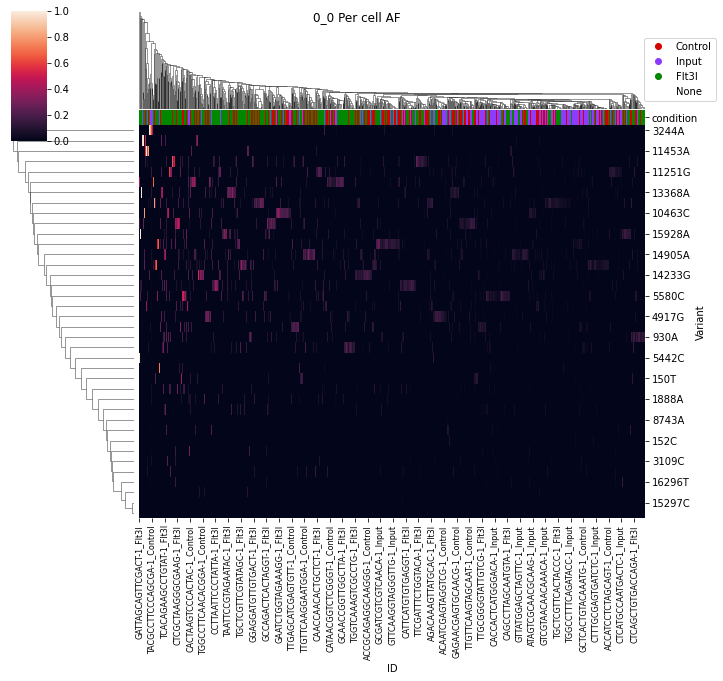

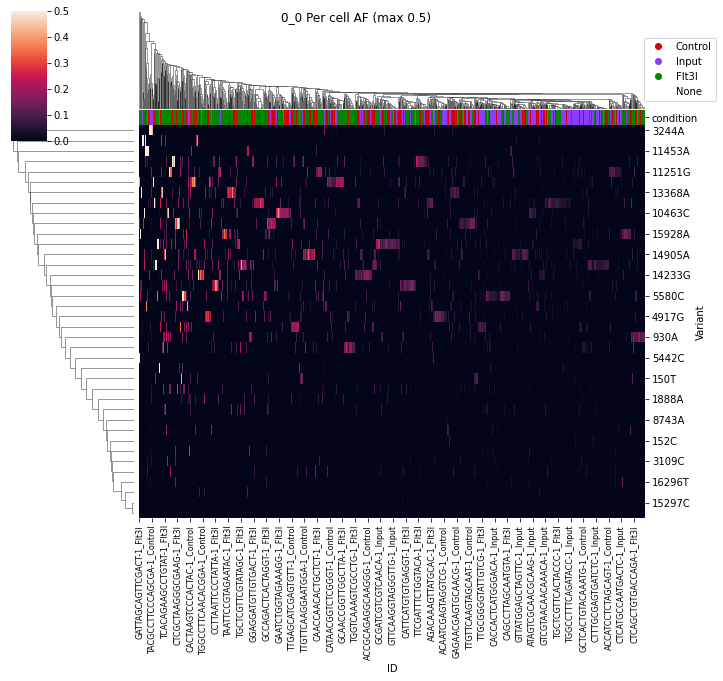

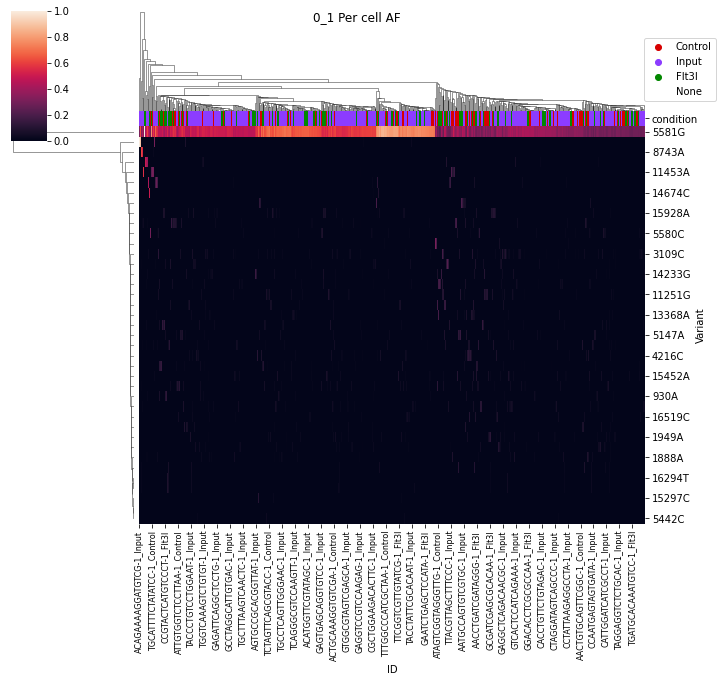

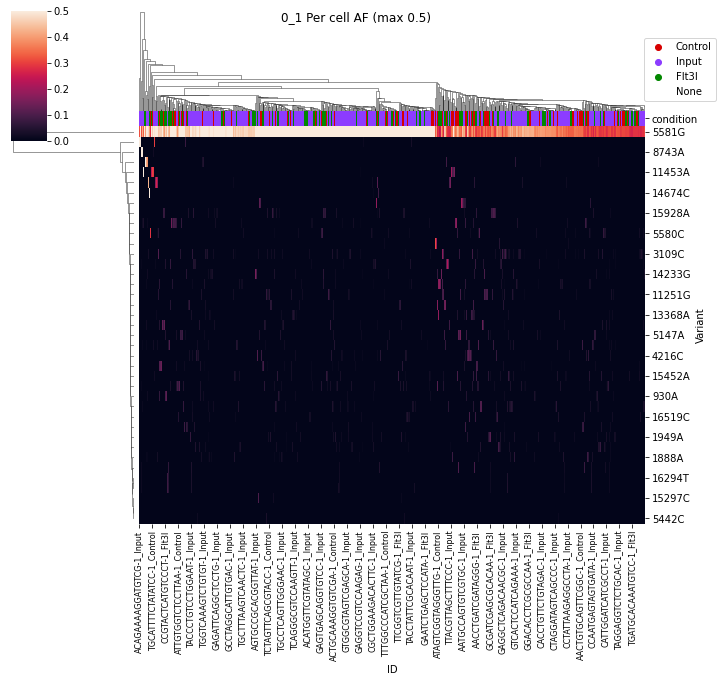

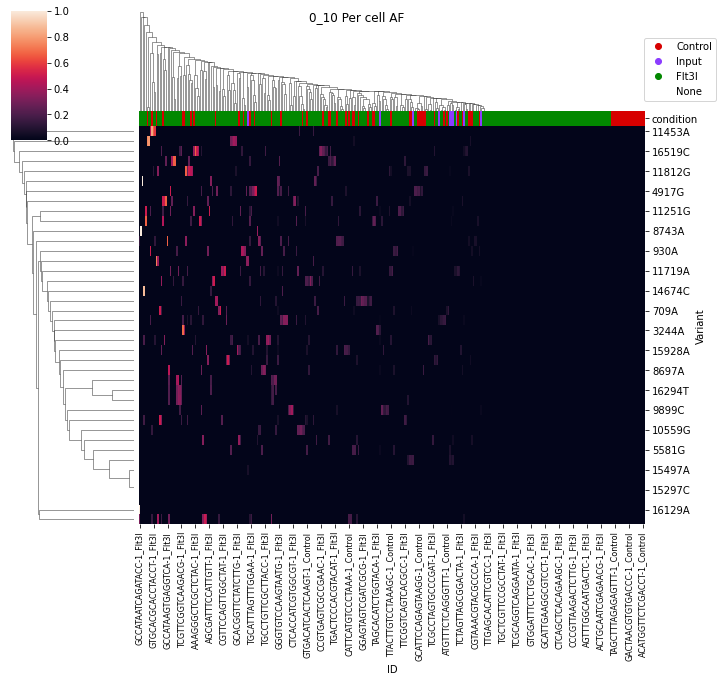

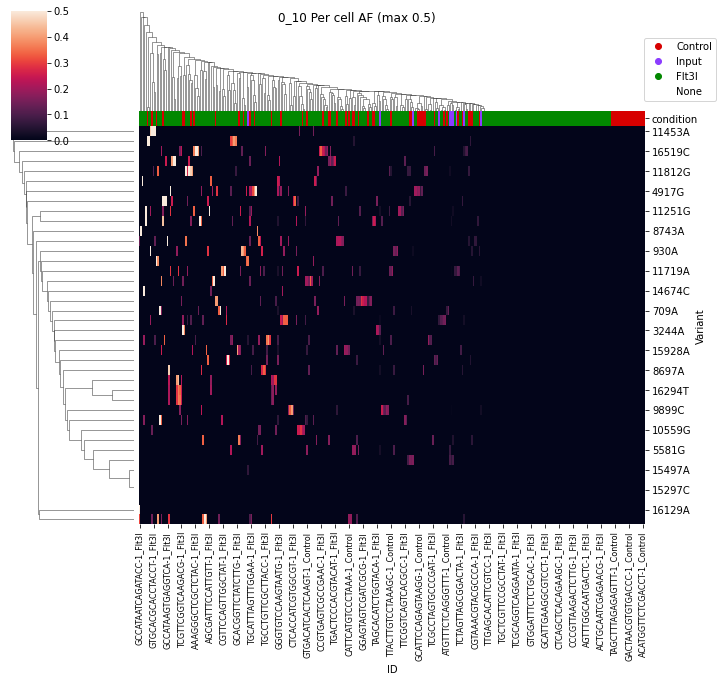

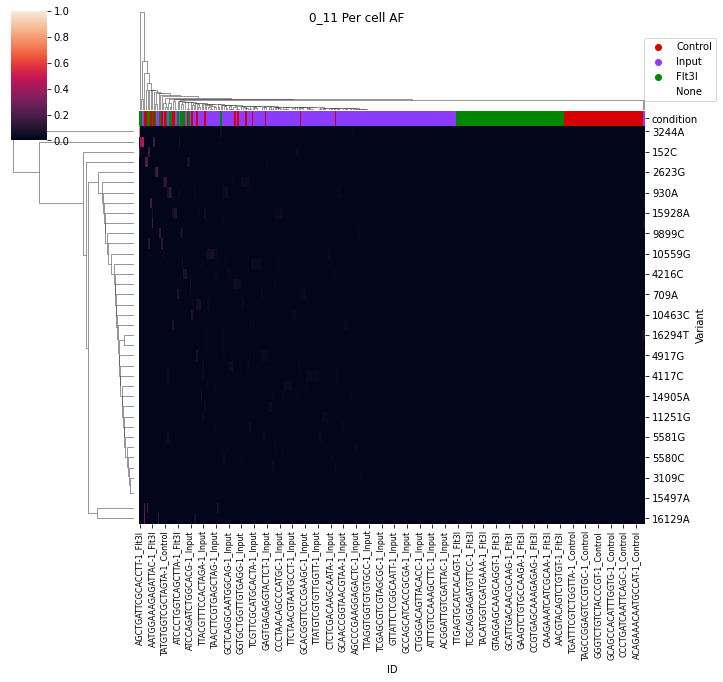

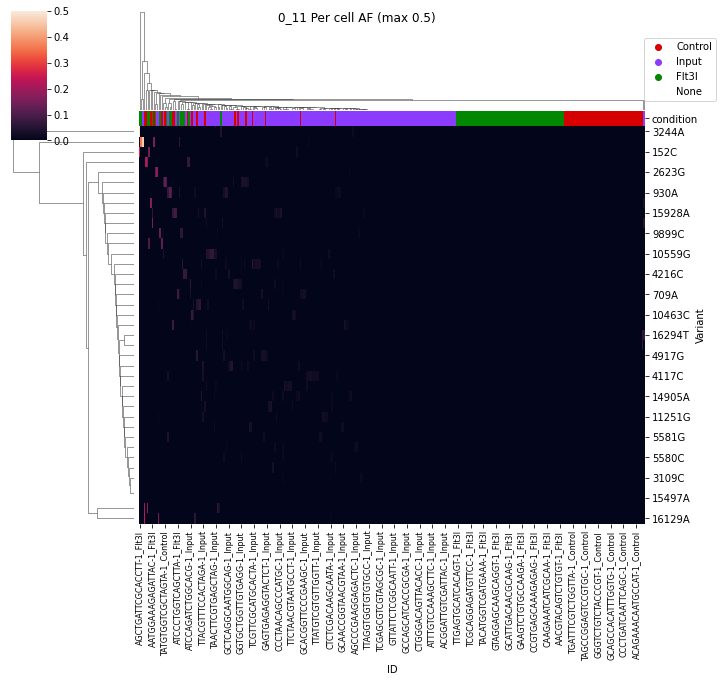

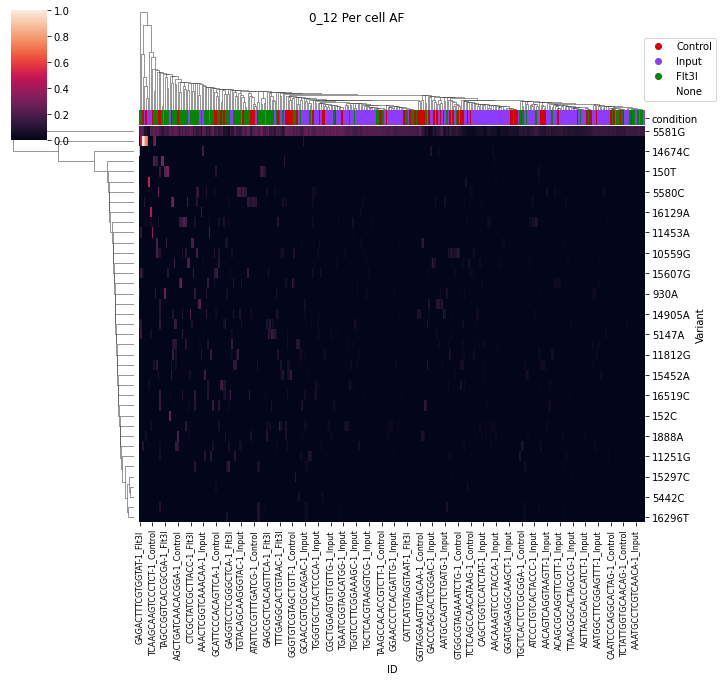

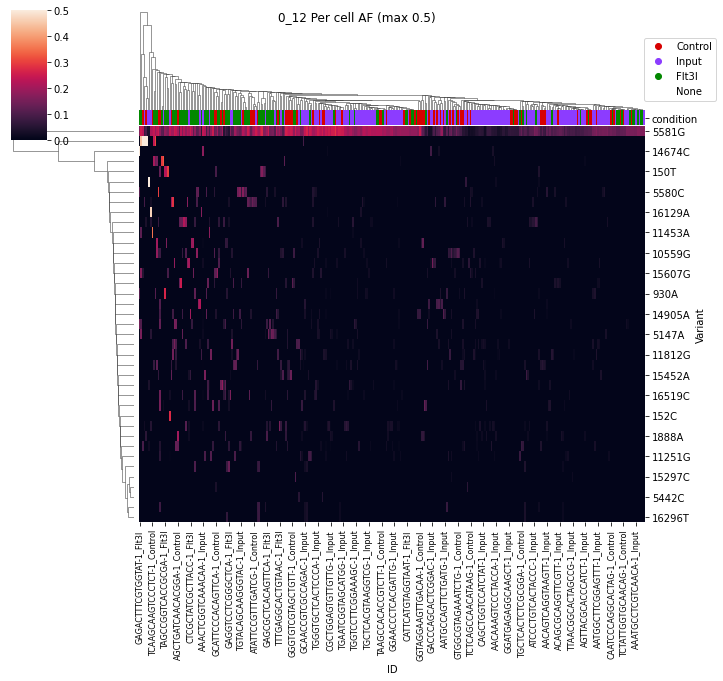

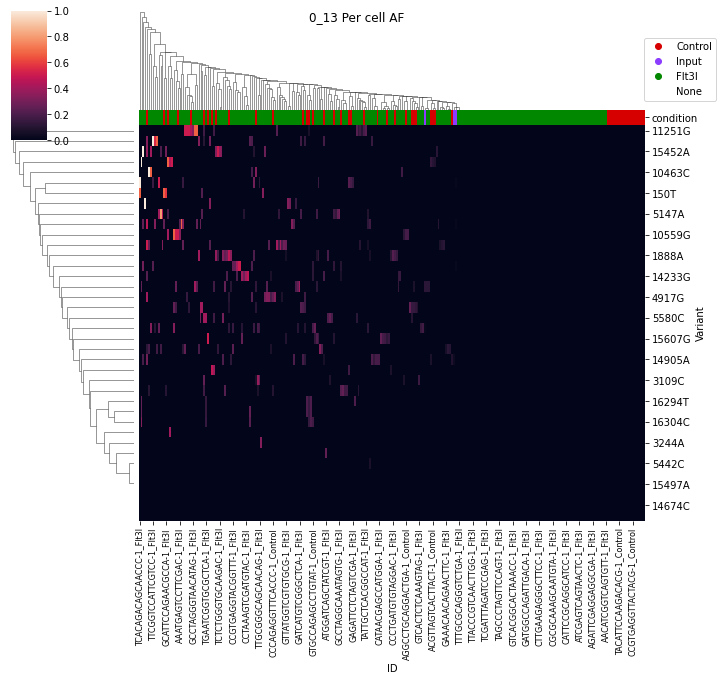

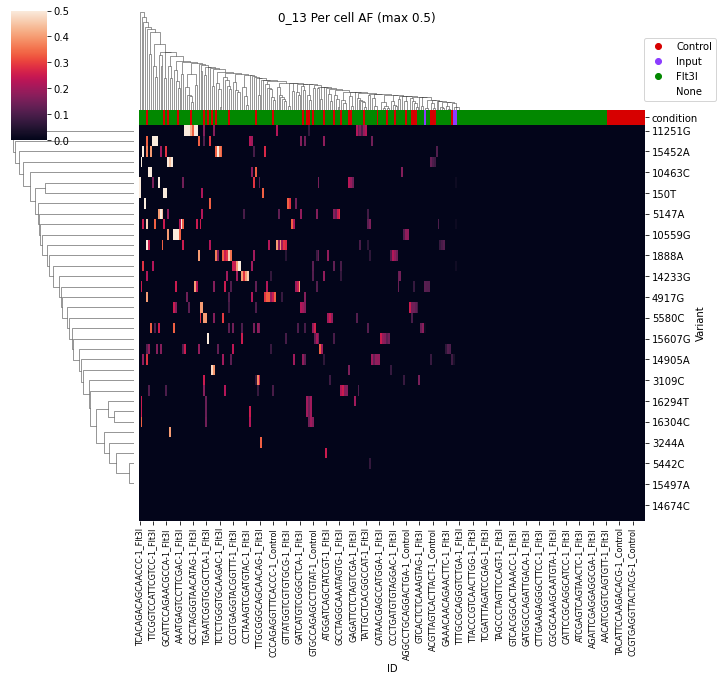

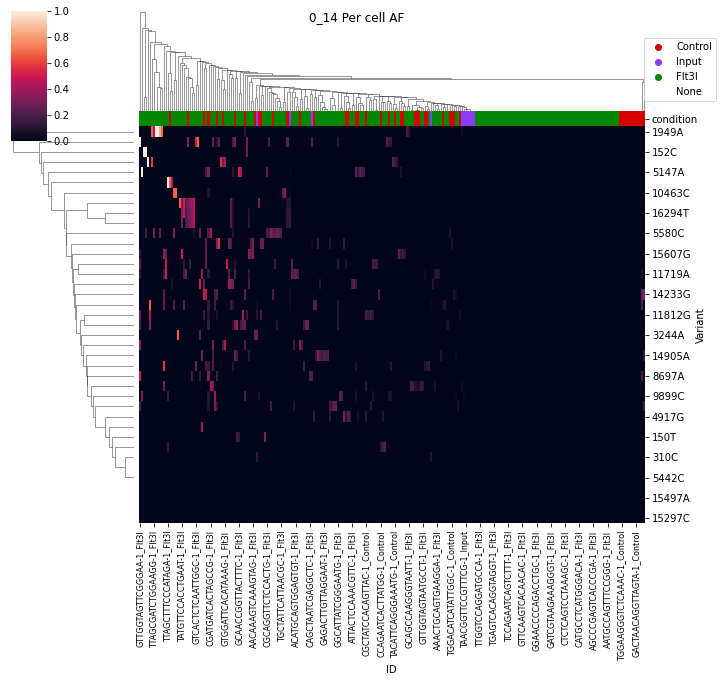

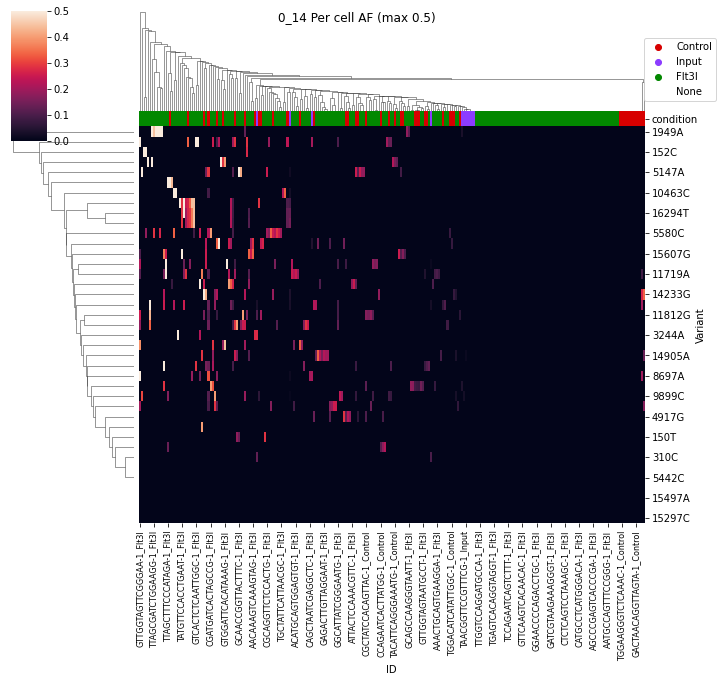

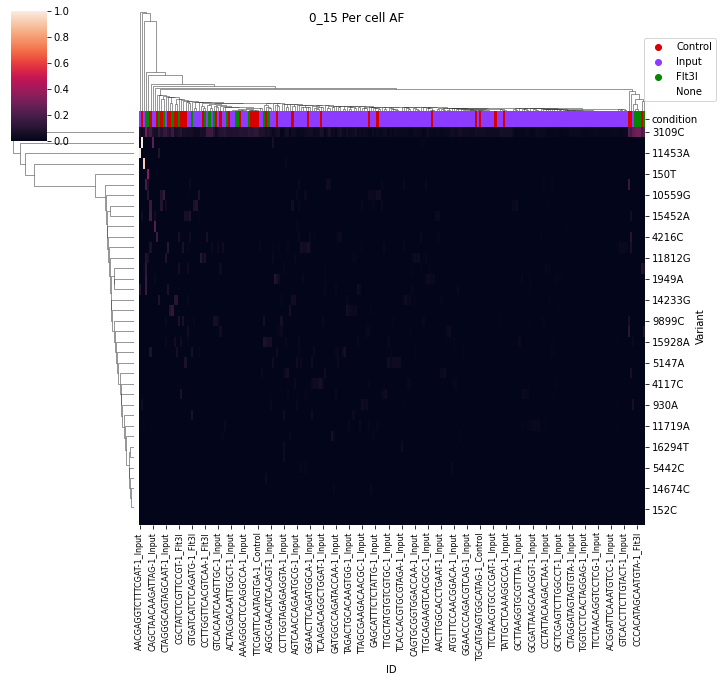

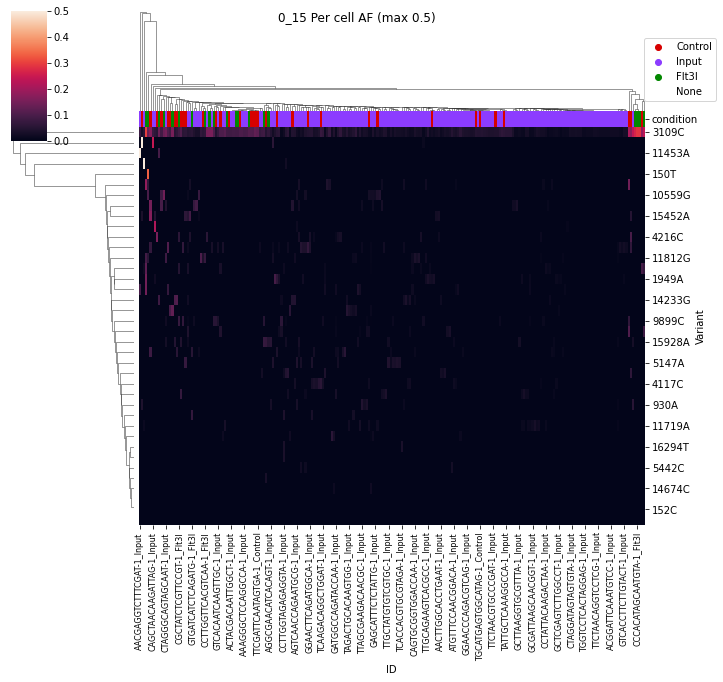

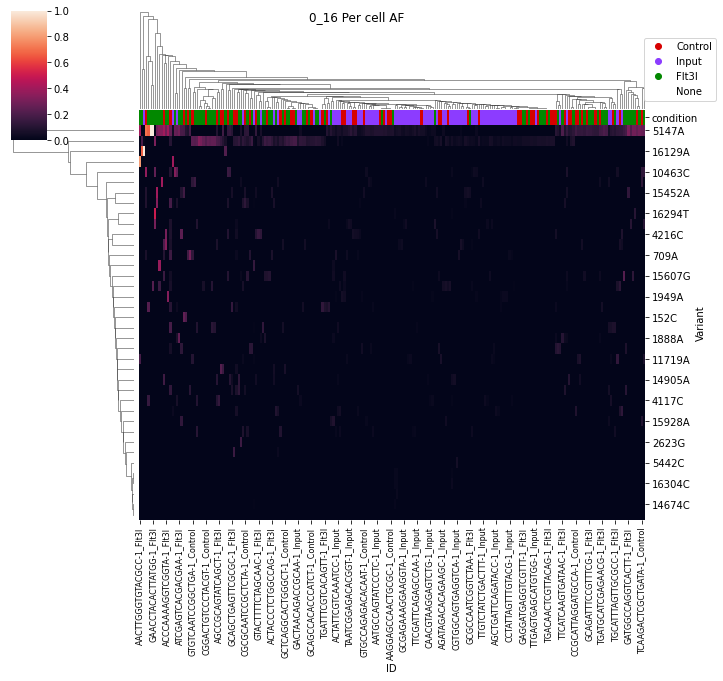

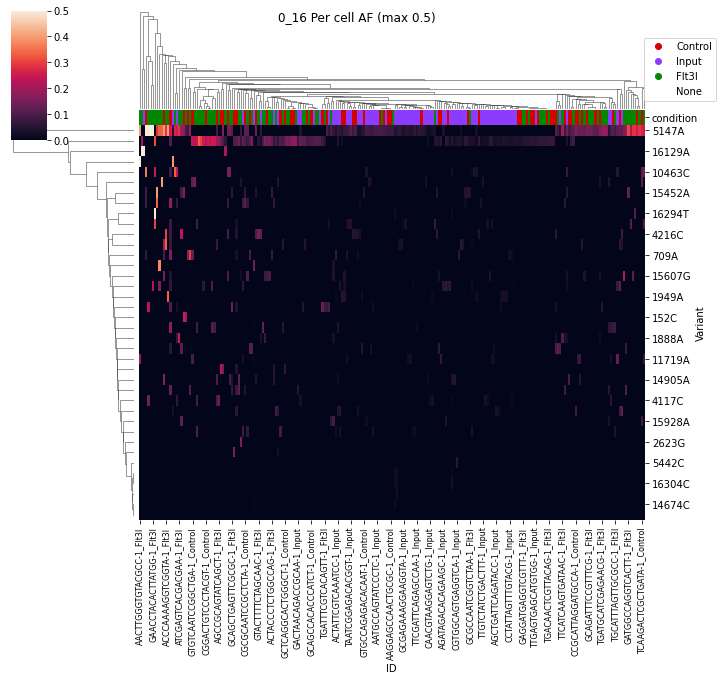

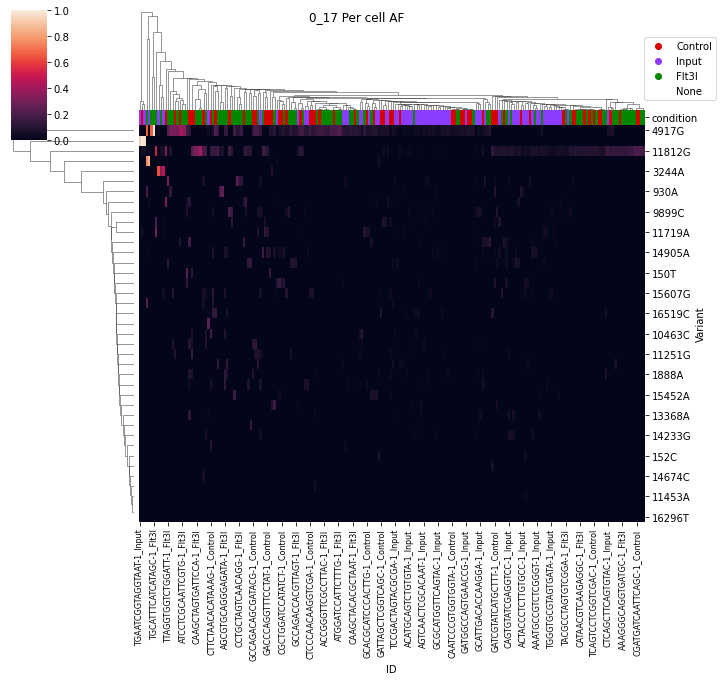

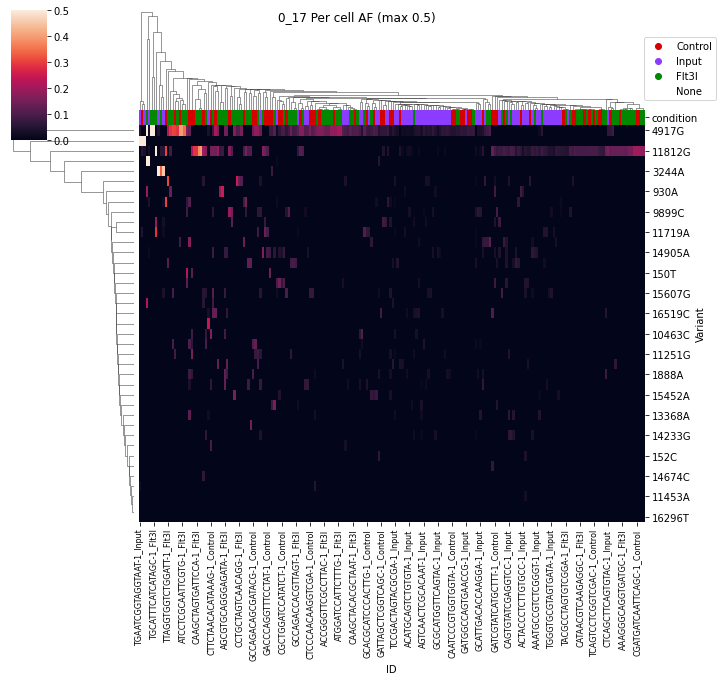

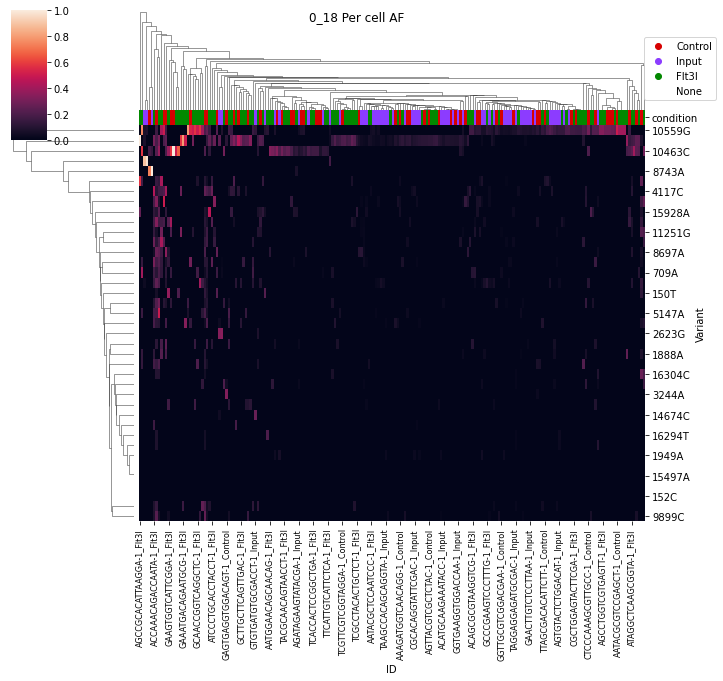

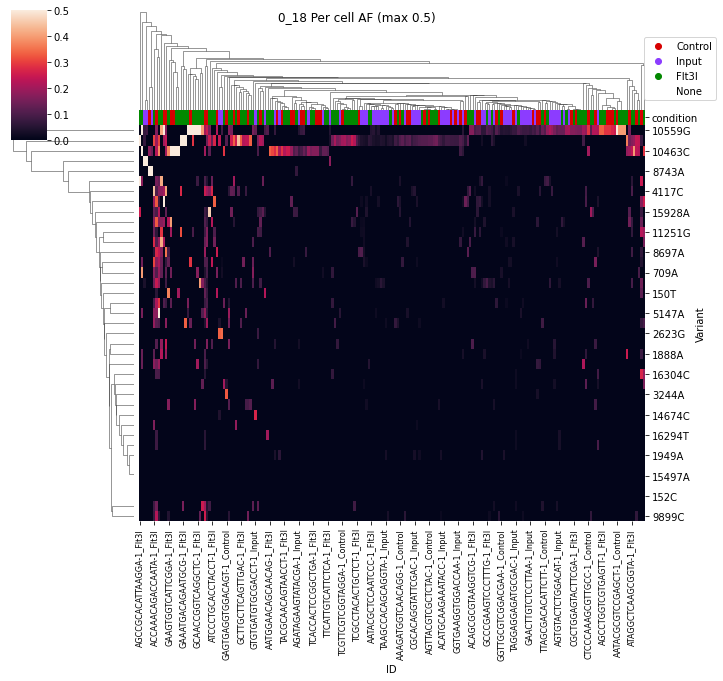

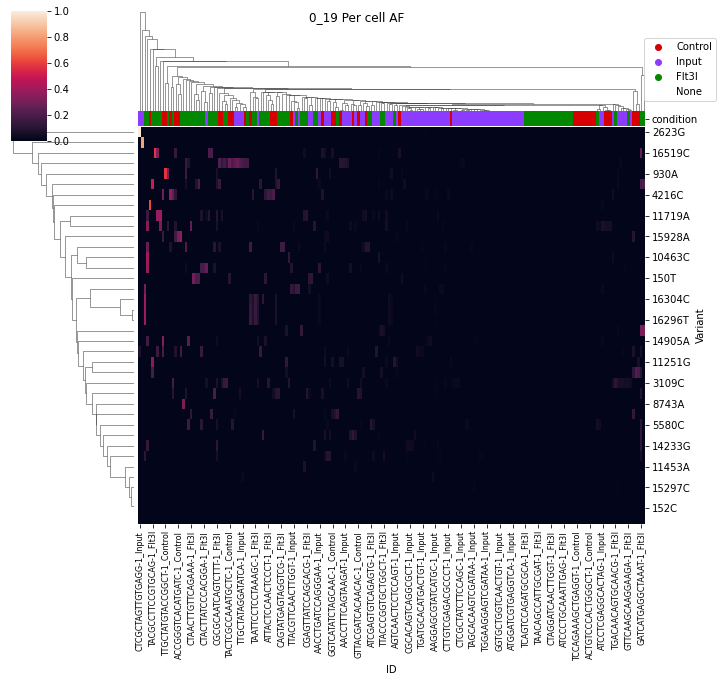

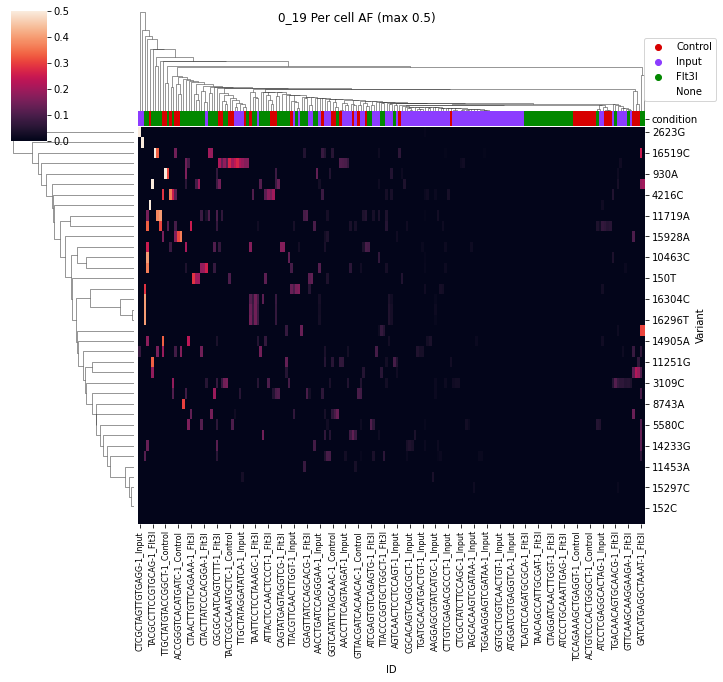

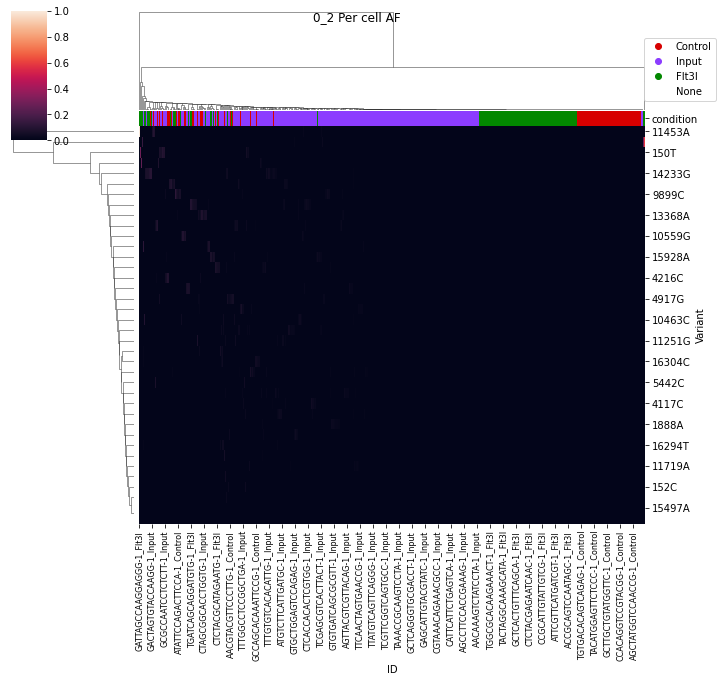

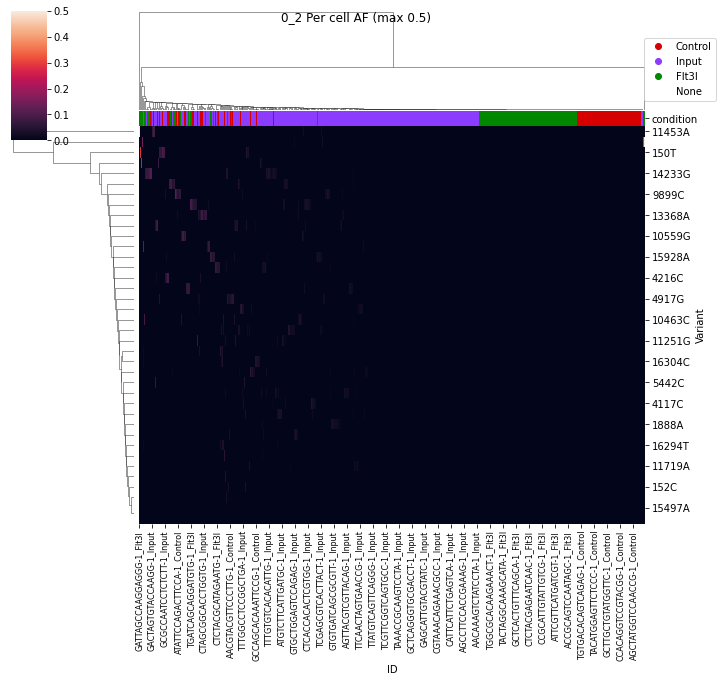

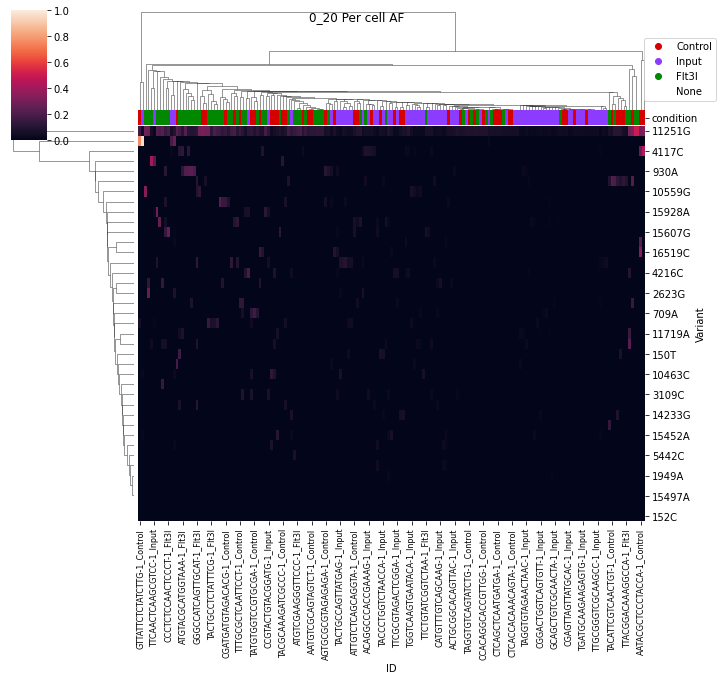

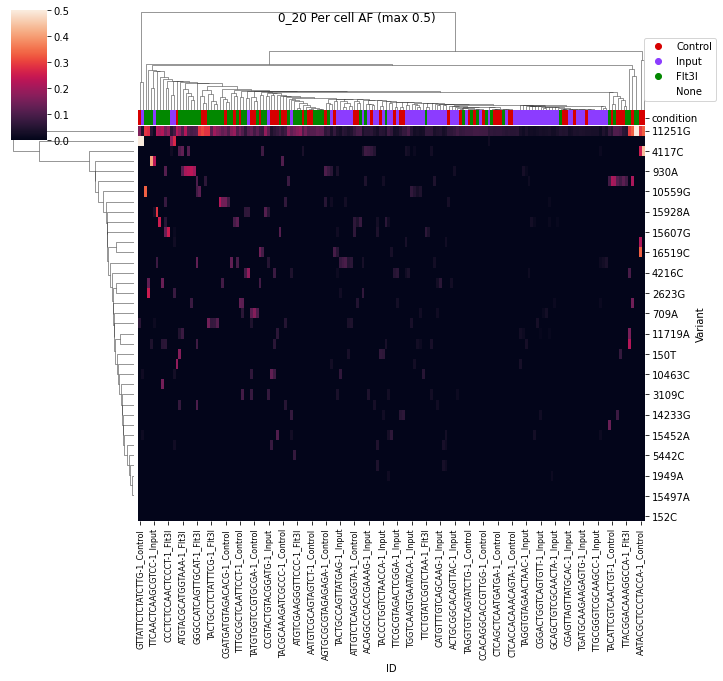

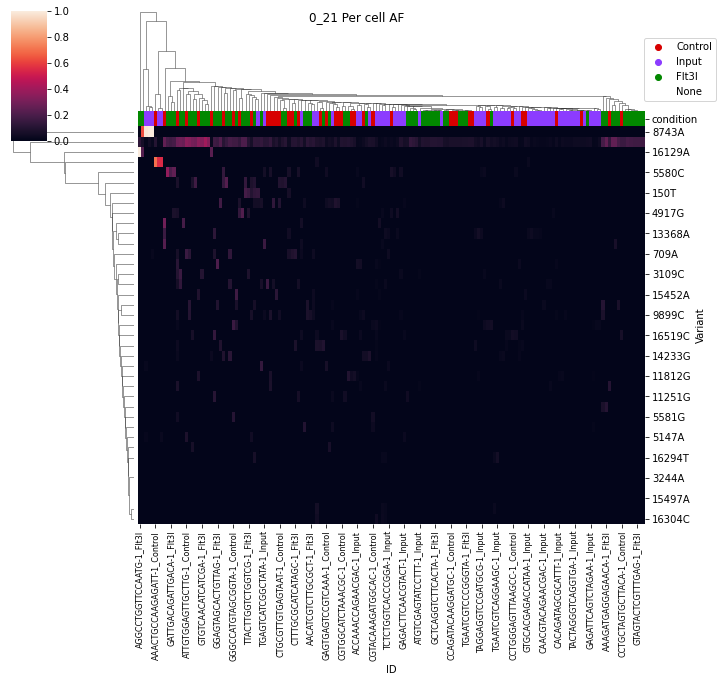

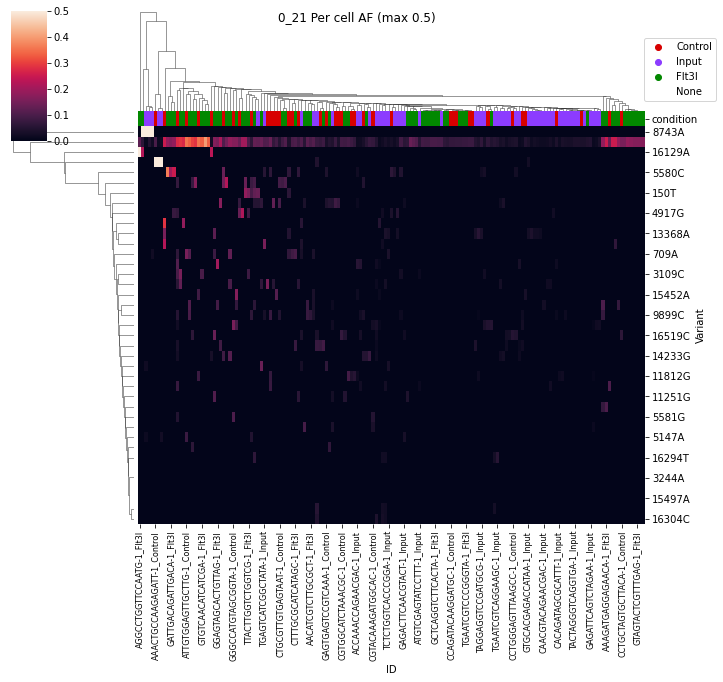

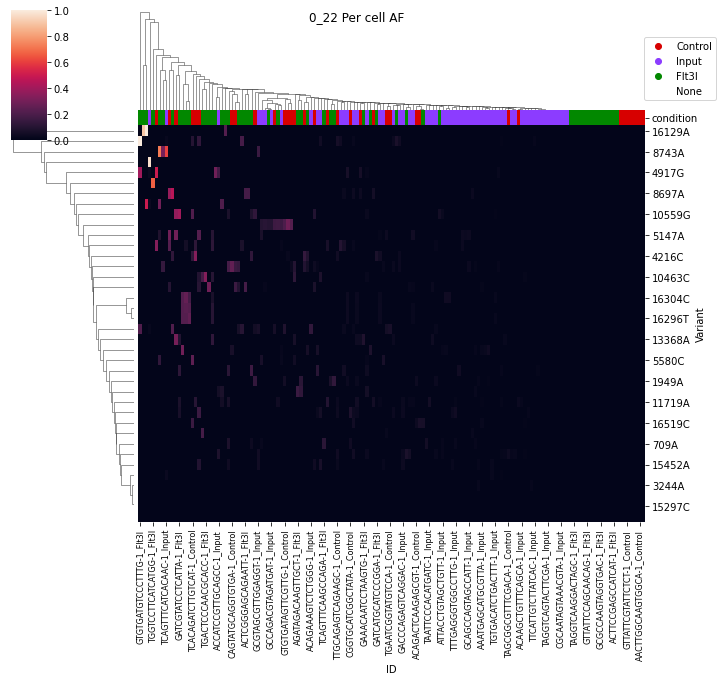

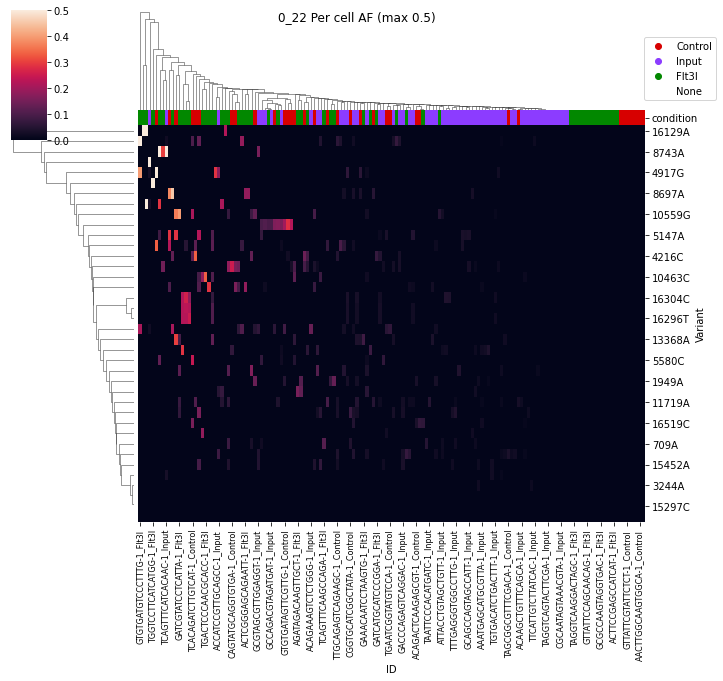

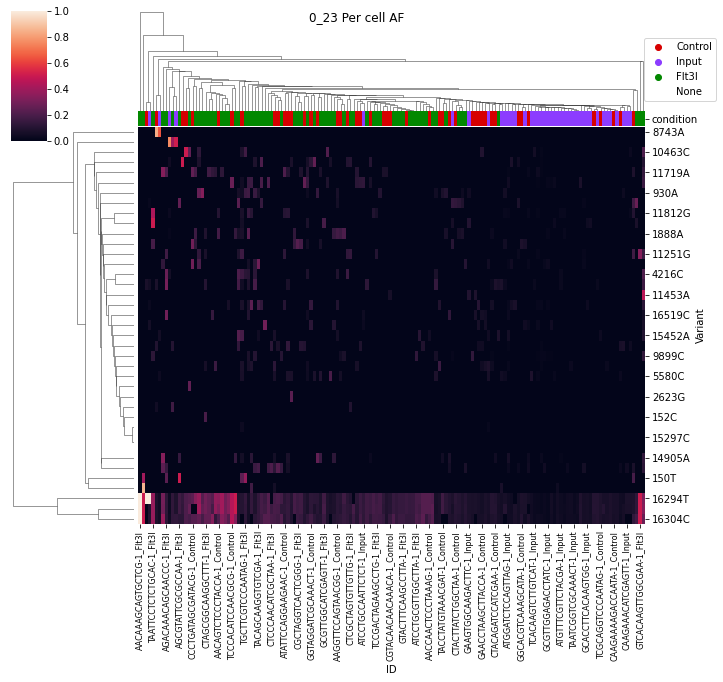

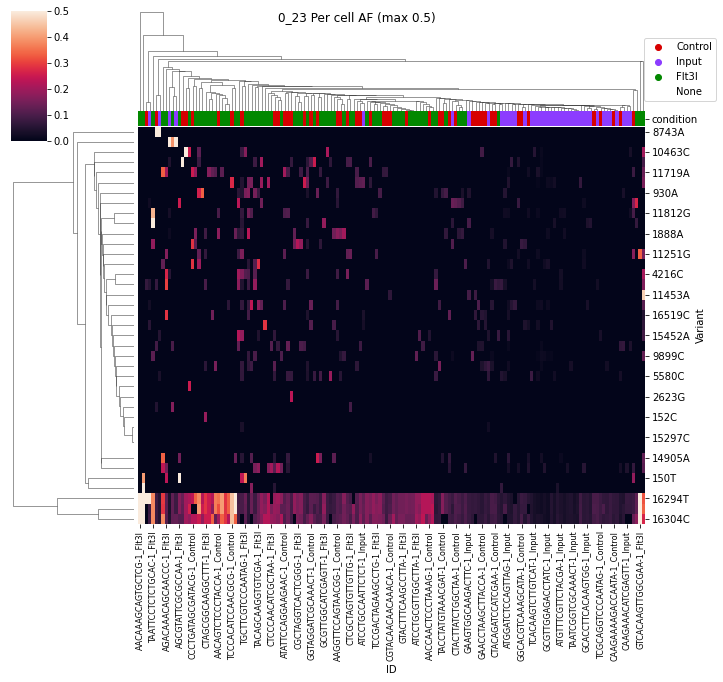

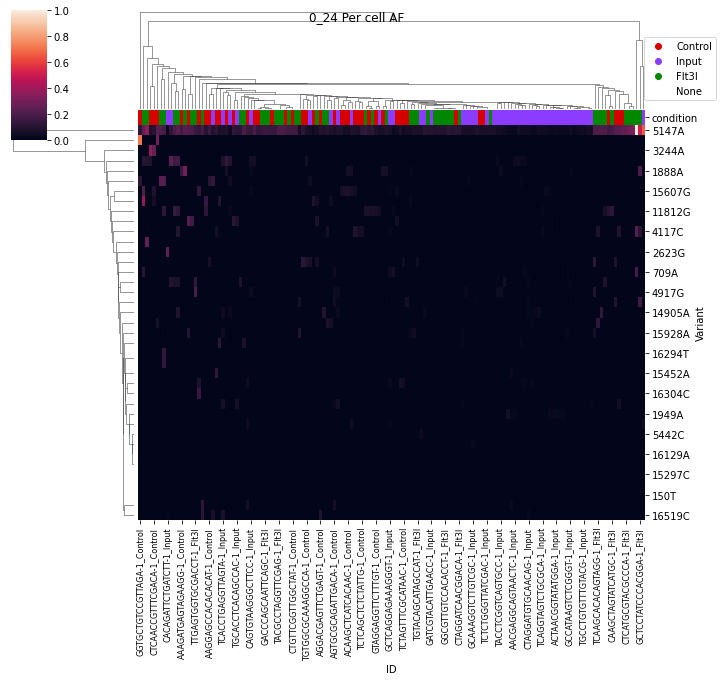

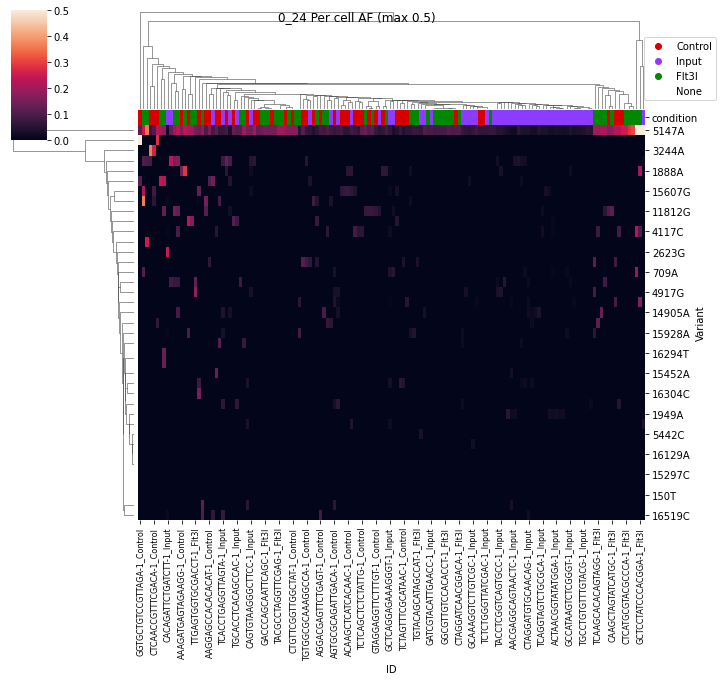

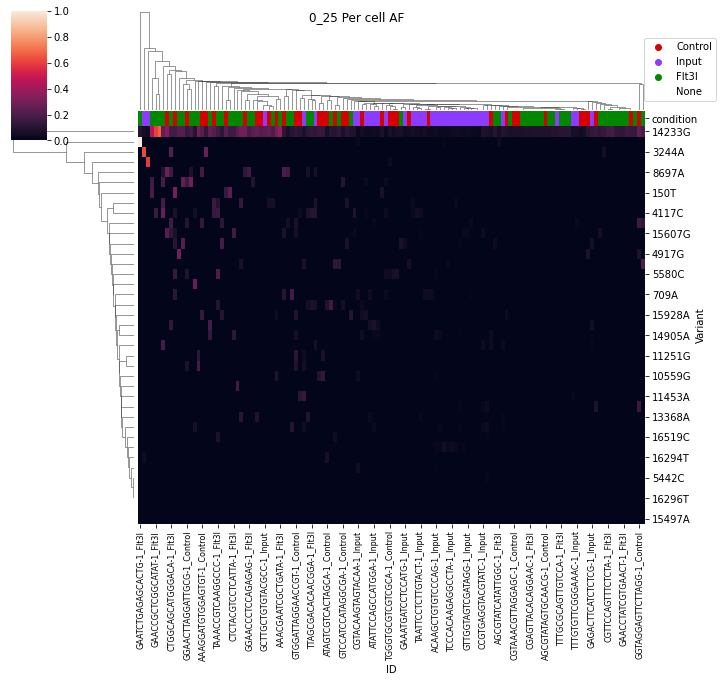

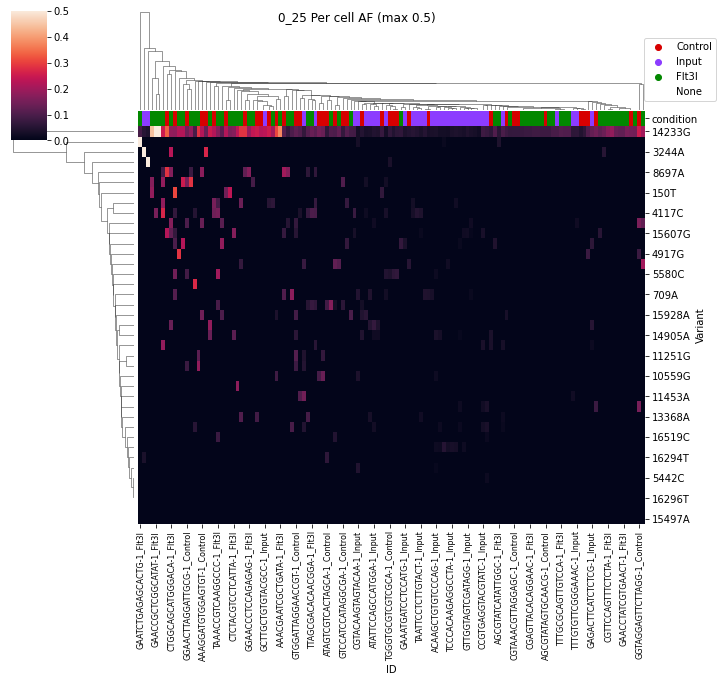

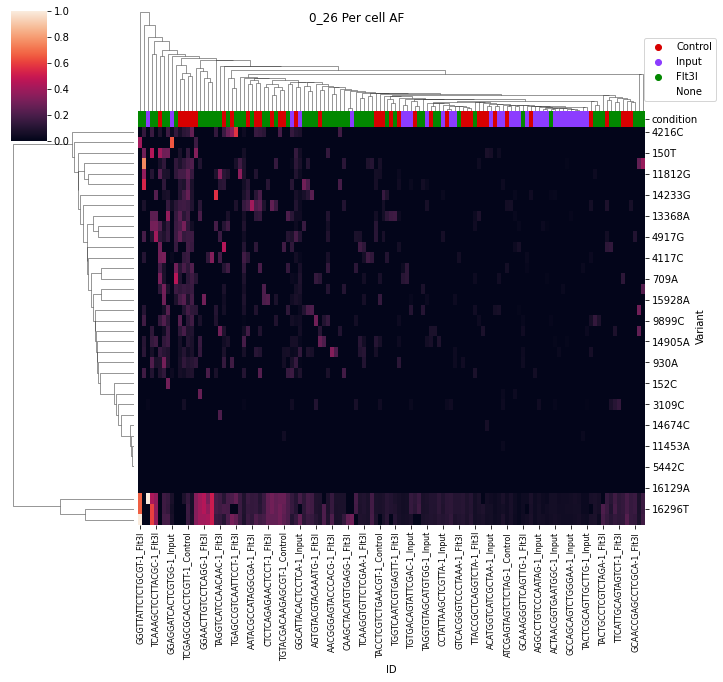

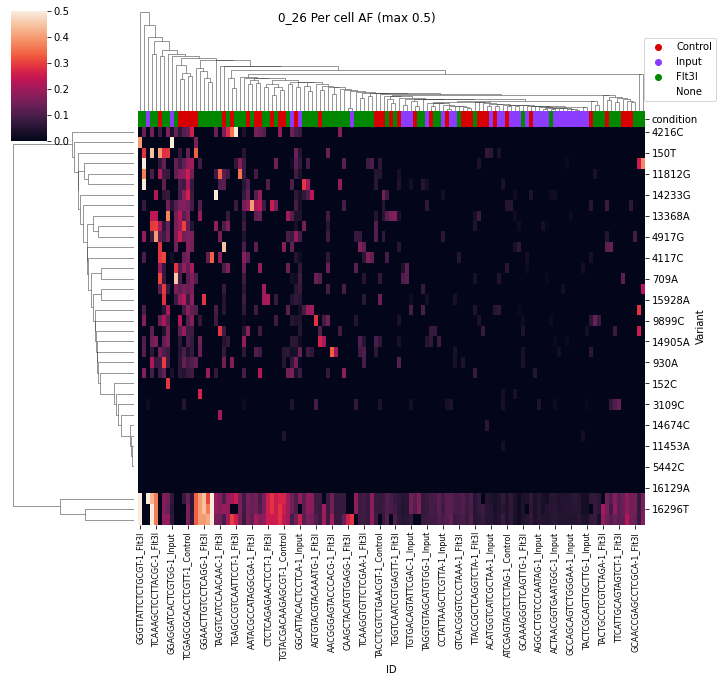

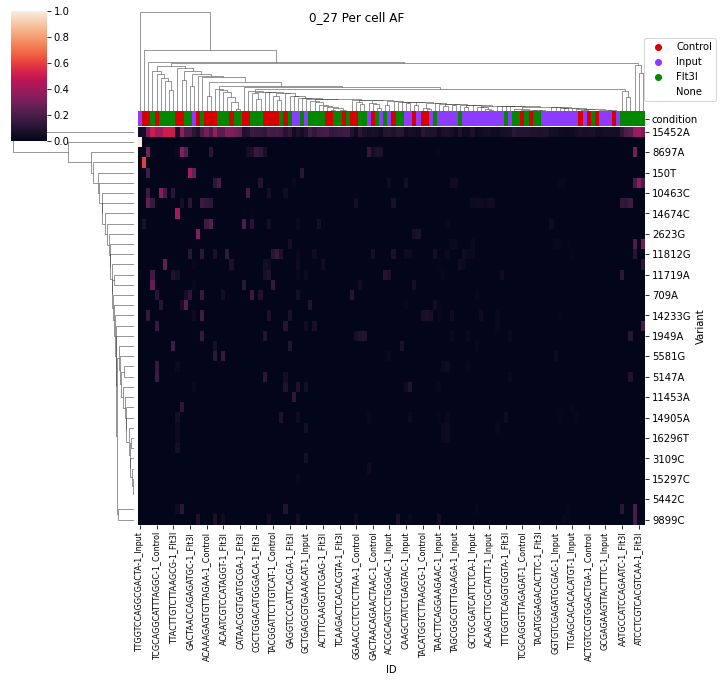

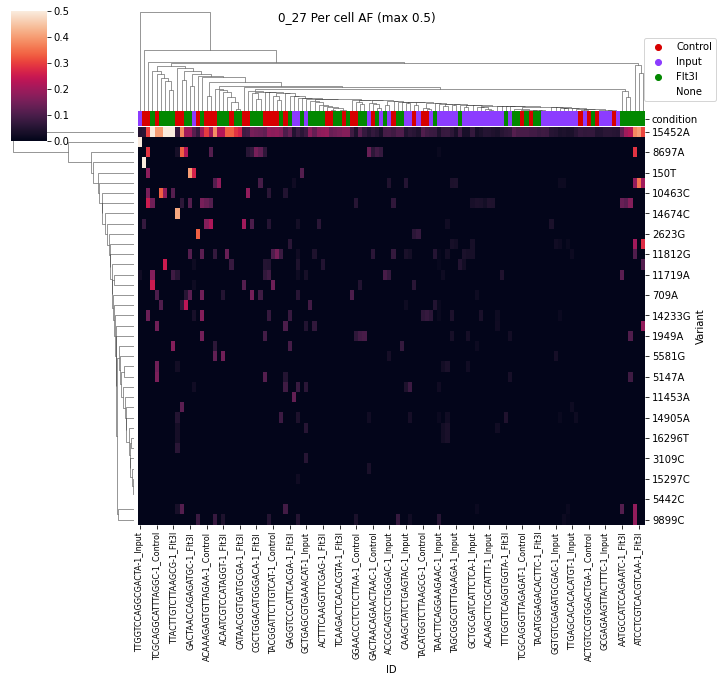

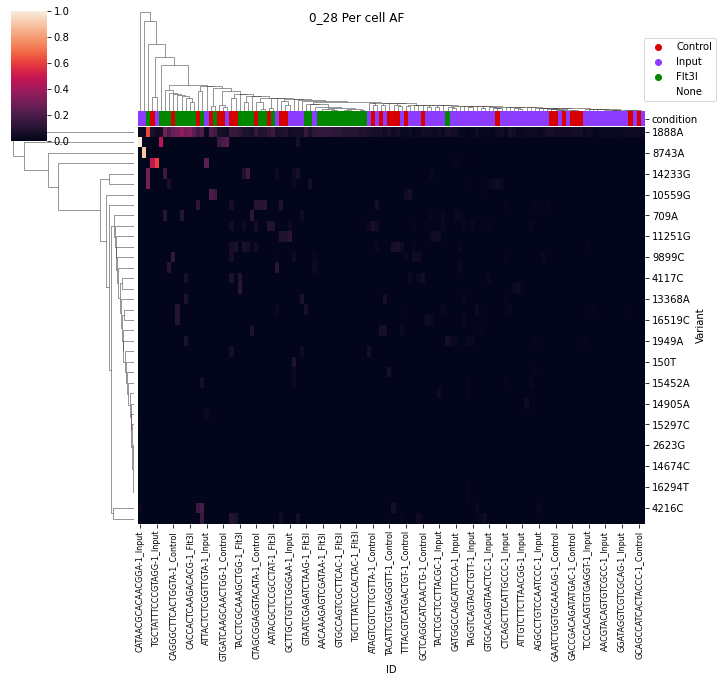

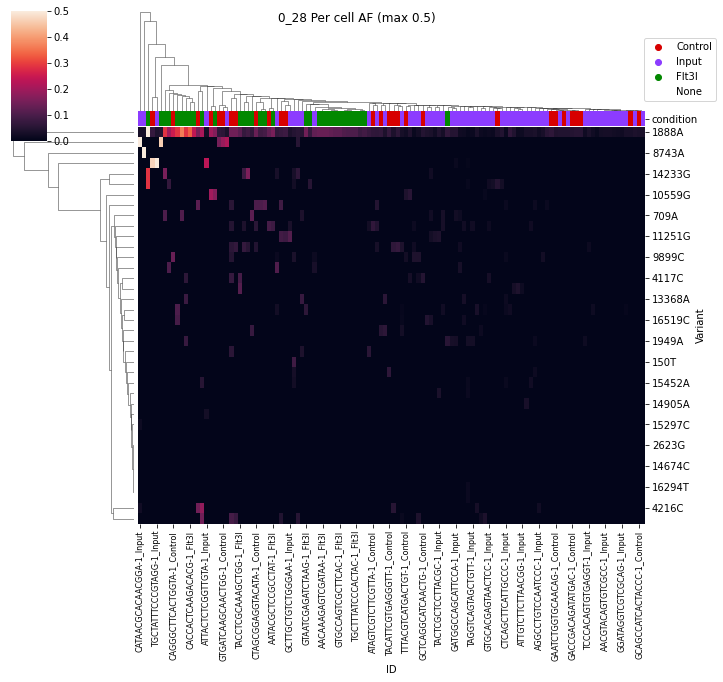

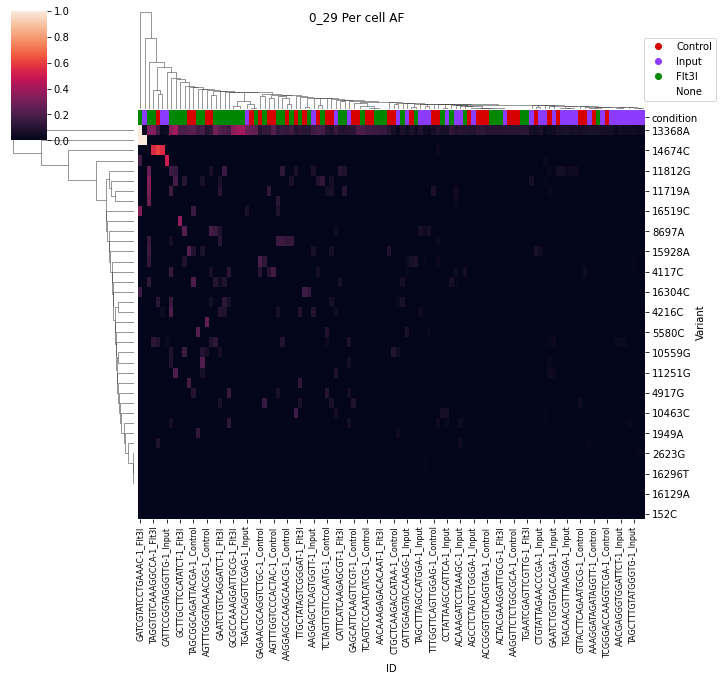

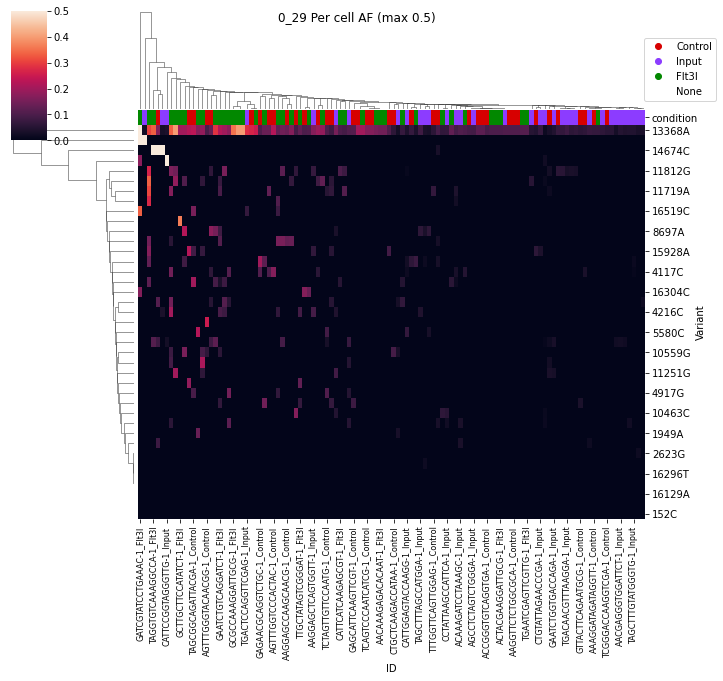

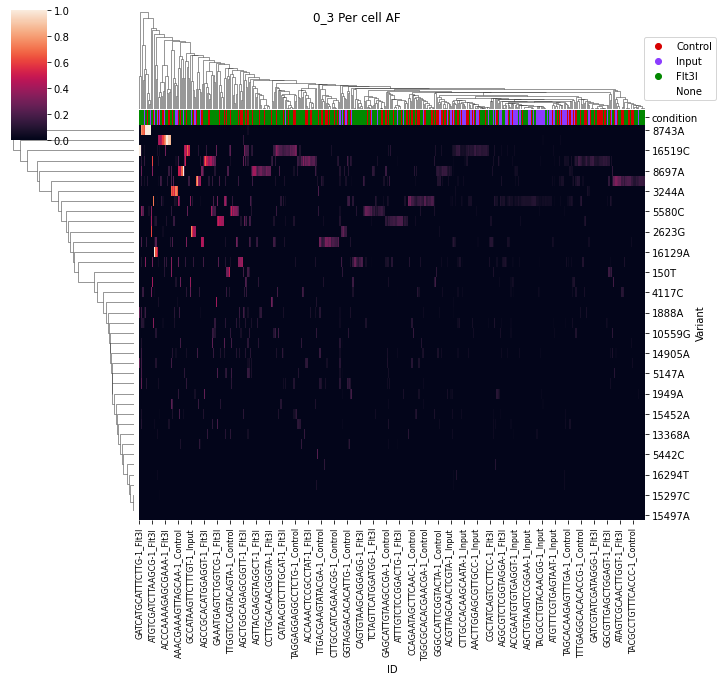

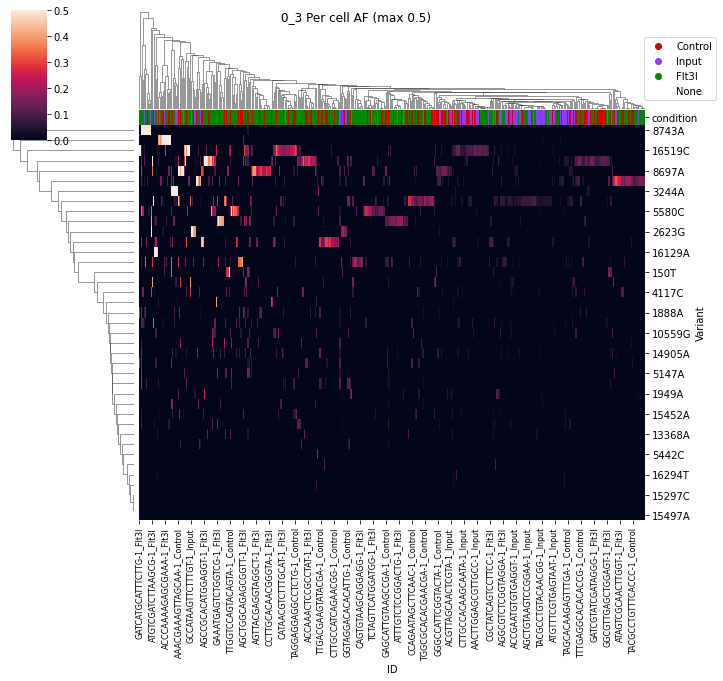

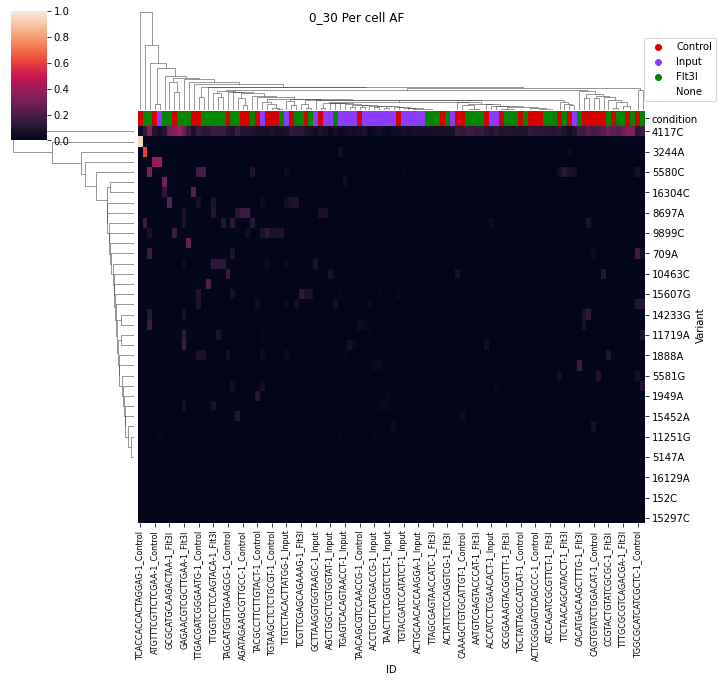

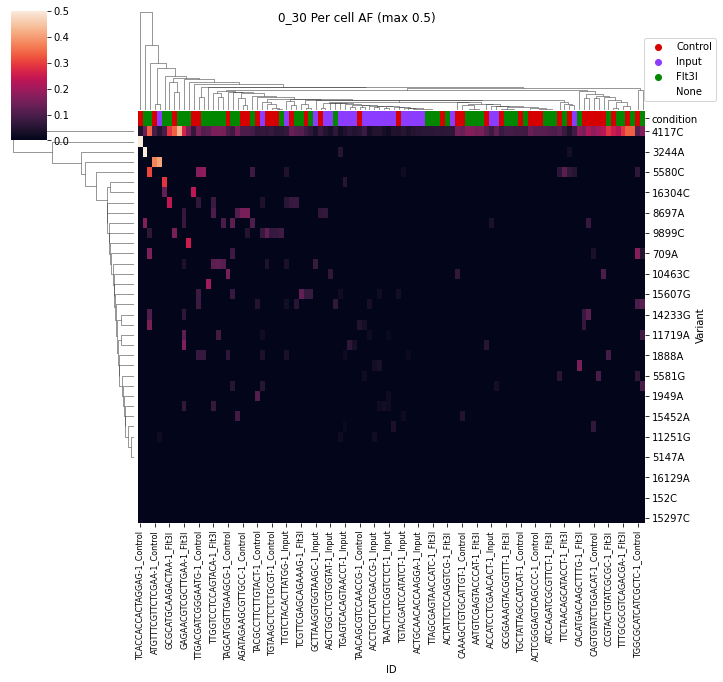

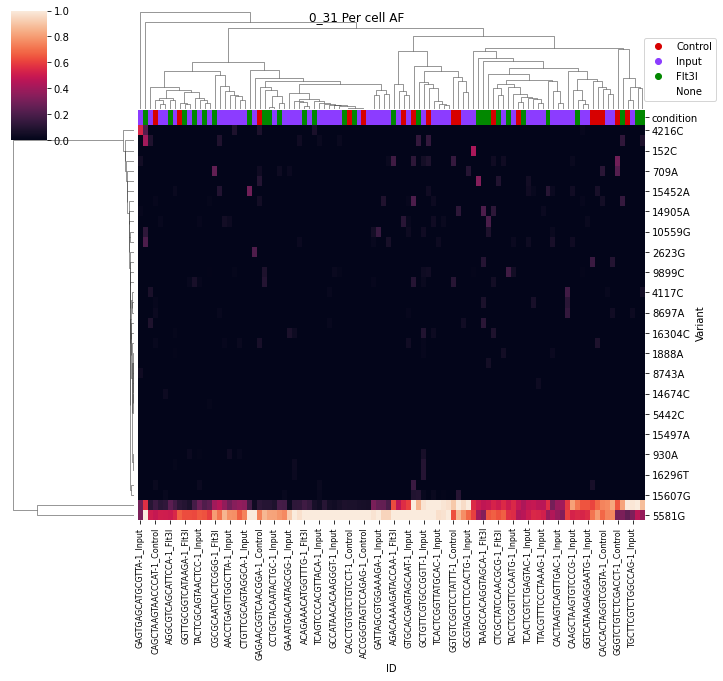

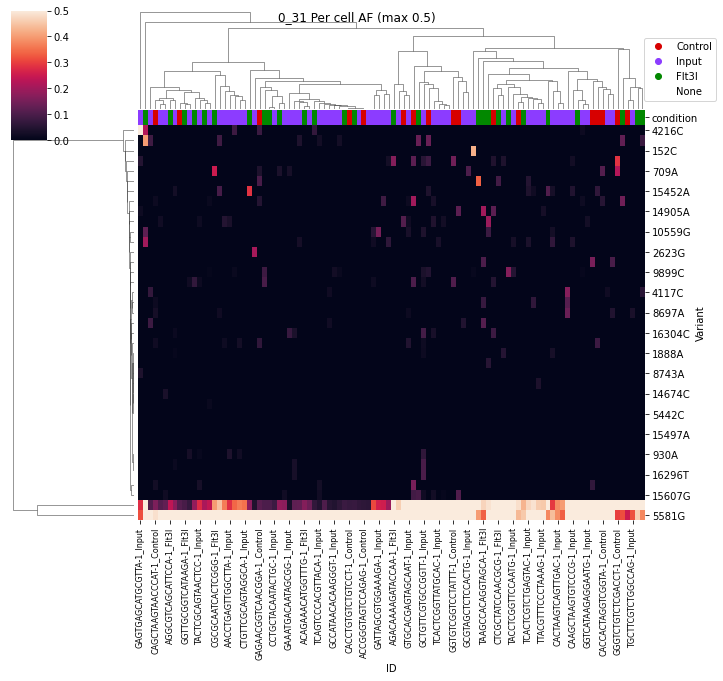

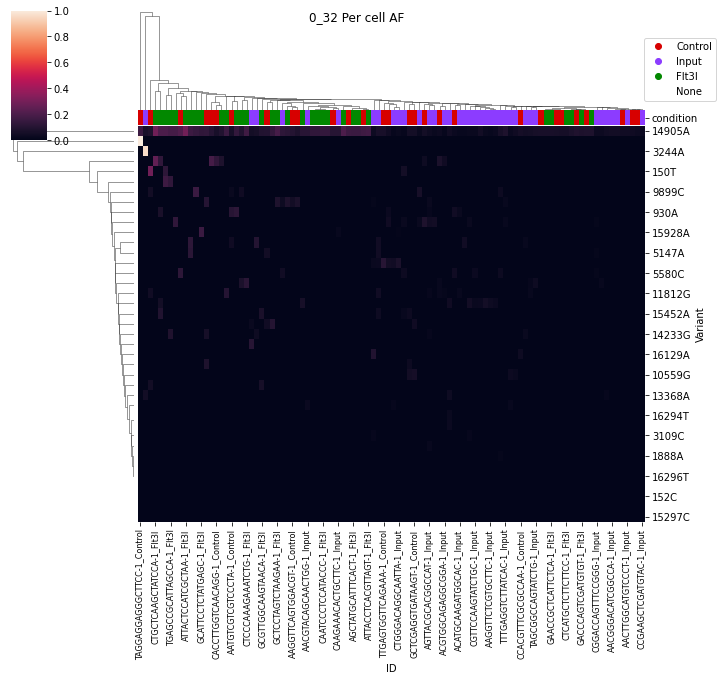

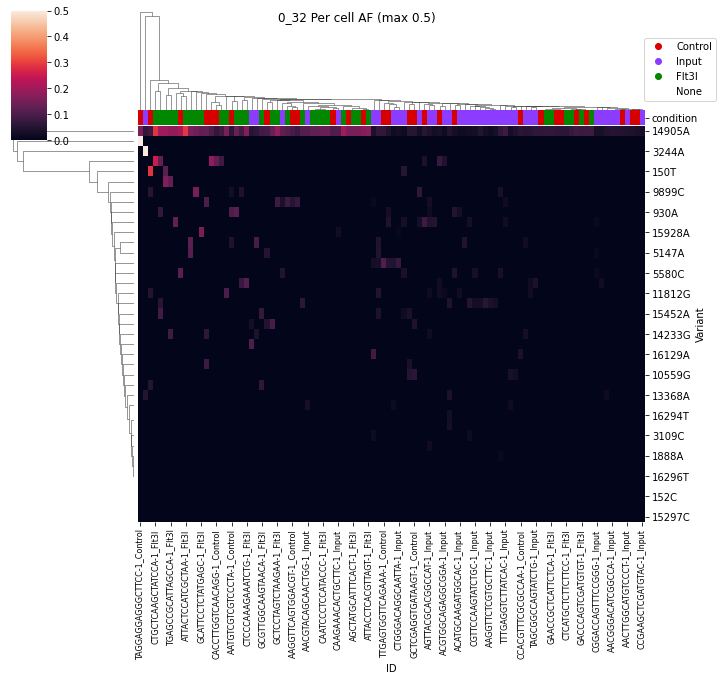

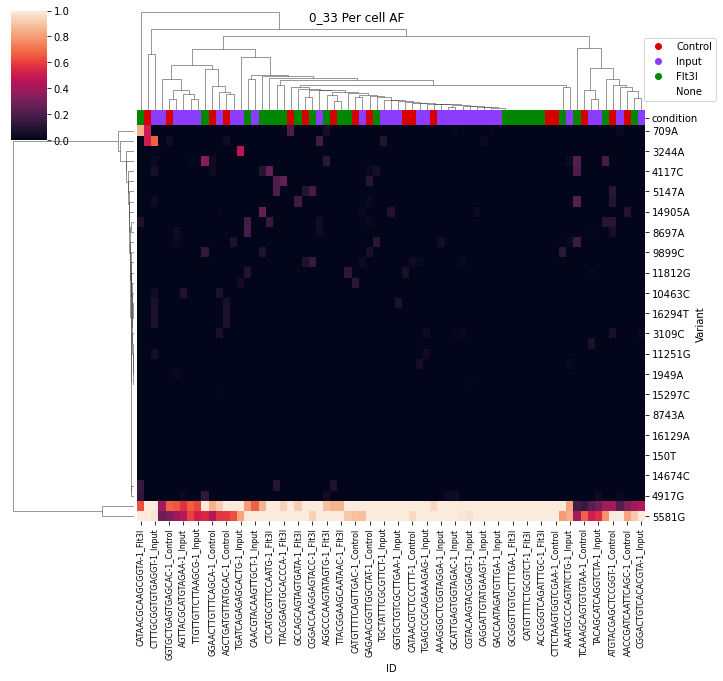

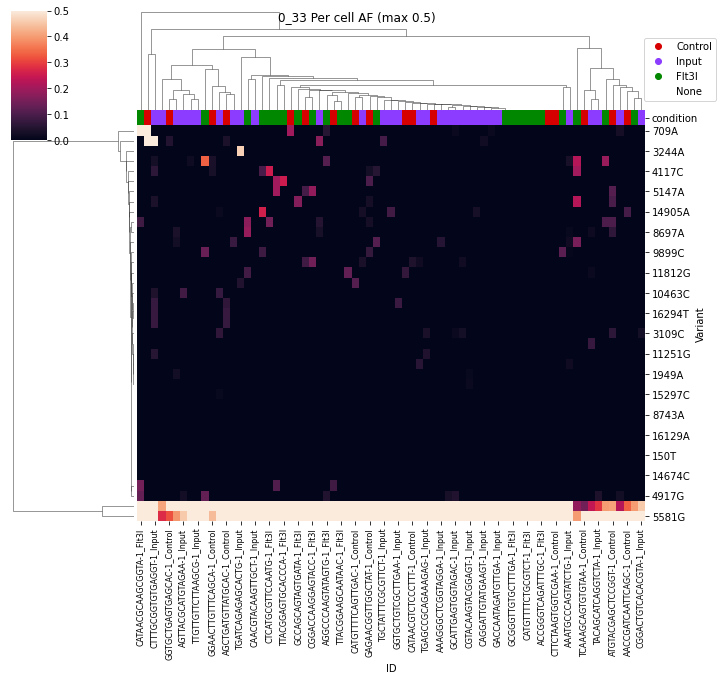

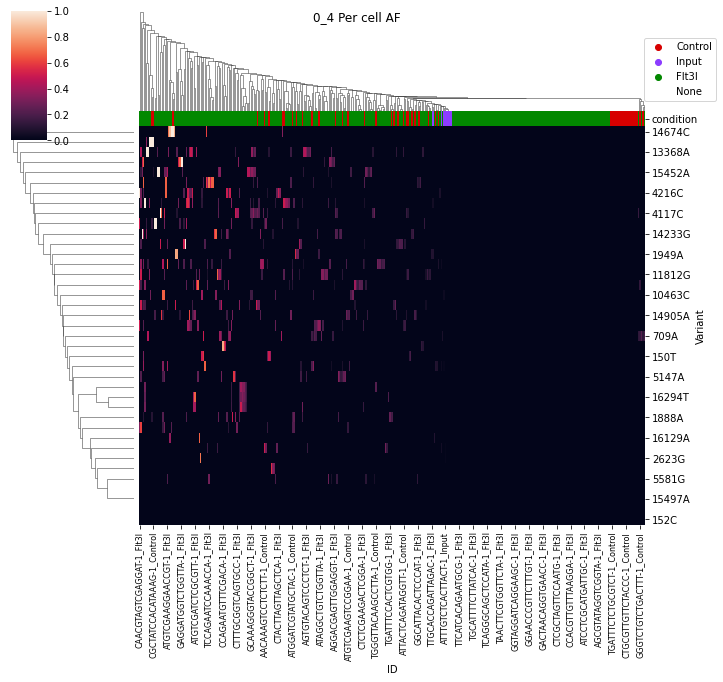

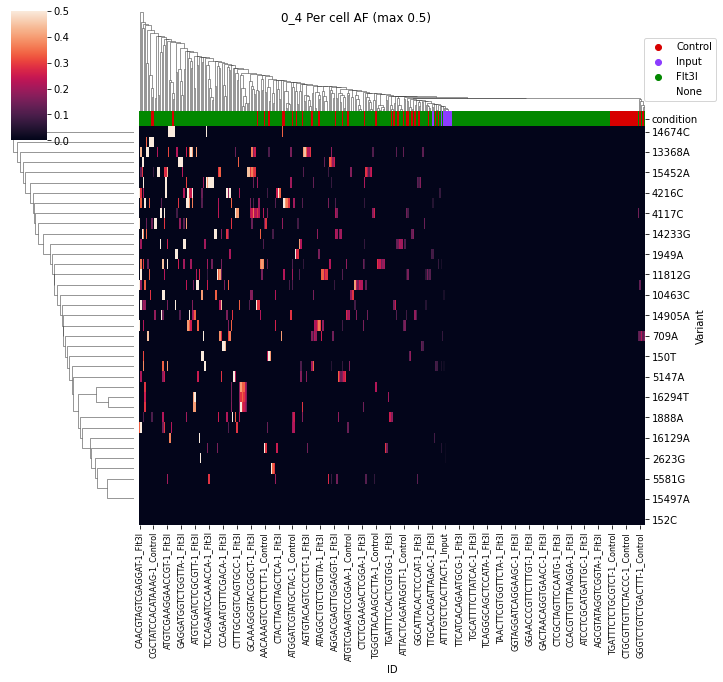

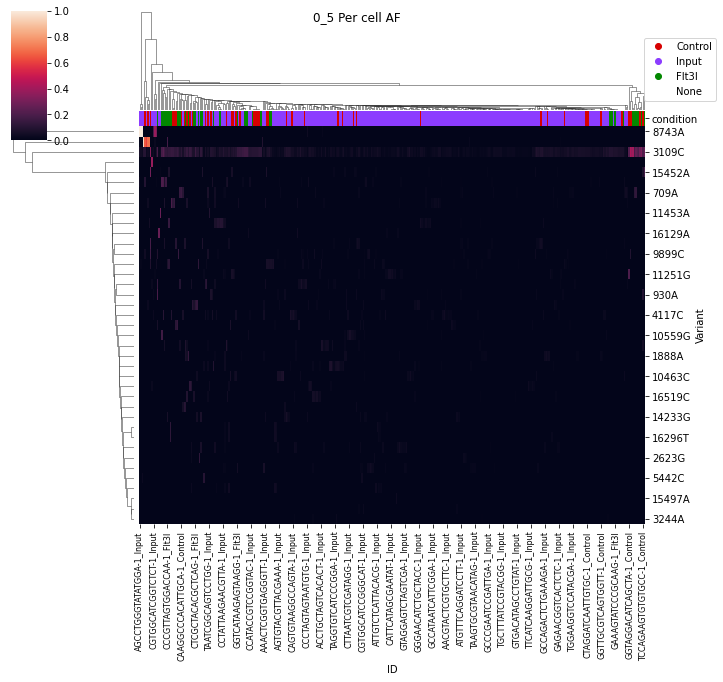

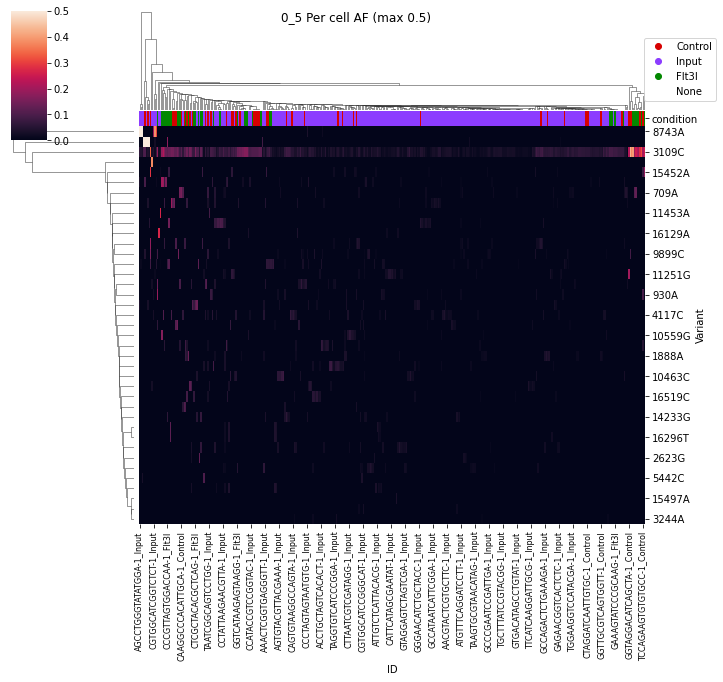

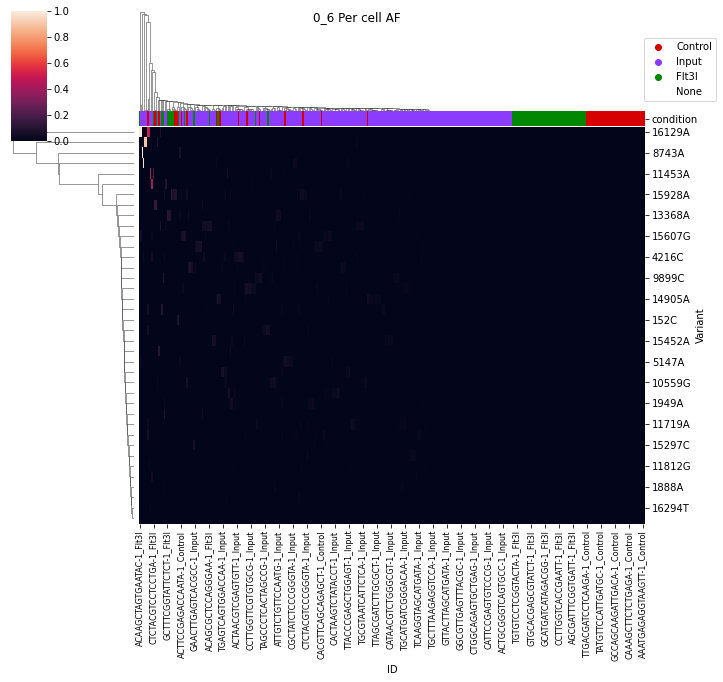

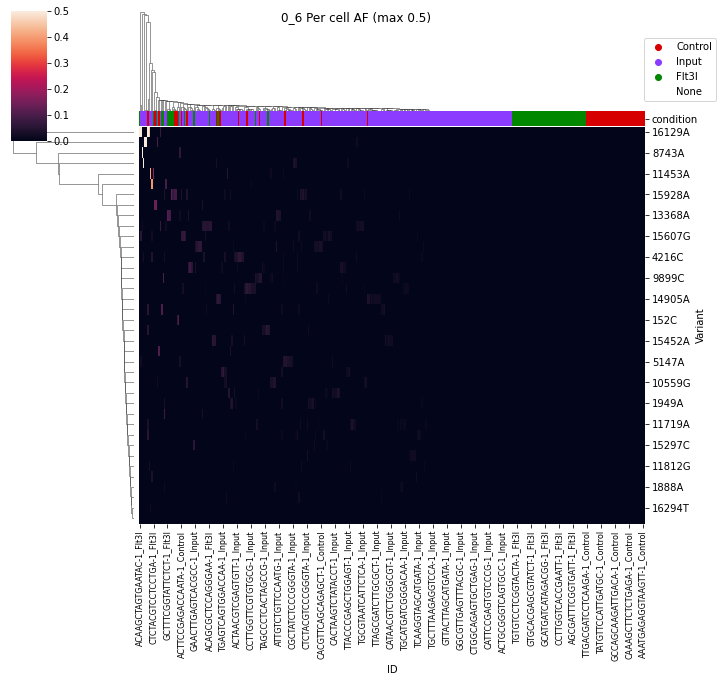

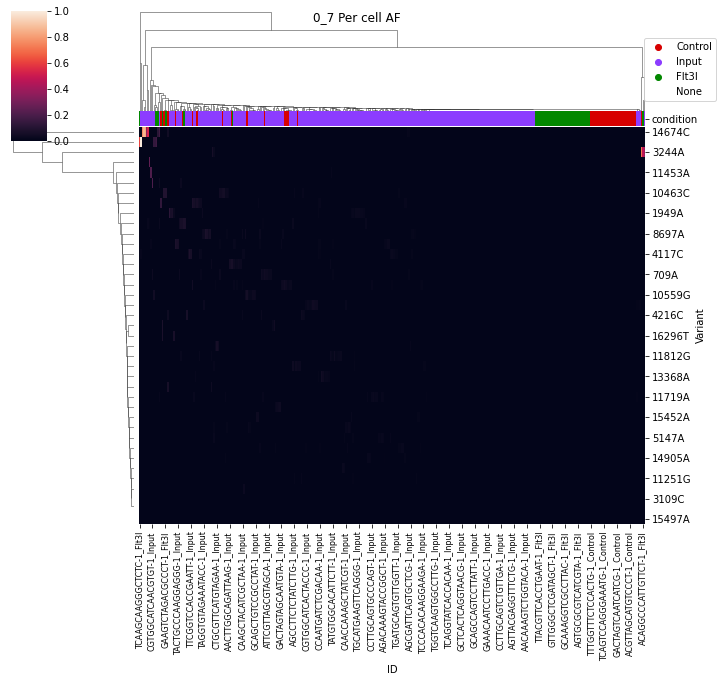

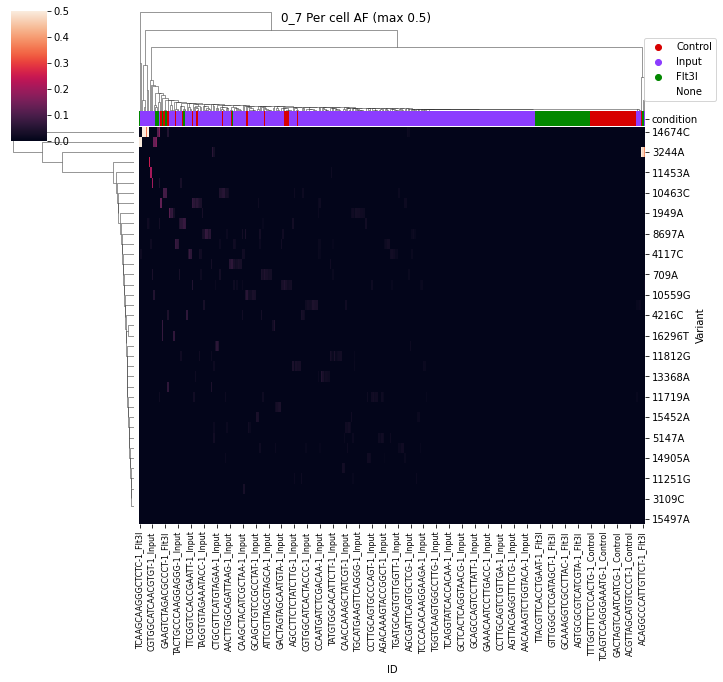

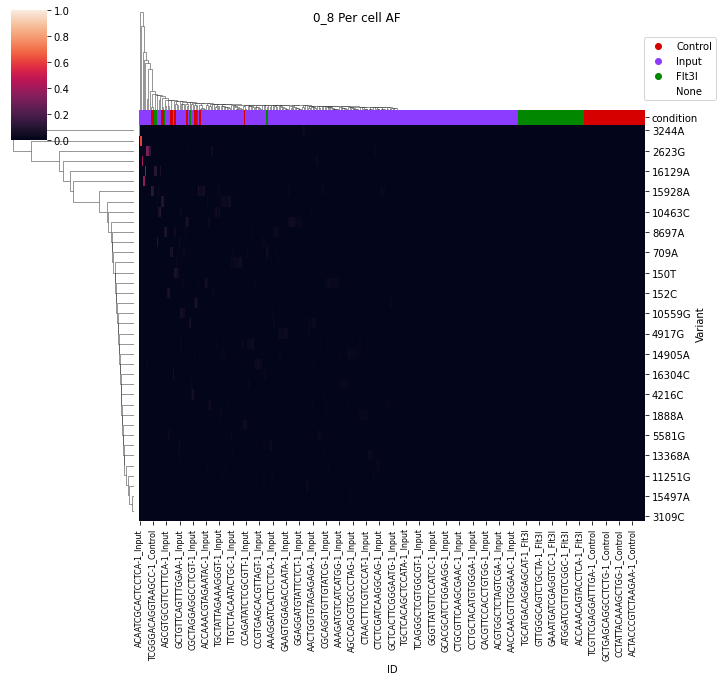

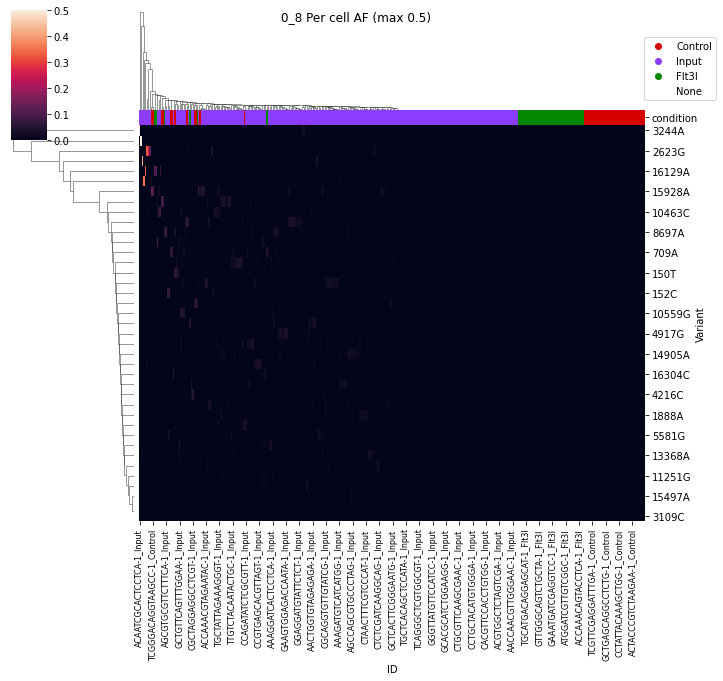

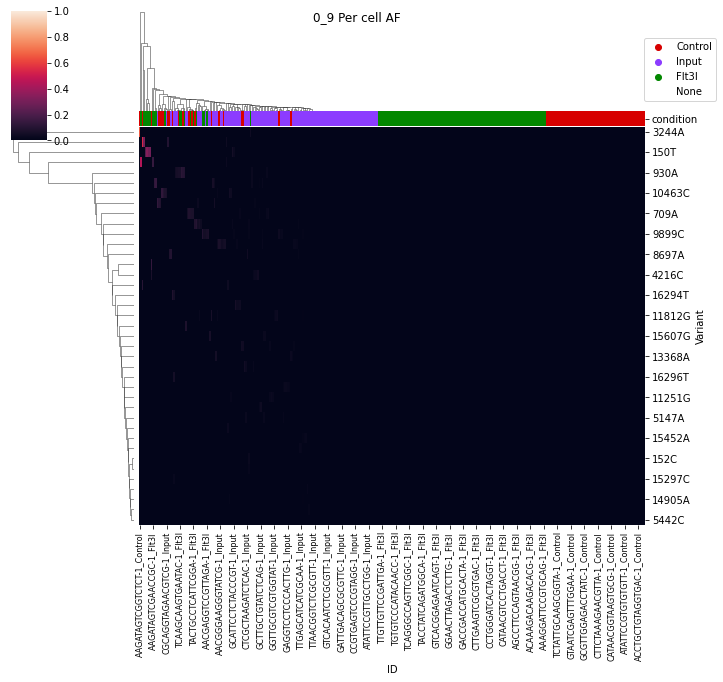

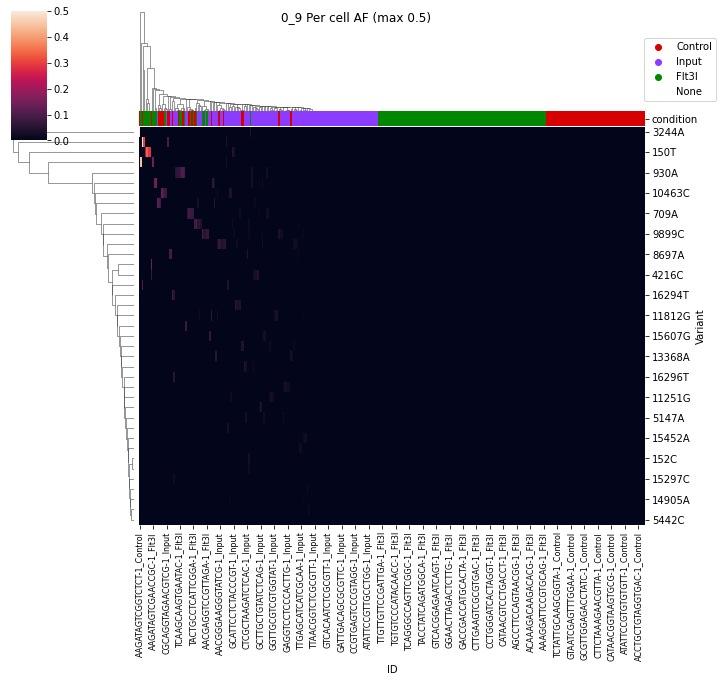

In [15]:
for cln, val in curr_labels.groupby("name"):
    print(cln)
    curr_af = AF_df.loc[:, val.index]
    curr_dp = DP_df.loc[:, val.index]
    curr_labs = curr_labels[curr_labels.index.isin(curr_af.columns)]
    print(curr_af.shape)
    curr_anno = pd.DataFrame(curr_af.apply(lambda x: x.name.split("_")[-1], axis=0)).rename({0:"condition"},axis=1)

    g2 = ch.plot_cluster(rm_high(curr_af, 0.8, 0.8), 
                         col_meta=curr_anno, #curr_labels[["condition", "lineage"]], 
                        to_row_clust=True, to_col_clust=True, vmax=1, vmin=0)
    plt.suptitle(f"{cln} Per cell AF")
    plt.savefig(join(OUTDIR, f"{cln}_cell_af.png"))
    
    g2 = ch.plot_cluster(rm_high(curr_af, 0.8, 0.8), 
                         col_meta=curr_anno, #curr_labels[["condition", "lineage"]], 
                        to_row_clust=True, to_col_clust=True, vmax=0.5, vmin=0)
    plt.suptitle(f"{cln} Per cell AF (max 0.5)")
    
    plt.savefig(join(OUTDIR, f"{cln}_cell_af_0.5.png"))


## Plot median and mean of each clone in each condition

0_0
(68, 957)
clustering
cmap None
clustering
cmap None
0_1
(68, 624)
clustering
cmap None
clustering
cmap None
0_10
(68, 326)
clustering
cmap None
clustering
cmap None


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:717: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)


0_11
(68, 318)
clustering
cmap None
clustering
cmap None
0_12
(68, 318)
clustering
cmap None
clustering
cmap None
0_13
(68, 266)
clustering
cmap None
clustering
cmap None
0_14
(68, 250)
clustering
cmap None
clustering
cmap None
0_15
(68, 232)
clustering
cmap None
clustering
cmap None
0_16
(68, 230)
clustering
cmap None
clustering
cmap None
0_17
(68, 214)
clustering
cmap None
clustering
cmap None
0_18
(68, 210)
clustering
cmap None


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:805: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)


clustering
cmap None
0_19
(68, 197)
clustering
cmap None
clustering
cmap None
0_2
(68, 545)
clustering
cmap None
clustering
cmap None
0_20
(68, 177)
clustering
cmap None
clustering
cmap None
0_21
(68, 163)
clustering
cmap None
clustering
cmap None
0_22
(68, 154)
clustering
cmap None
clustering
cmap None
0_23
(68, 154)
clustering
cmap None
clustering
cmap None
0_24
(68, 146)
clustering
cmap None
clustering
cmap None
0_25
(68, 130)
clustering
cmap None
clustering
cmap None
0_26
(68, 127)
clustering
cmap None
clustering
cmap None
0_27
(68, 122)
clustering
cmap None
clustering
cmap None
0_28
(68, 122)
clustering
cmap None
clustering
cmap None
0_29
(68, 114)
clustering
cmap None
clustering
cmap None
0_3
(68, 429)
clustering
cmap None
clustering
cmap None
0_30
(68, 104)
clustering
cmap None
clustering
cmap None
0_31
(68, 102)
clustering
cmap None
clustering
cmap None
0_32
(68, 100)
clustering
cmap None
clustering
cmap None
0_33
(68, 71)
clustering
cmap None
clustering
cmap None
0_4
(68, 364)

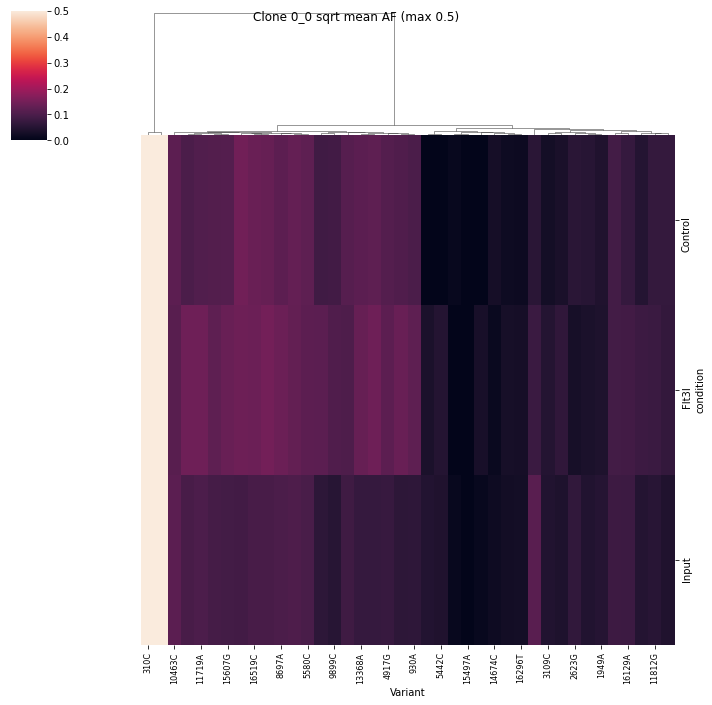

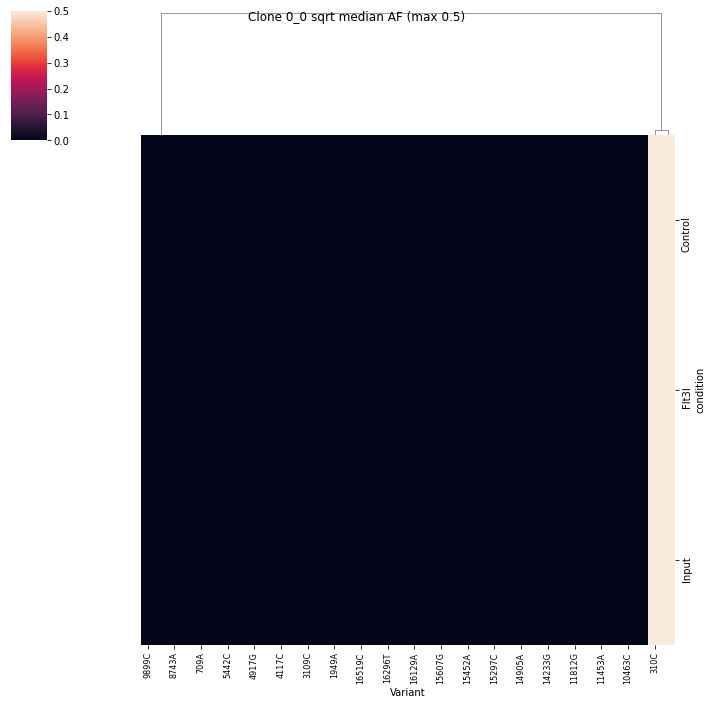

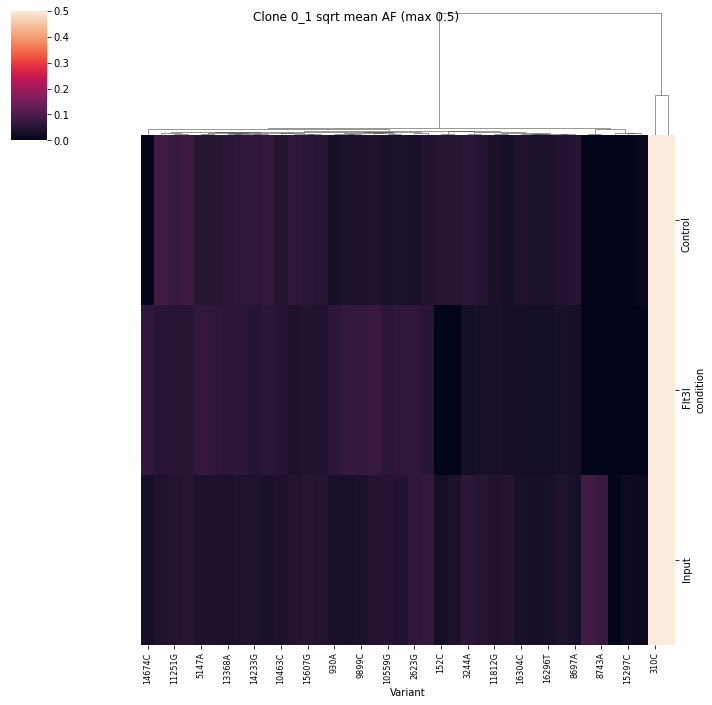

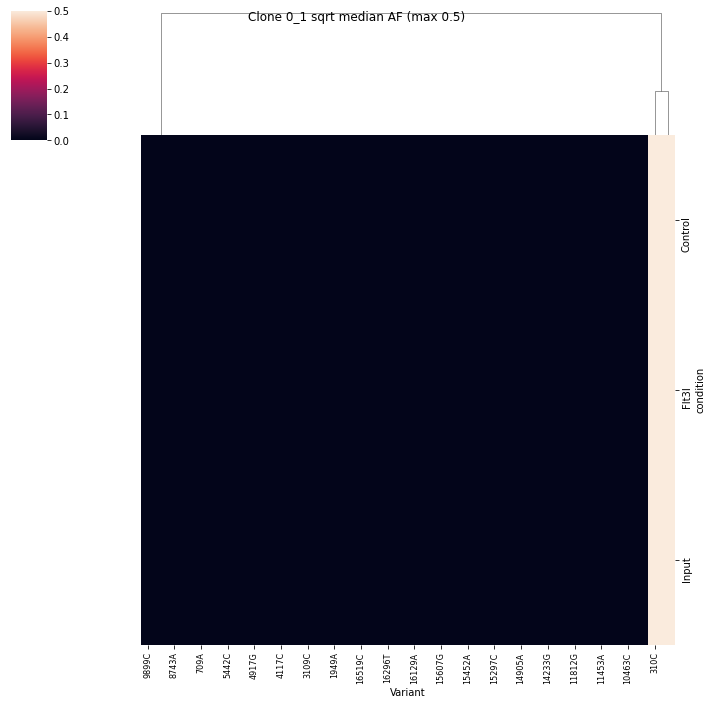

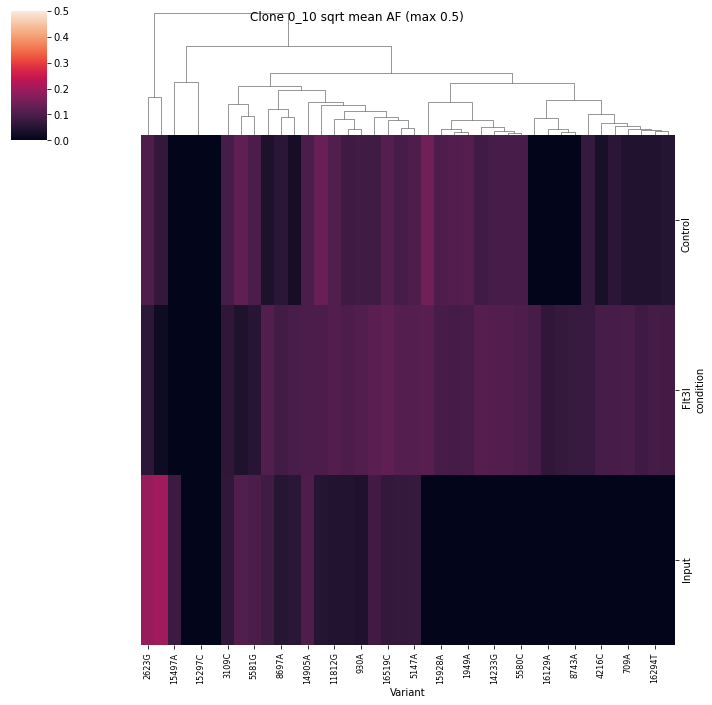

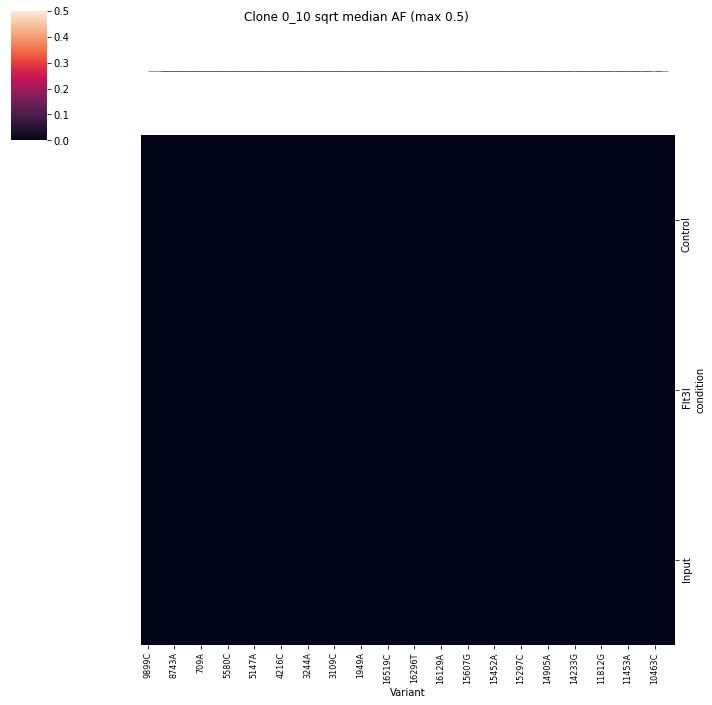

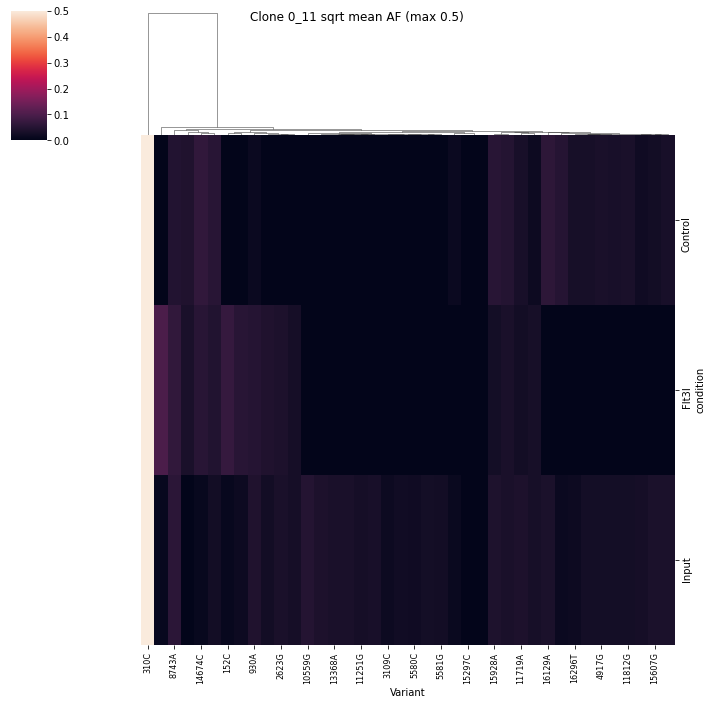

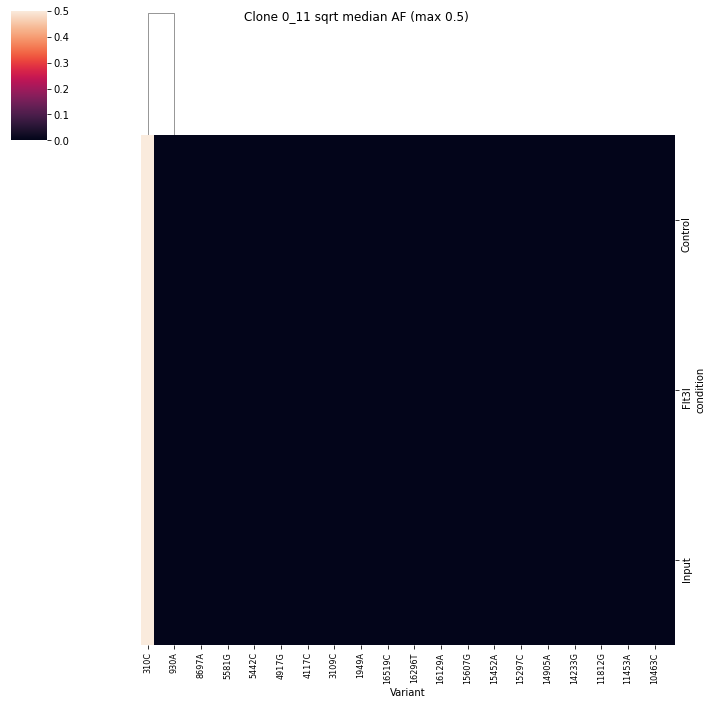

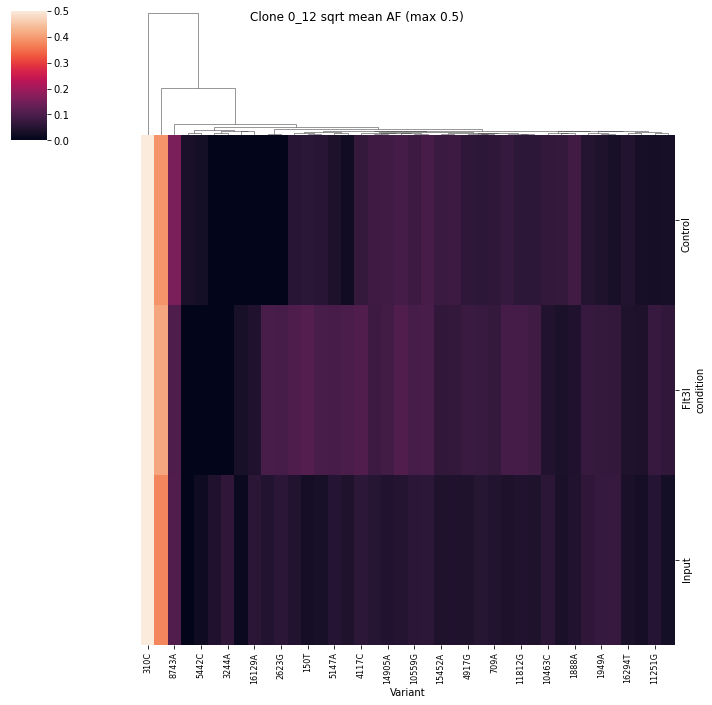

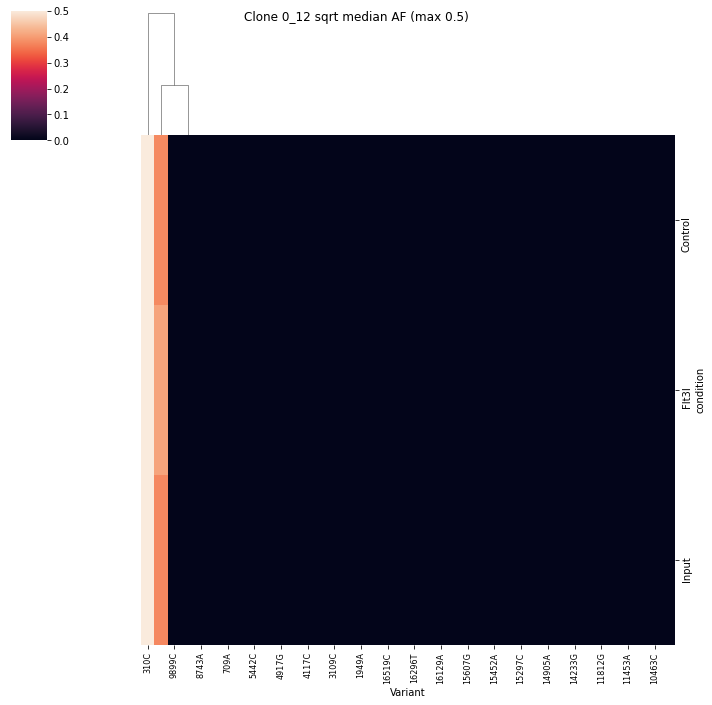

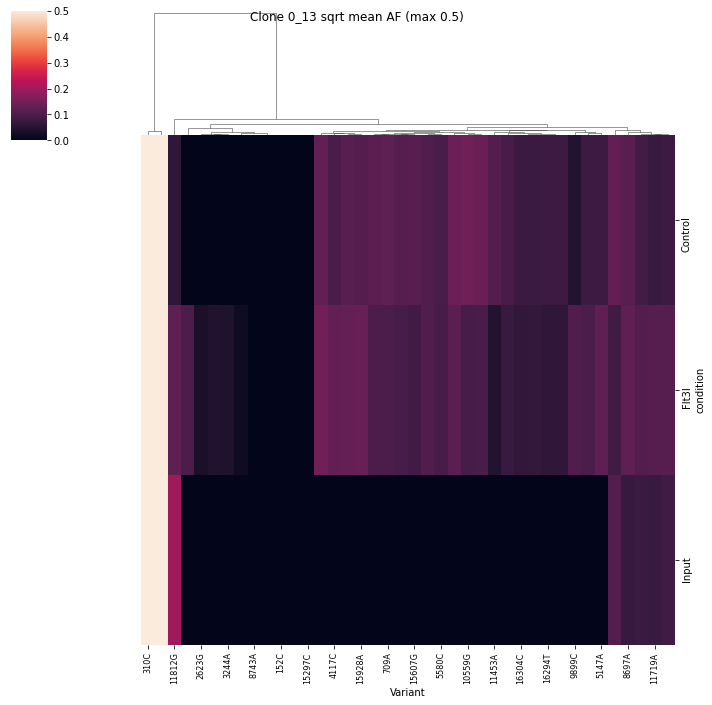

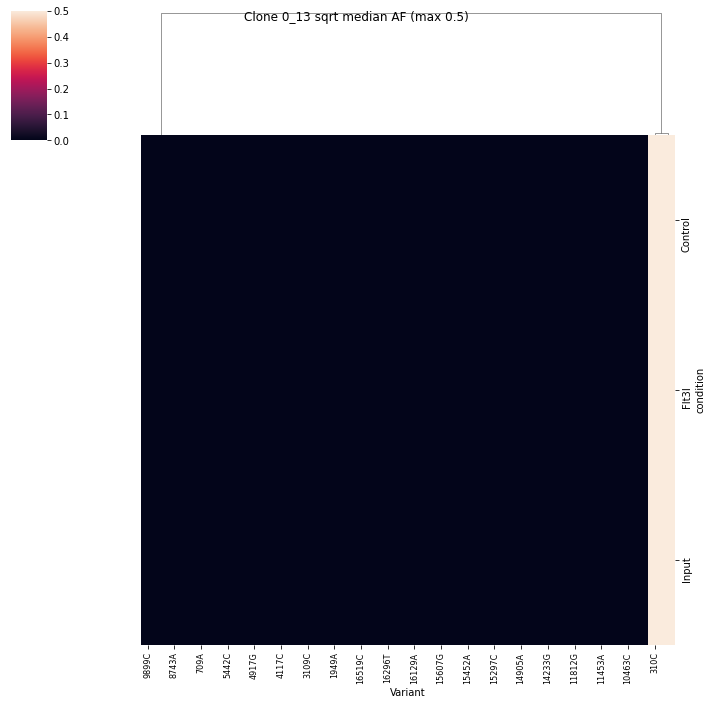

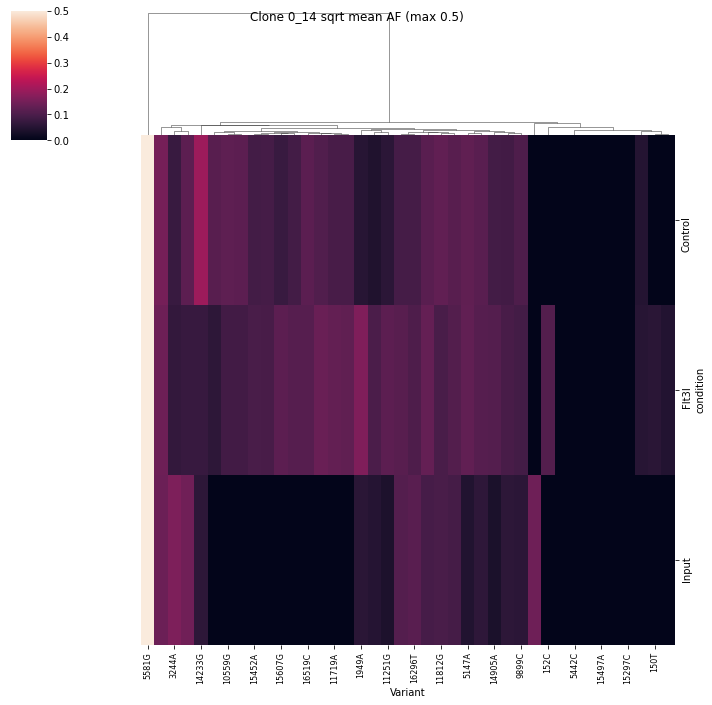

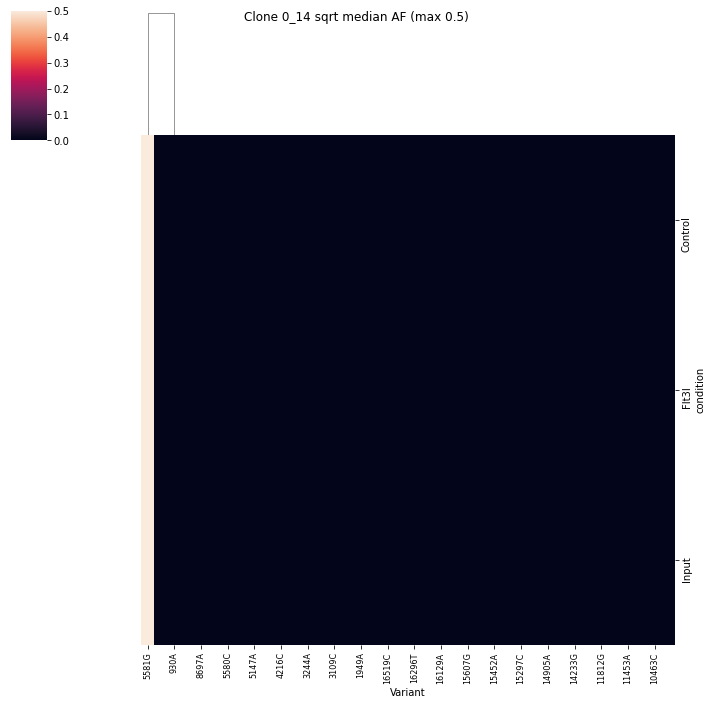

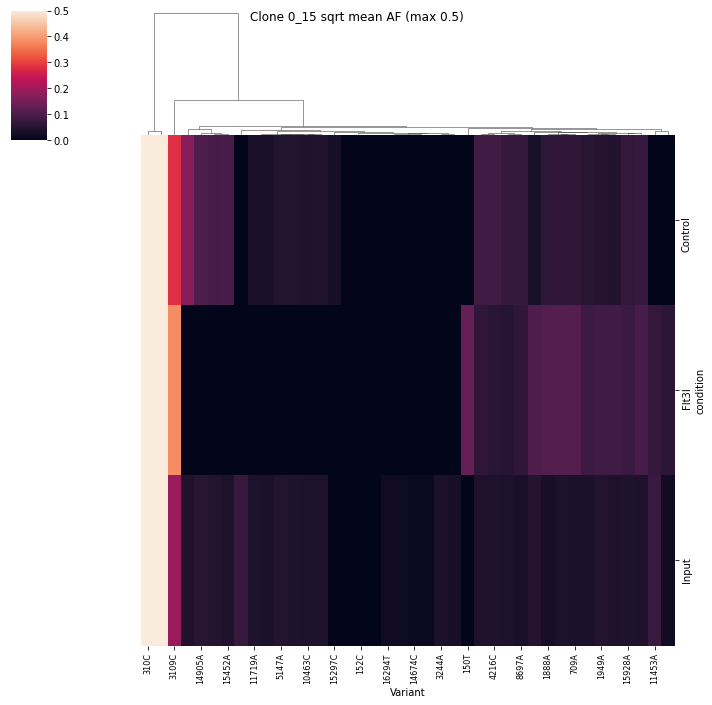

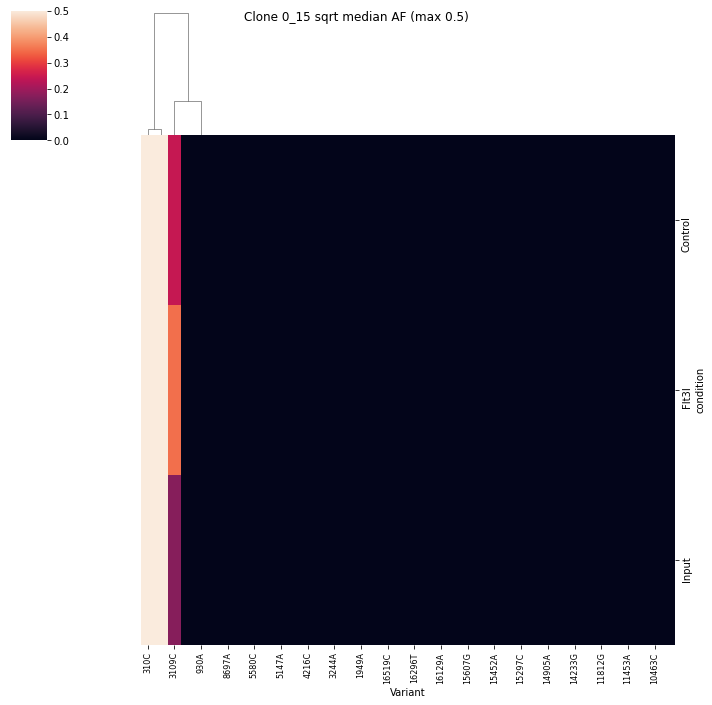

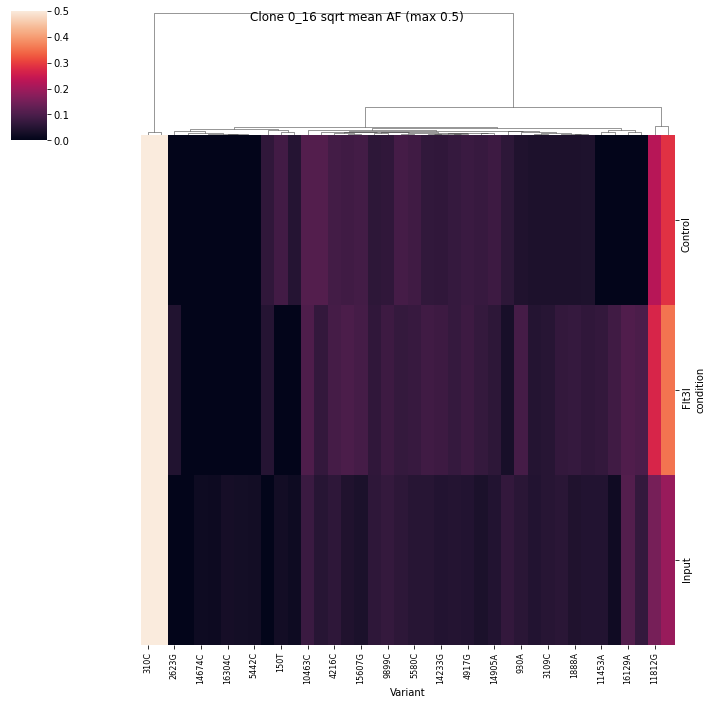

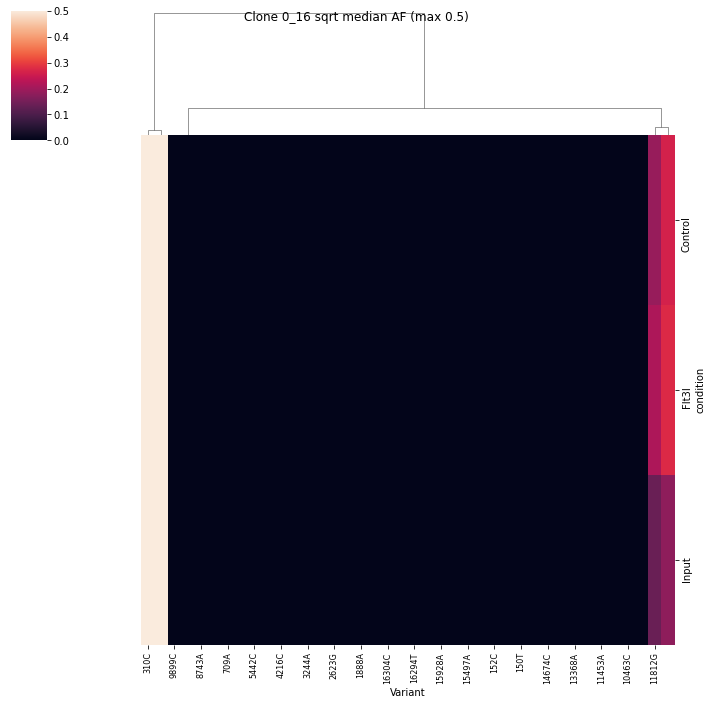

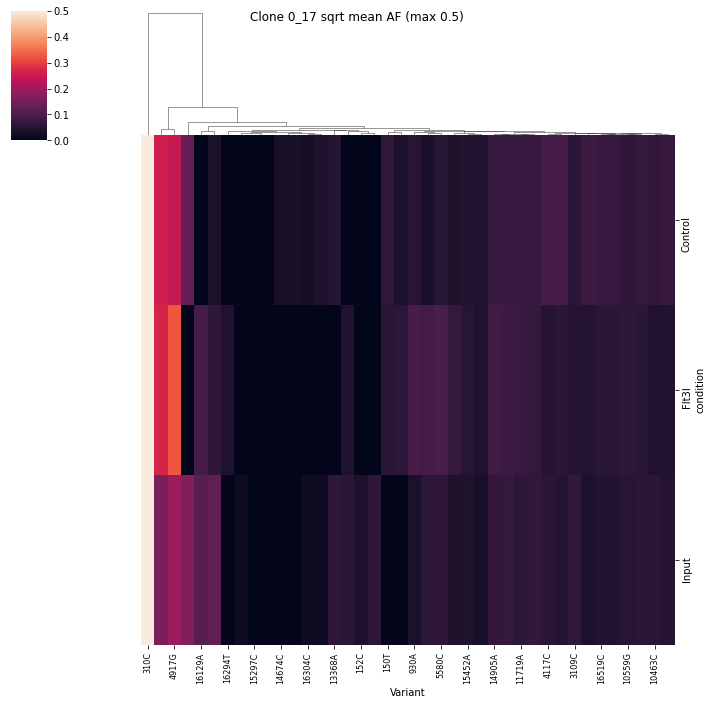

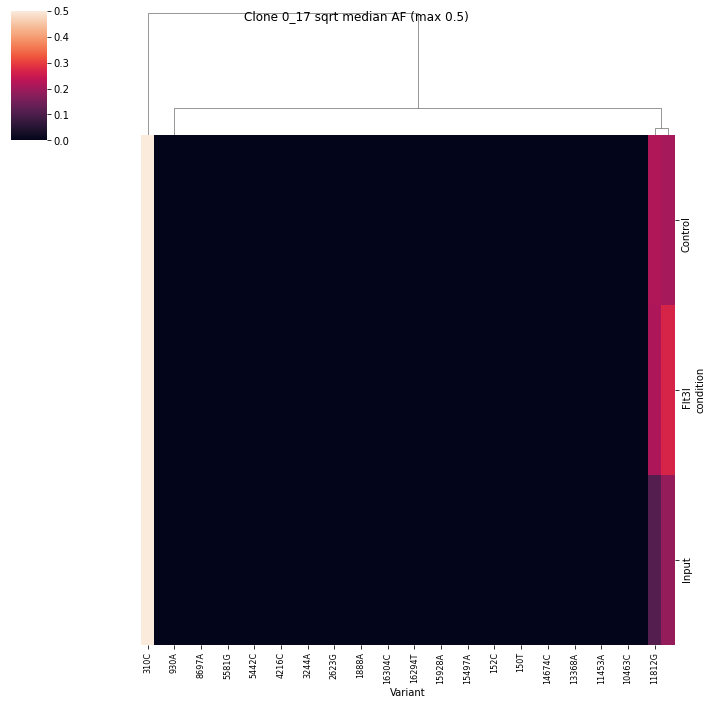

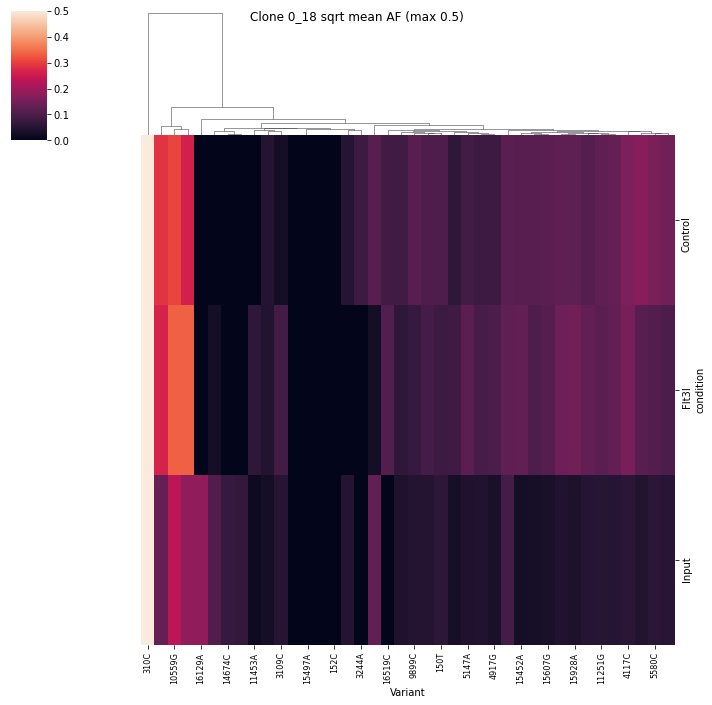

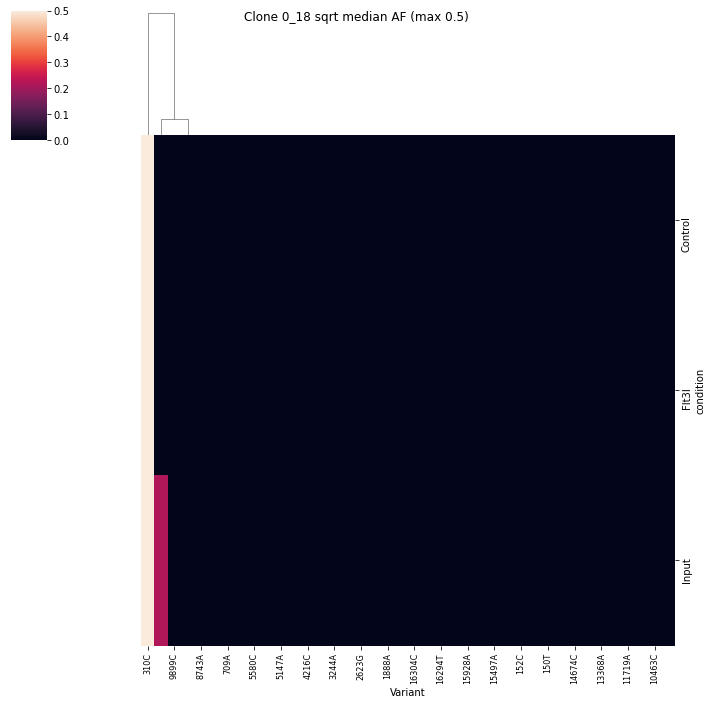

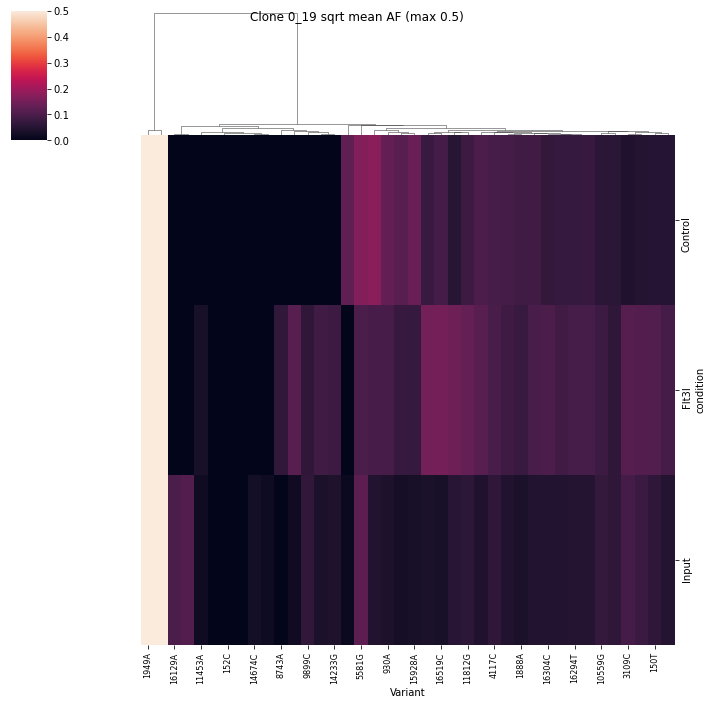

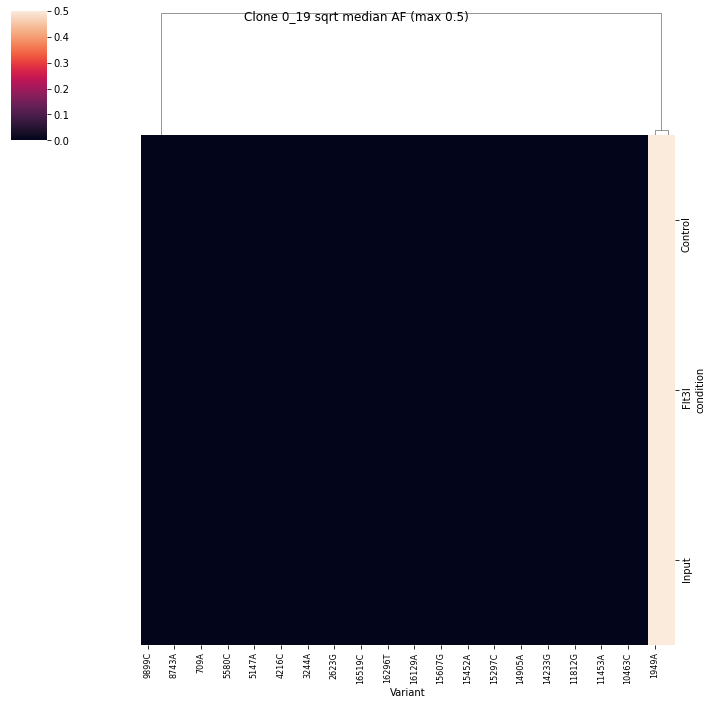

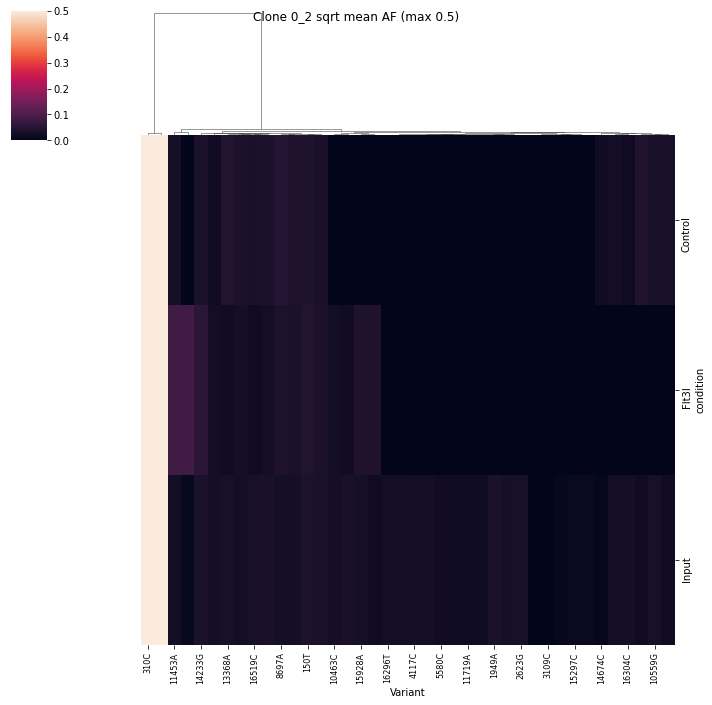

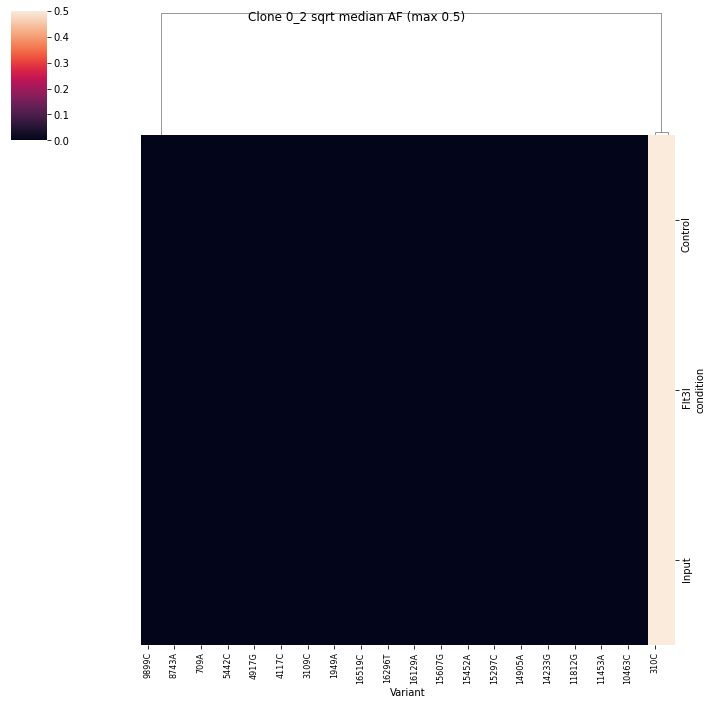

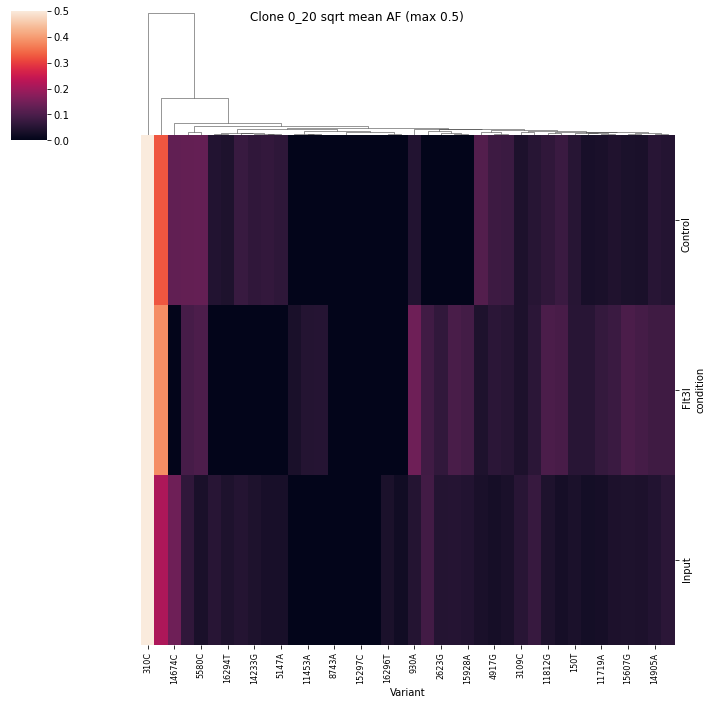

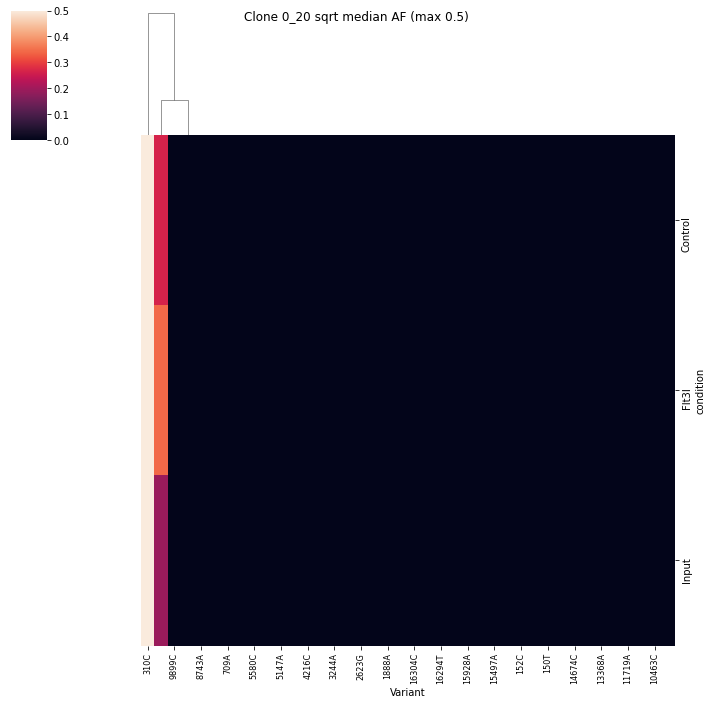

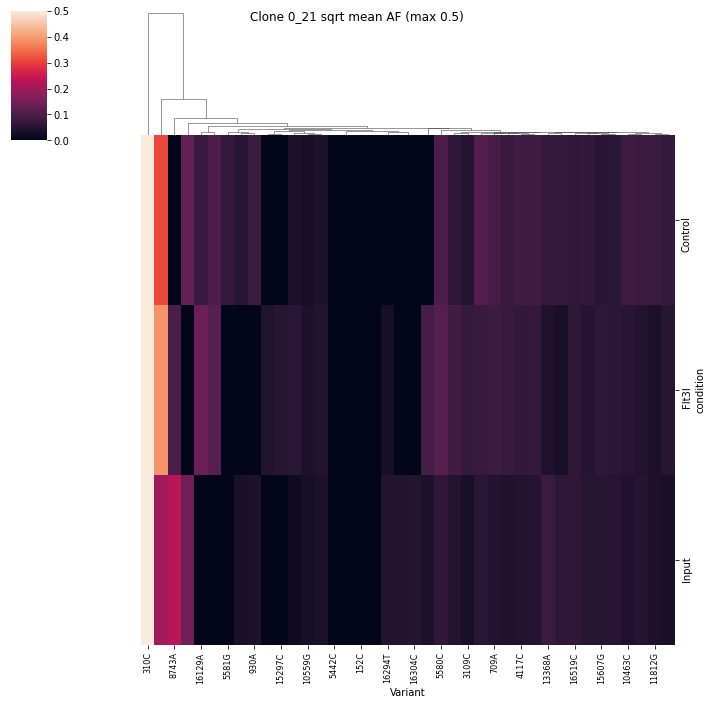

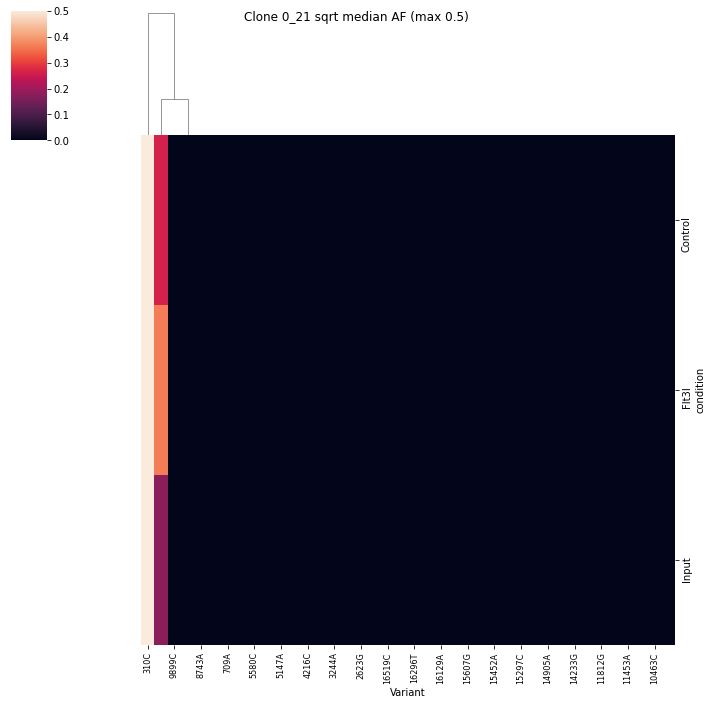

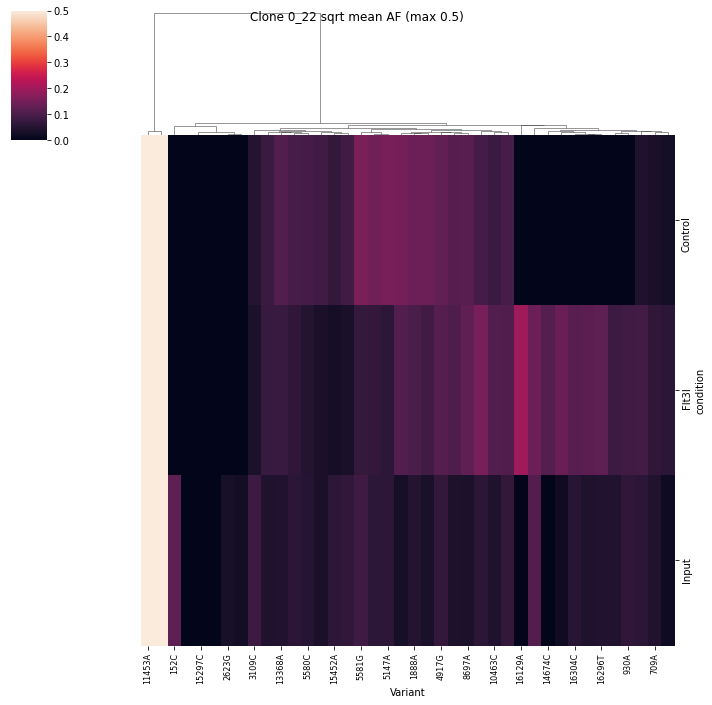

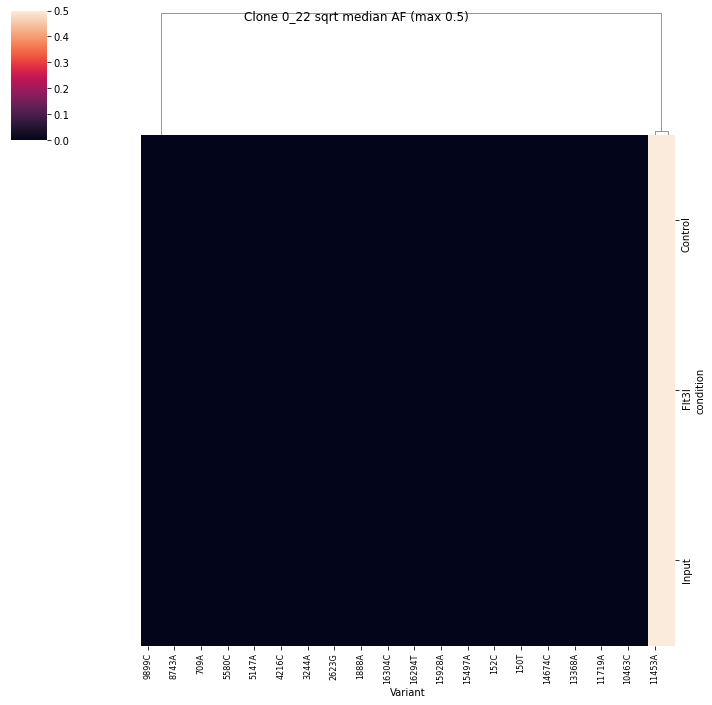

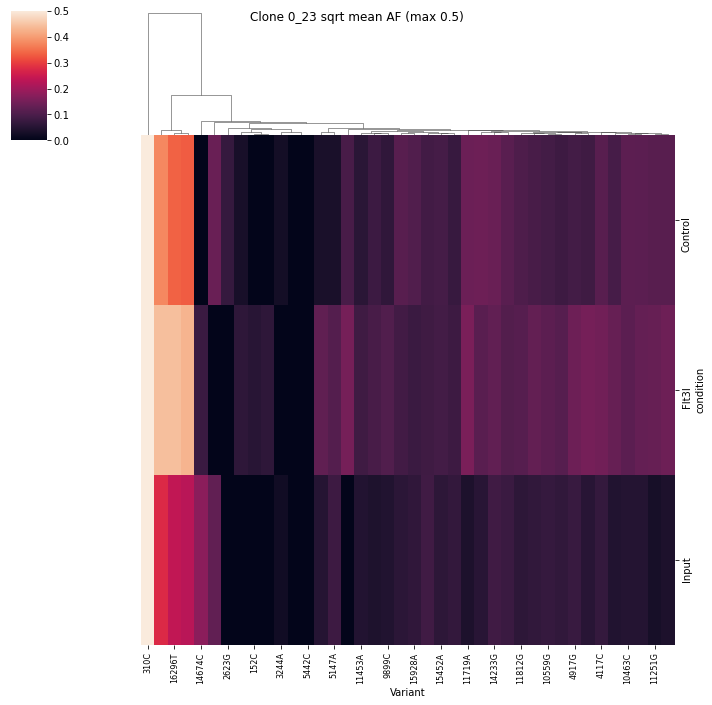

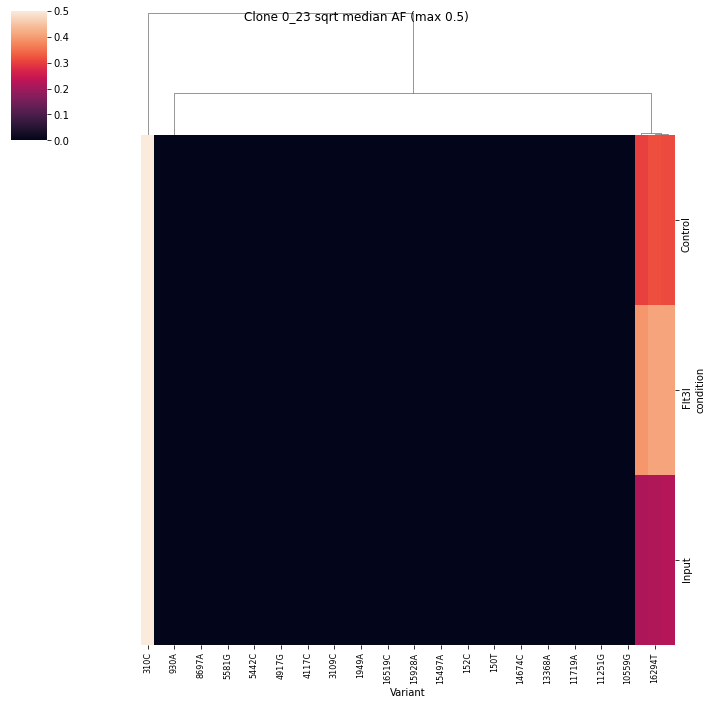

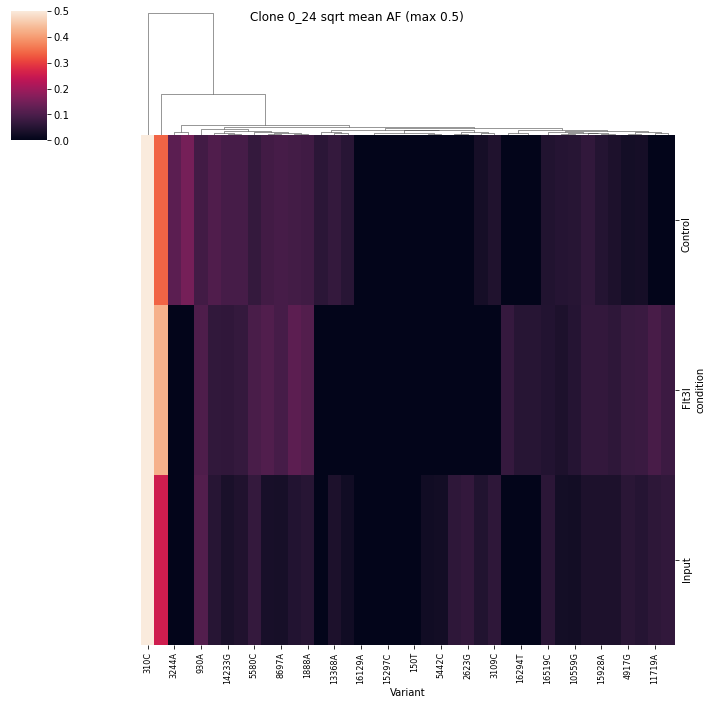

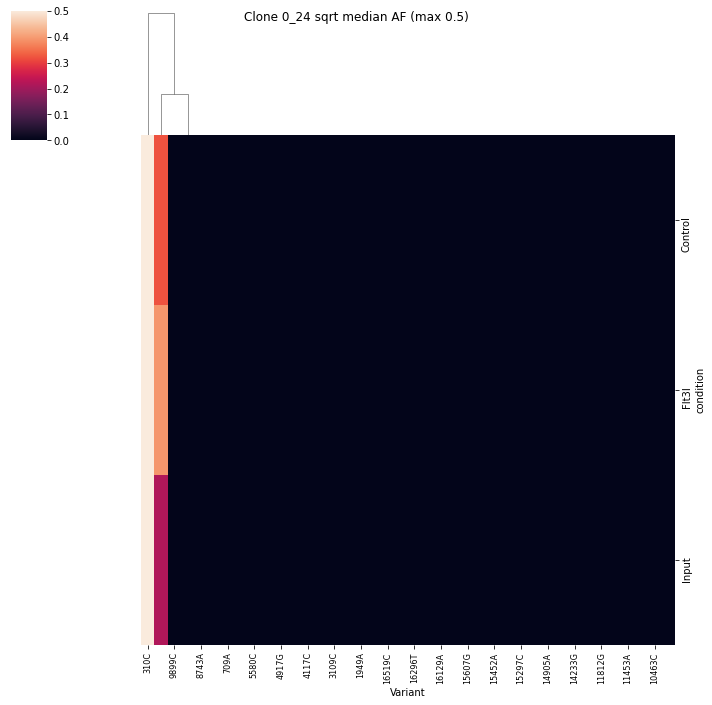

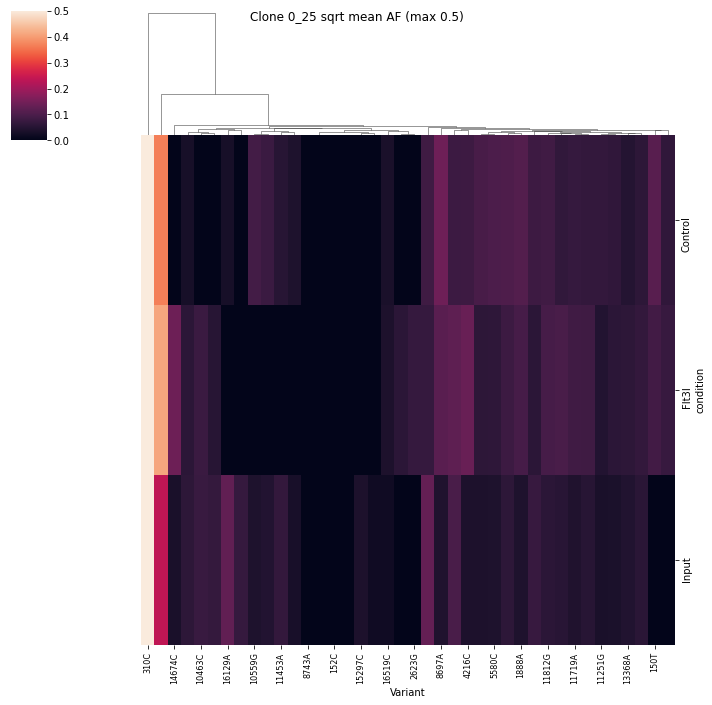

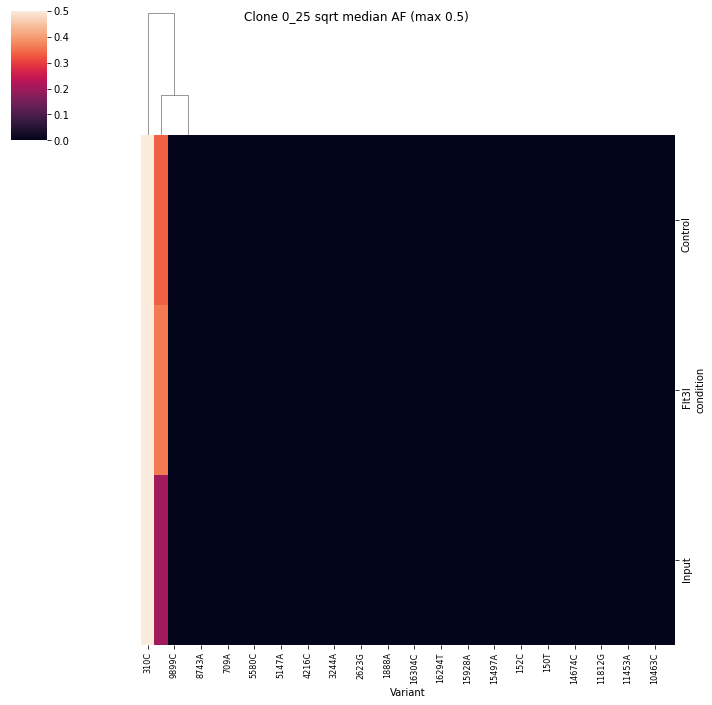

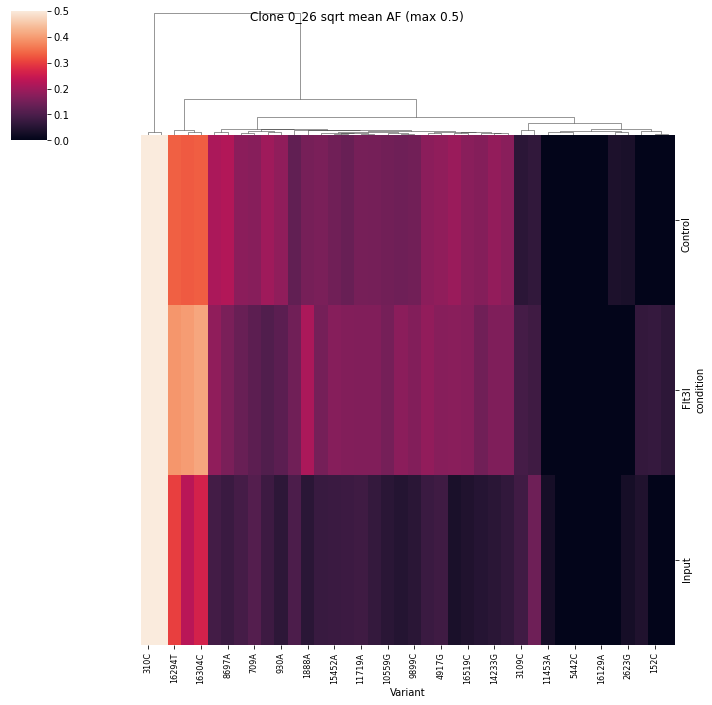

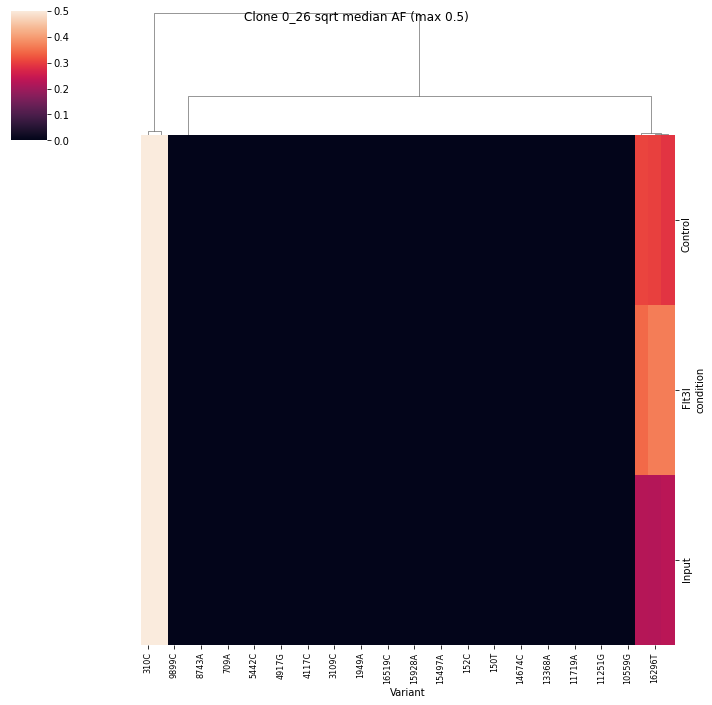

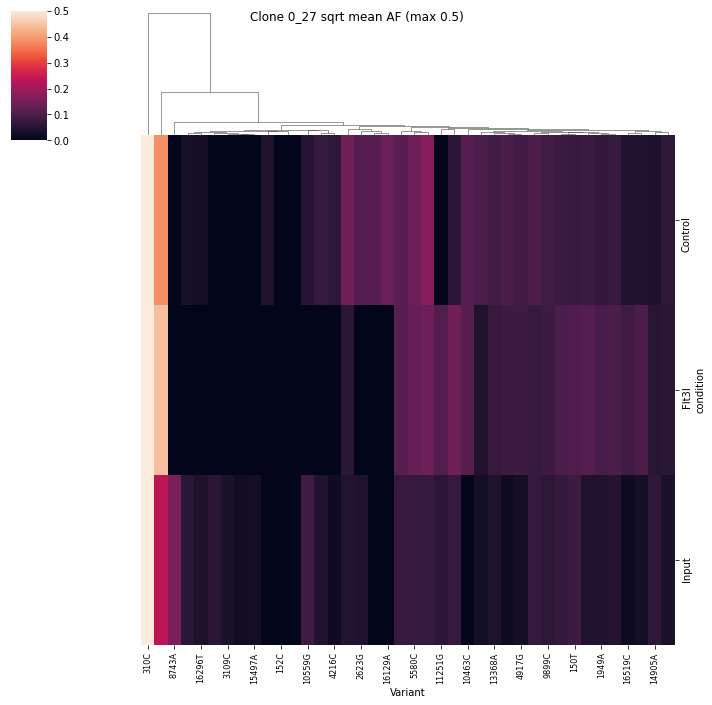

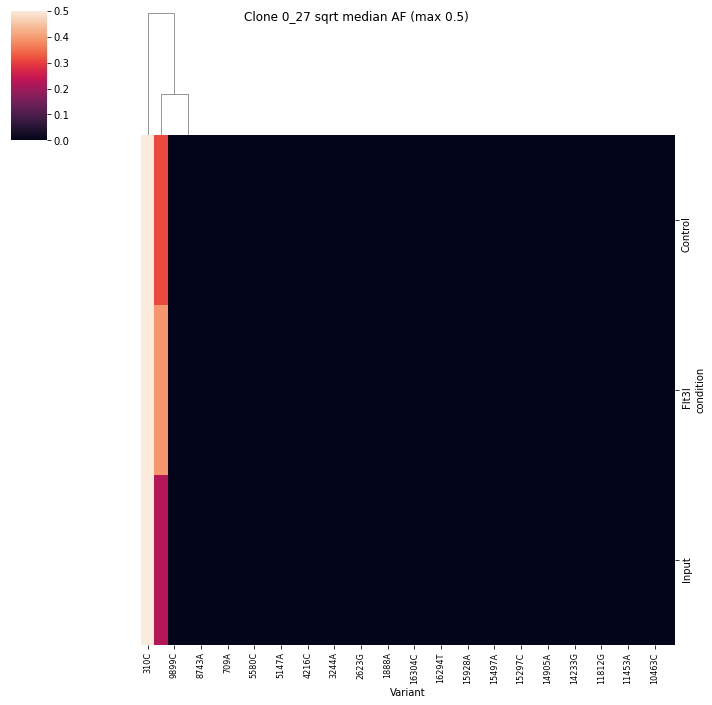

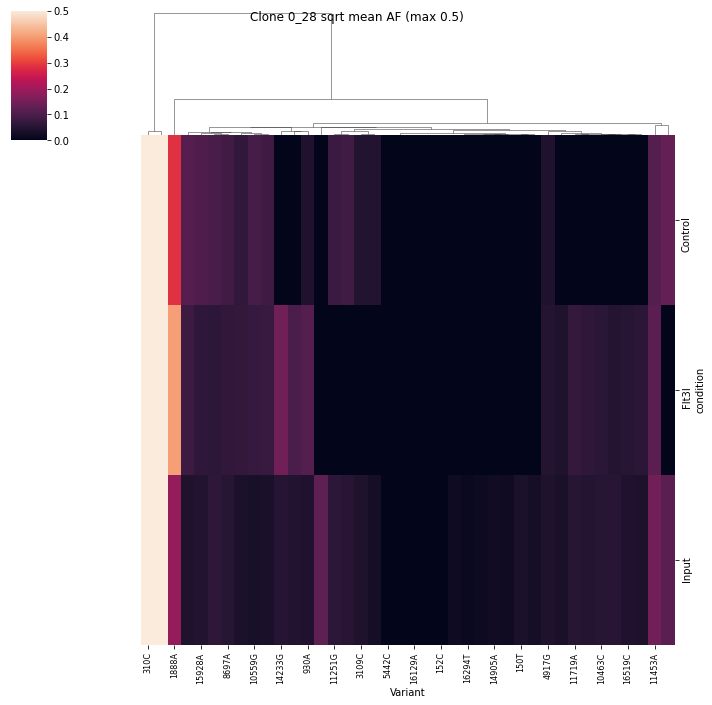

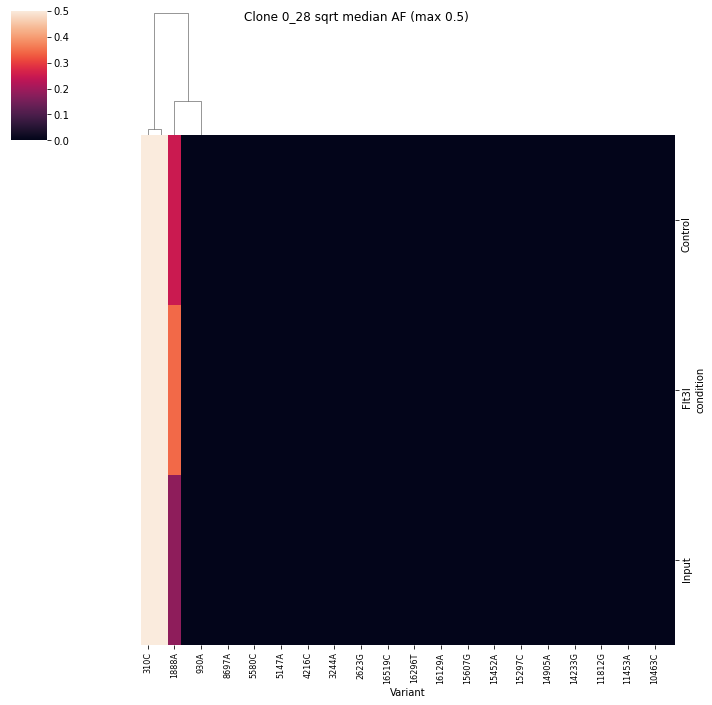

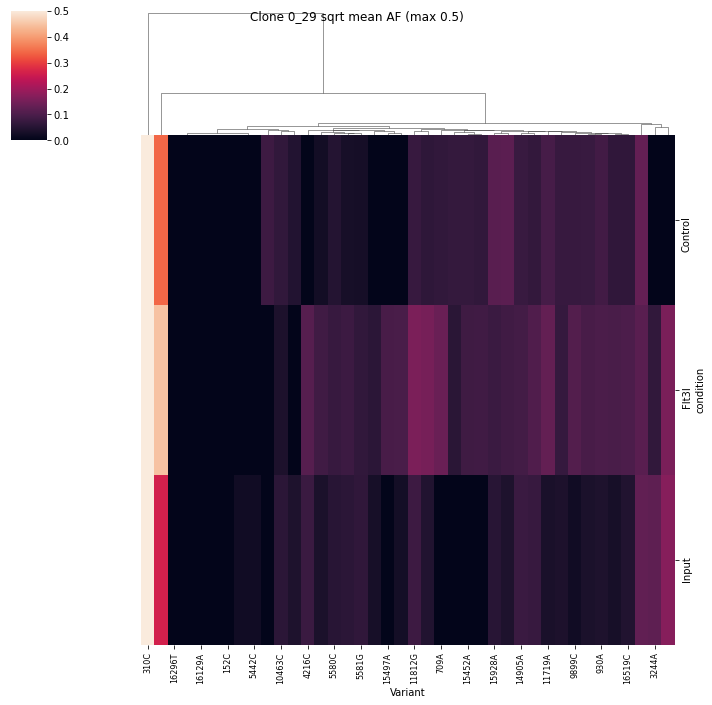

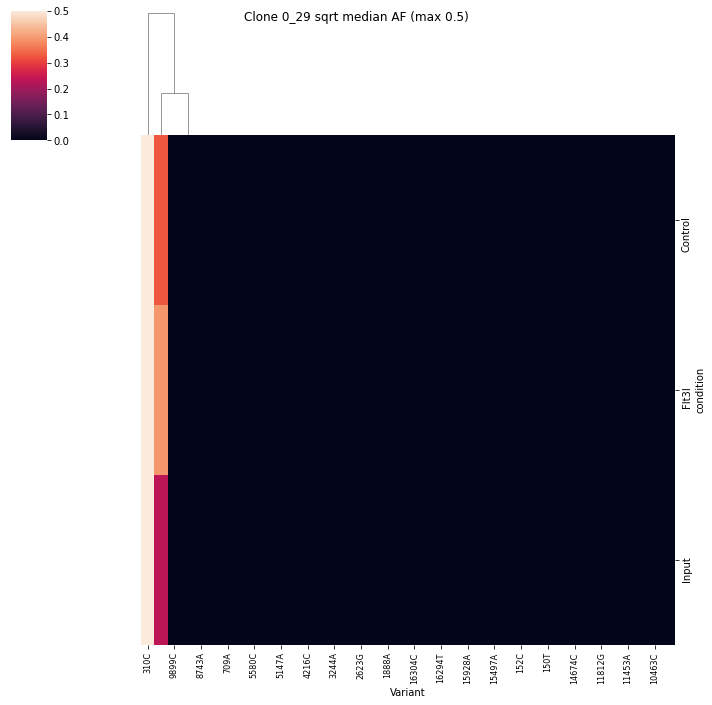

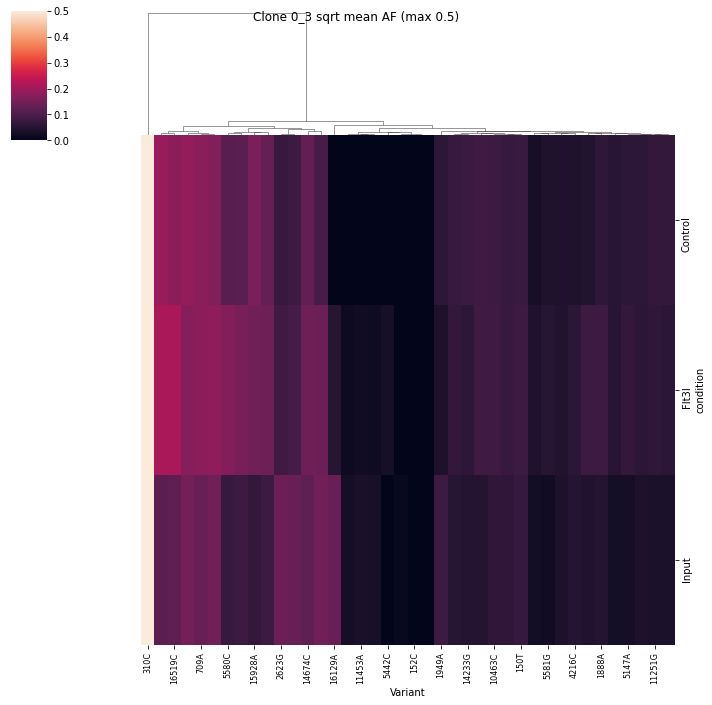

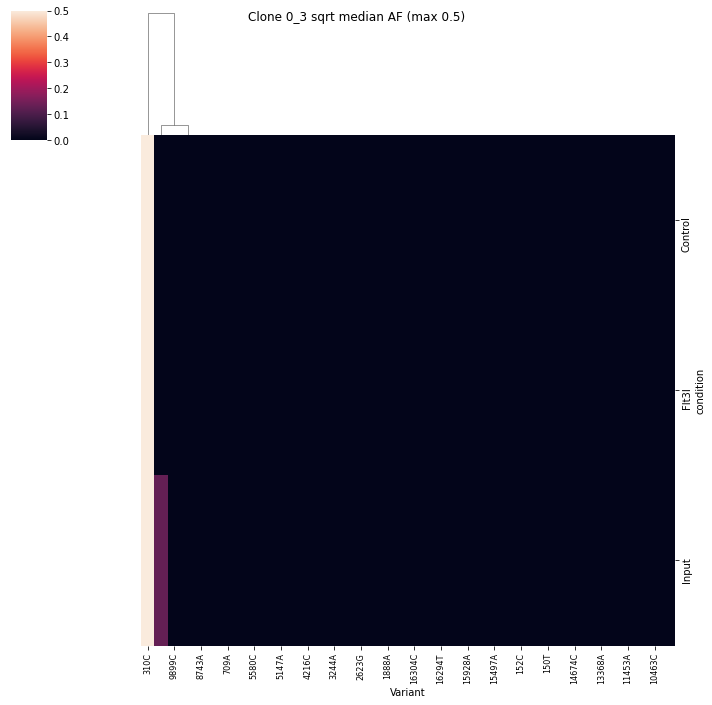

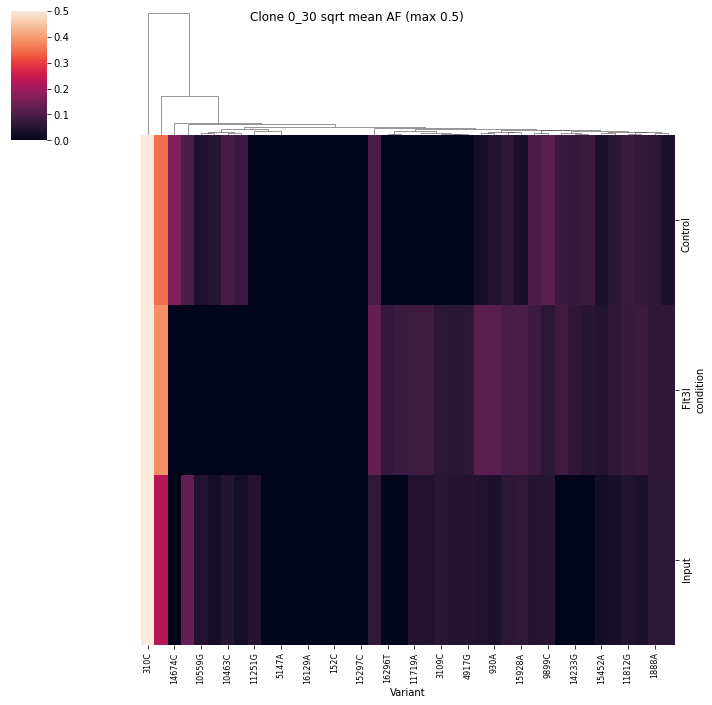

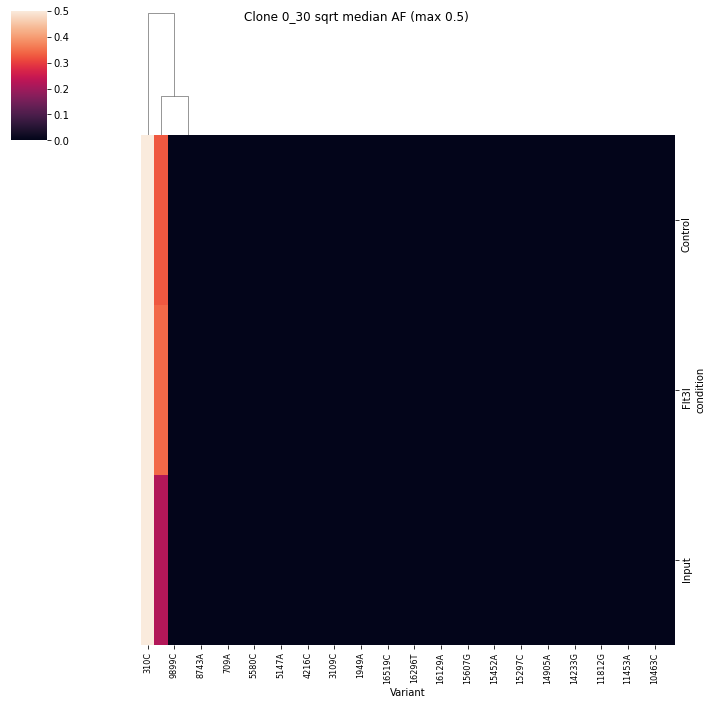

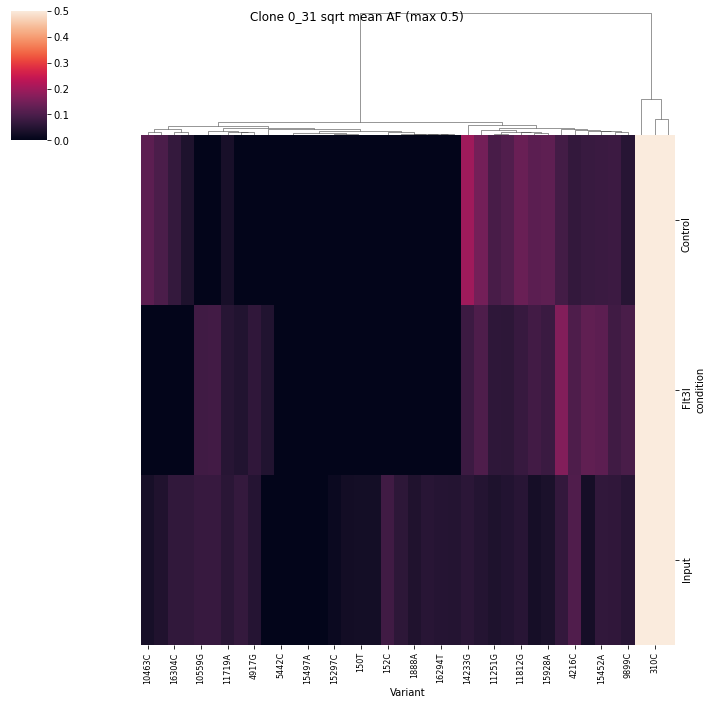

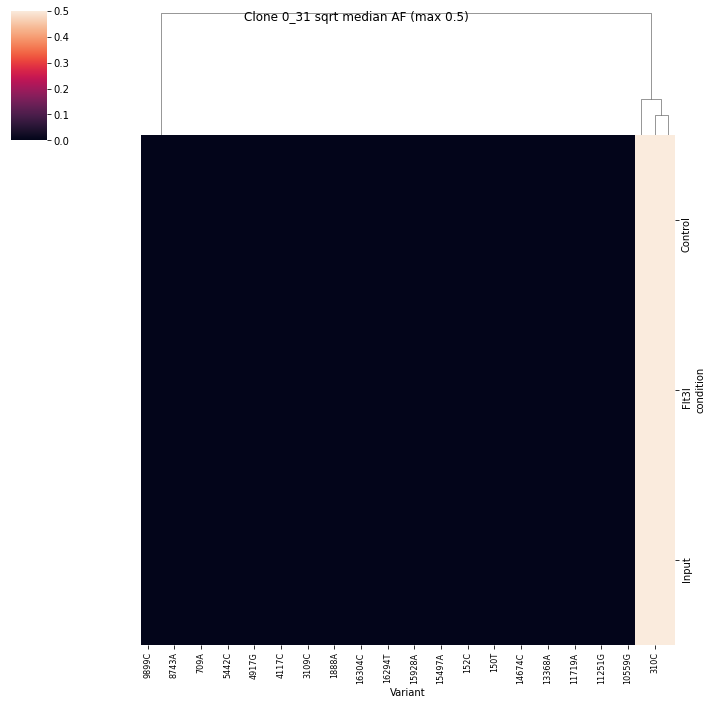

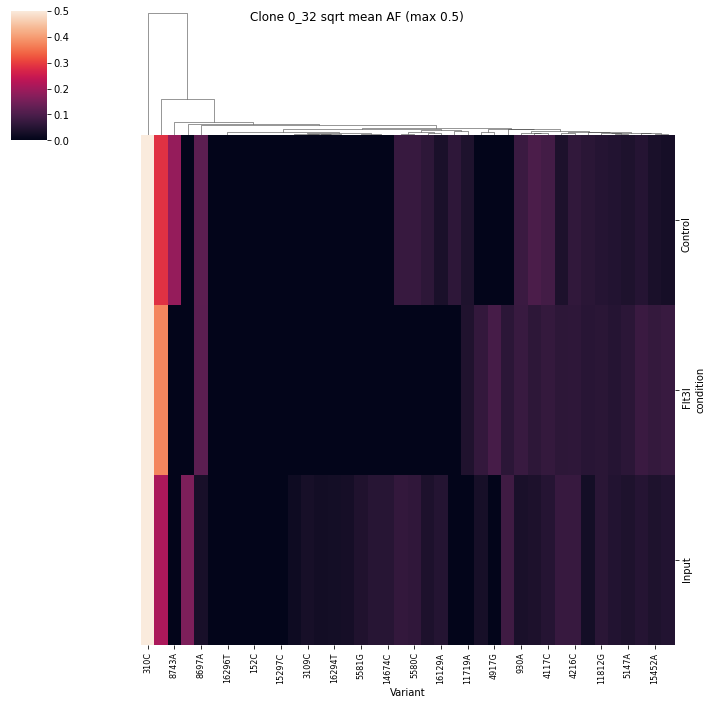

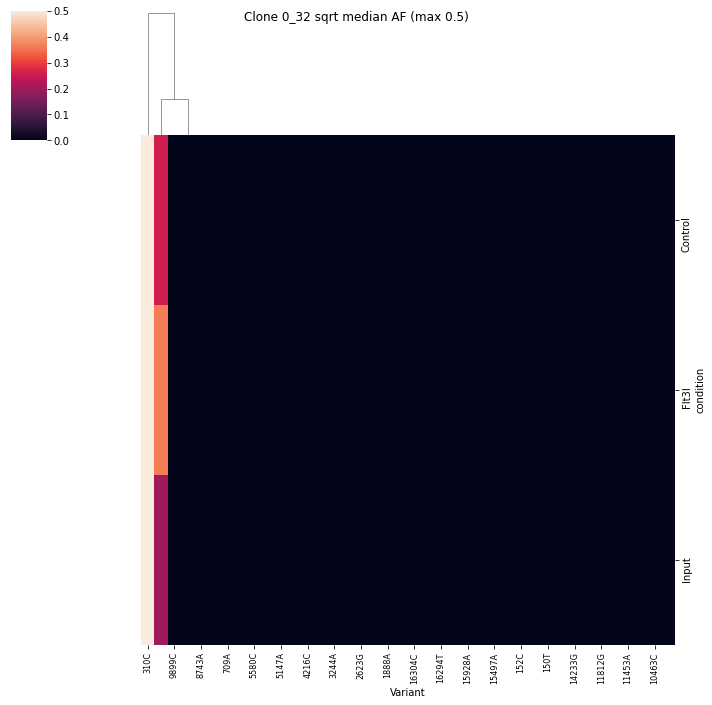

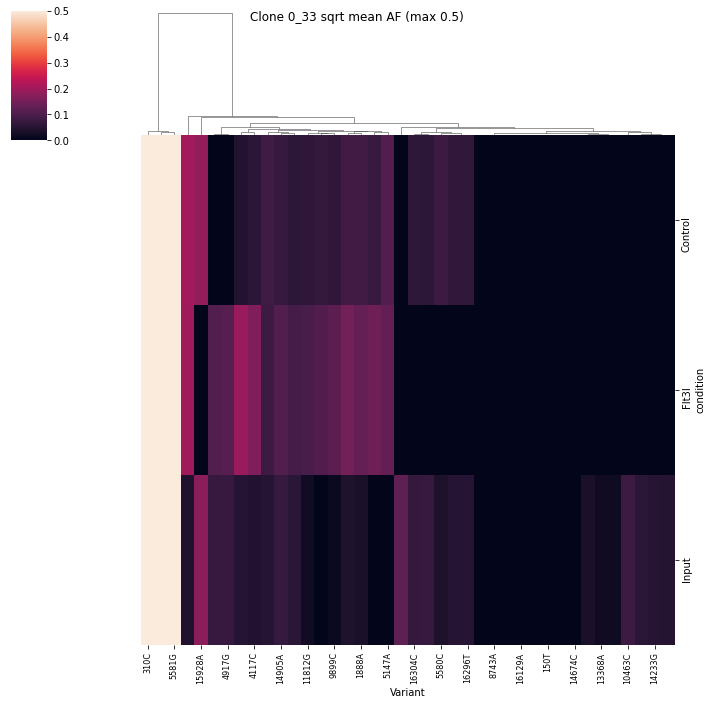

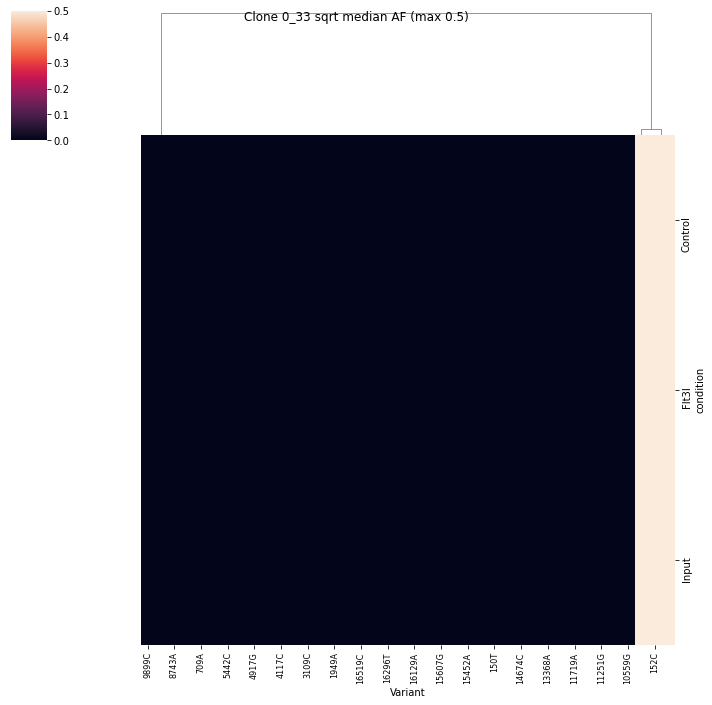

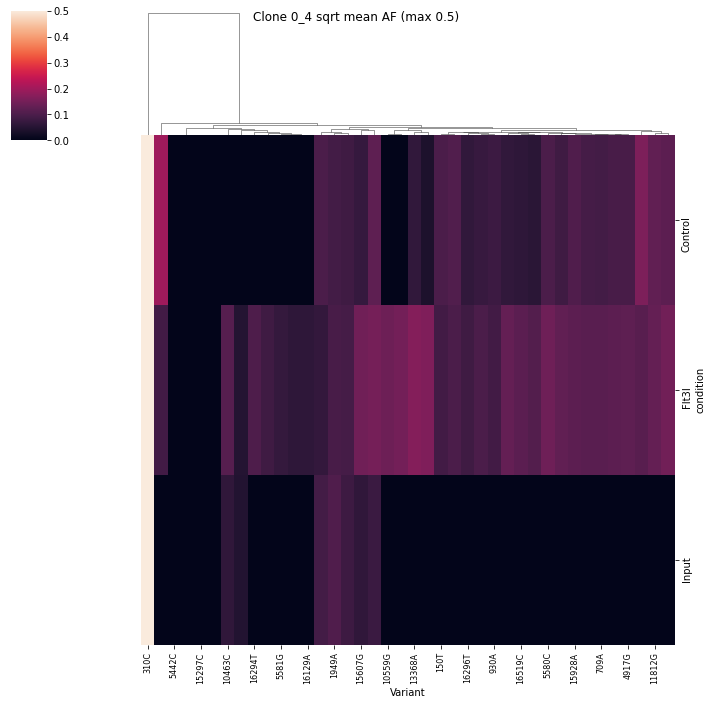

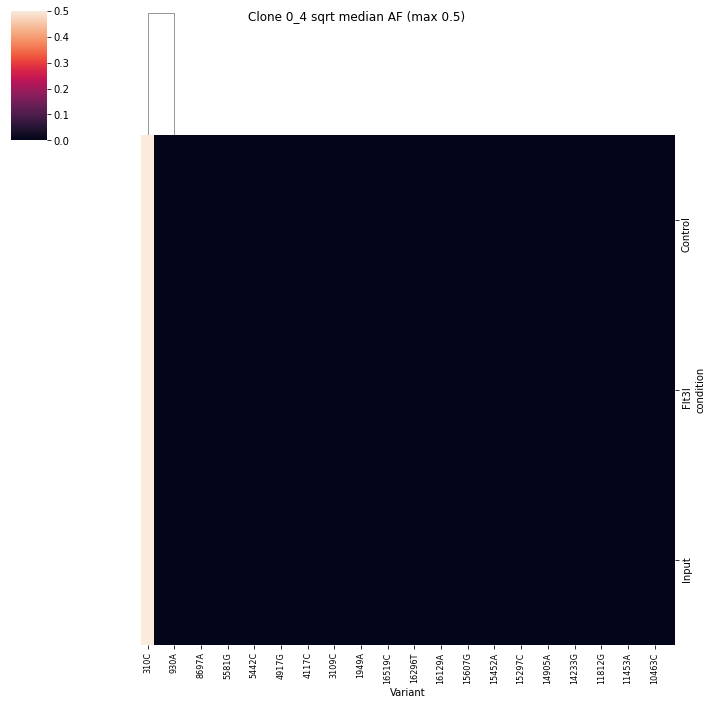

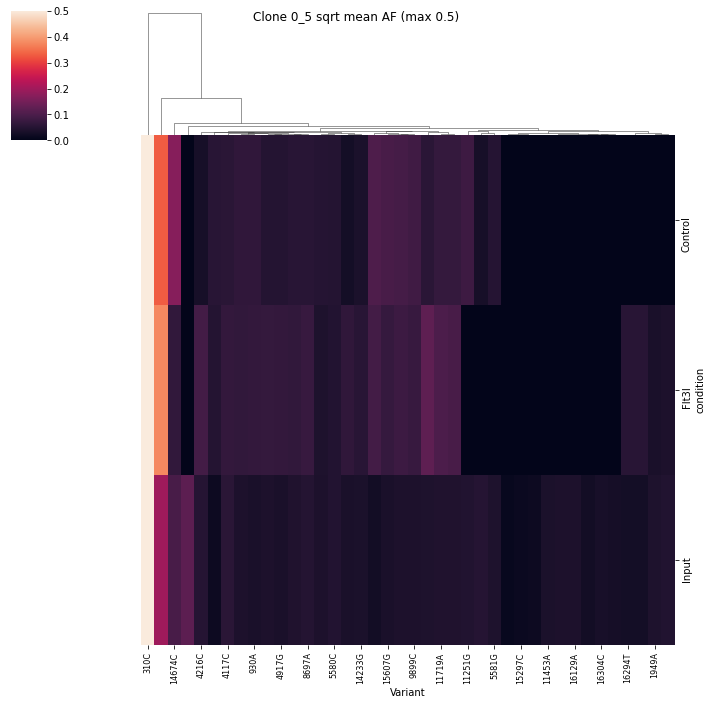

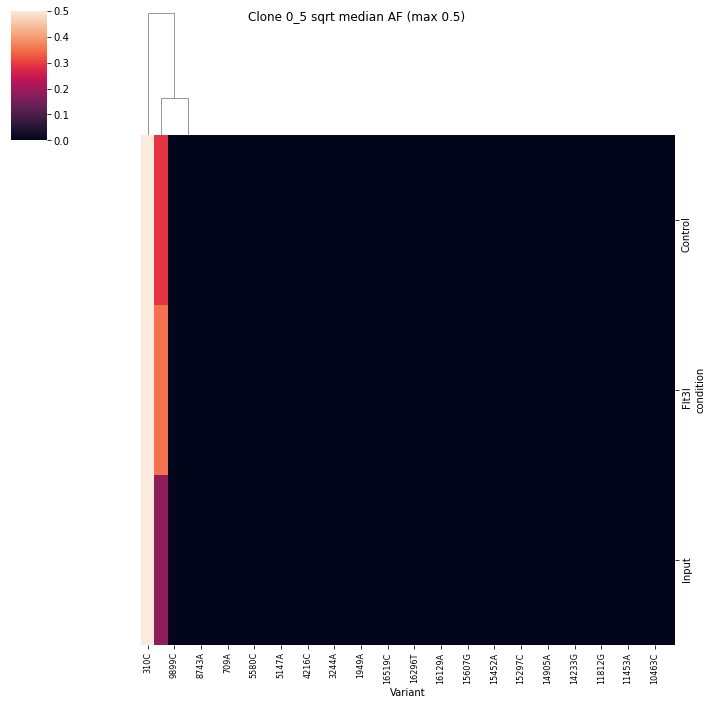

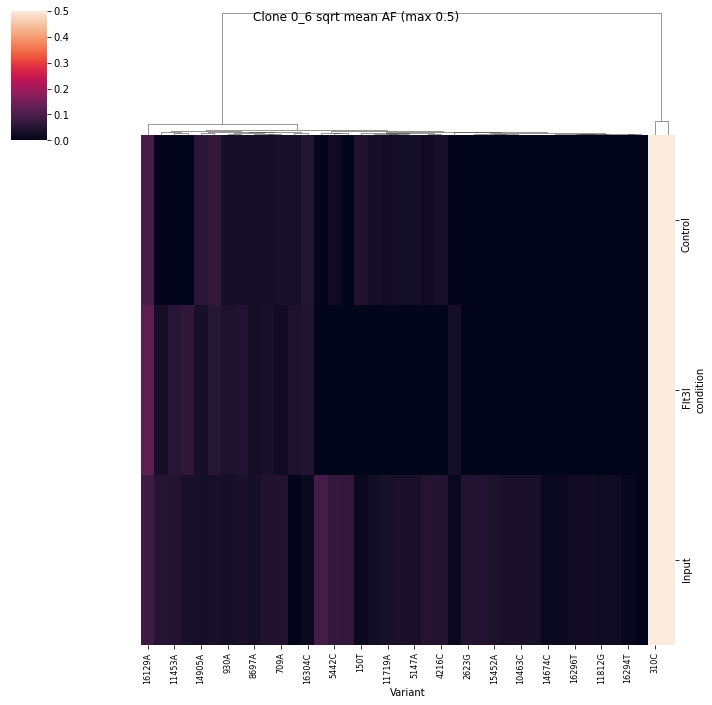

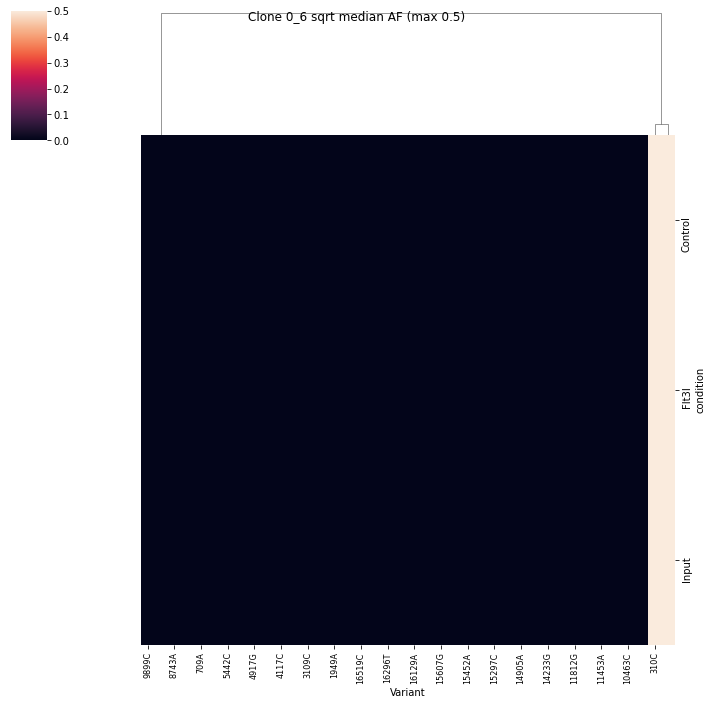

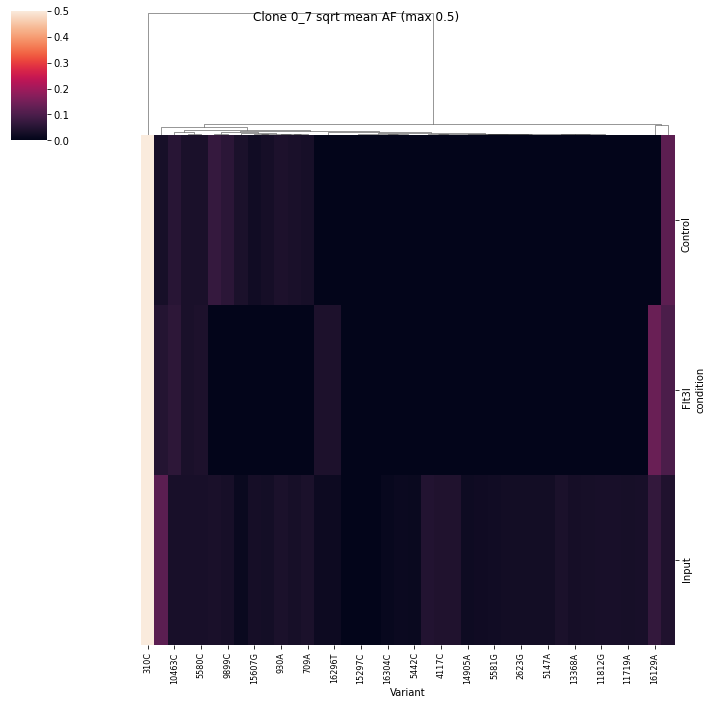

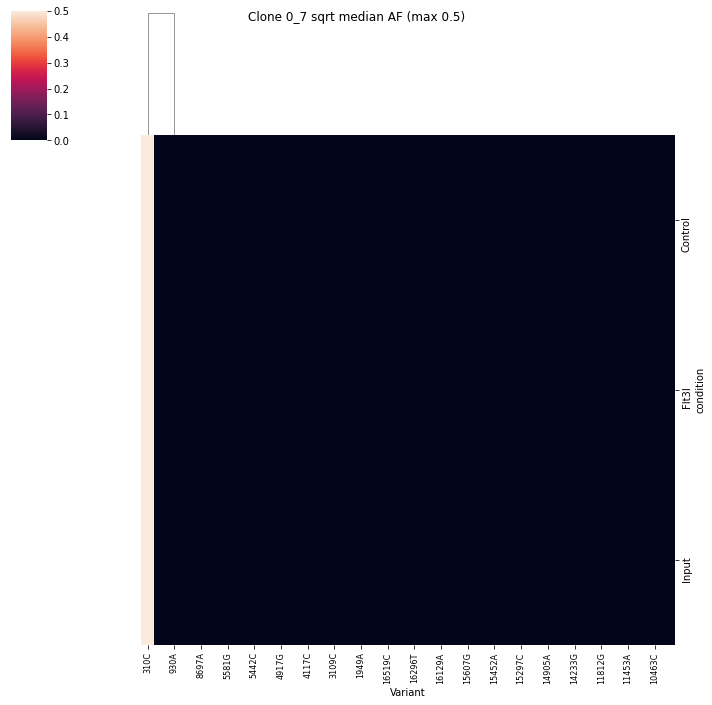

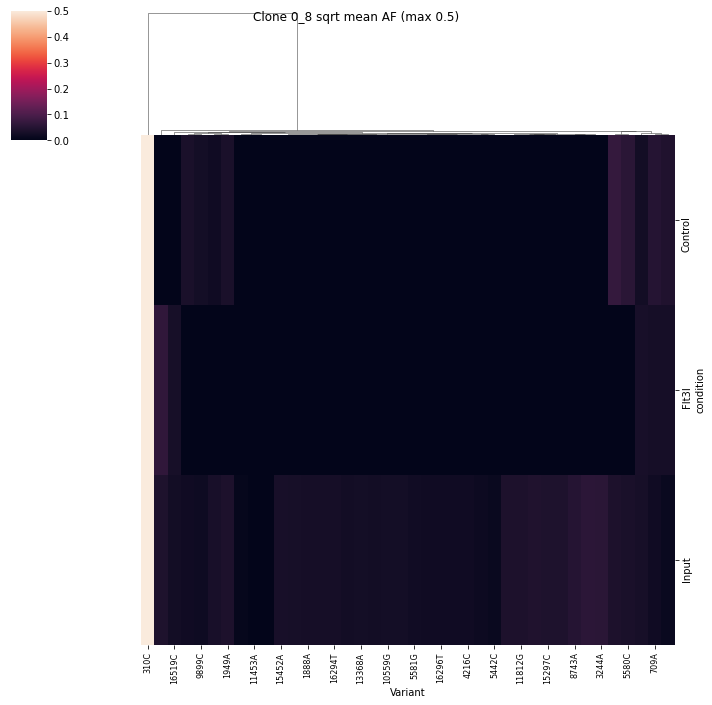

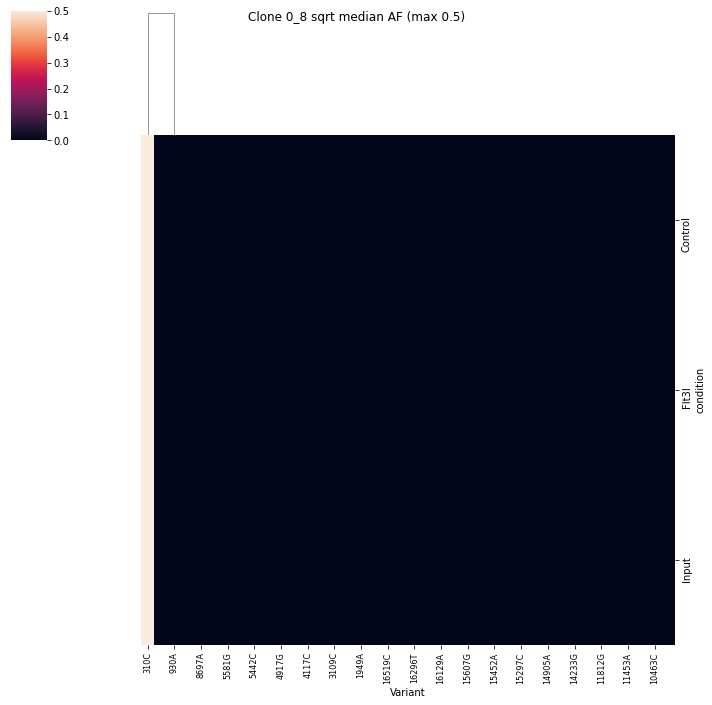

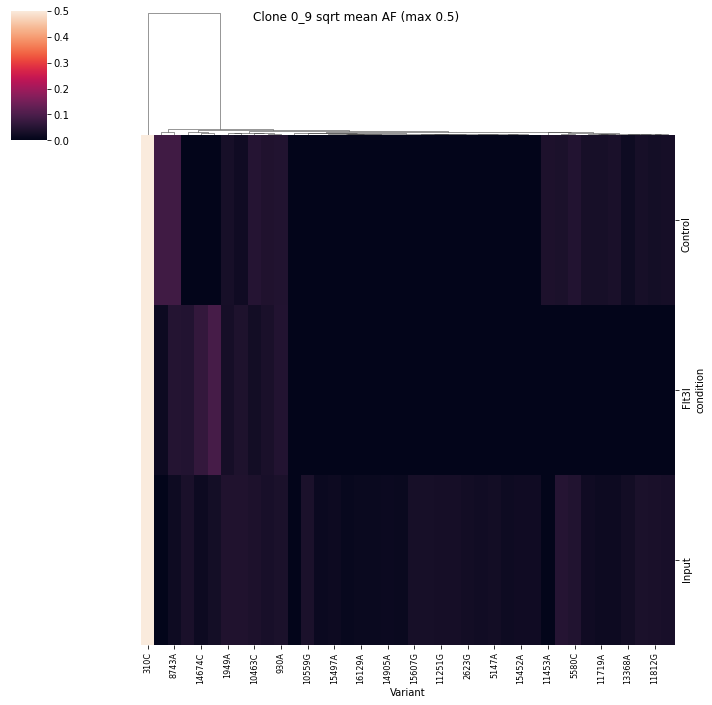

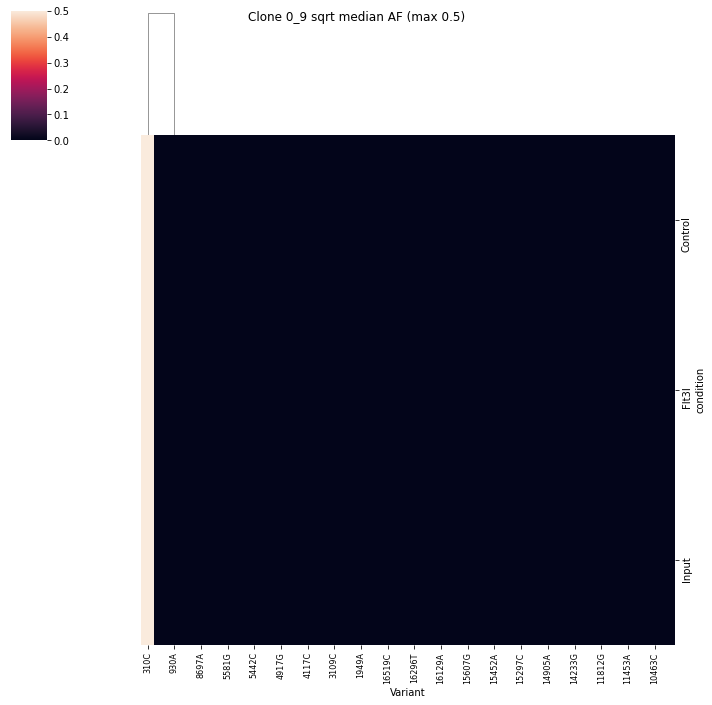

In [16]:
for cln, val in curr_labels.groupby("name"):
    print(cln)
    curr_af = AF_df.loc[:, val.index]
    curr_dp = DP_df.loc[:, val.index]
    curr_labs = curr_labels[curr_labels.index.isin(curr_af.columns)]
    print(curr_af.shape)
    
    curr_anno = pd.DataFrame(curr_af.apply(lambda x: x.name.split("_")[-1], axis=0)).rename({0:"condition"},axis=1)
    mean_af = curr_labs.groupby("condition").apply(calc_mean, af=curr_af.loc[~(curr_af.index.isin(donor_inds)),])
    mean_af = mean_af.loc[[x for x in conditions if x in mean_af.index]]    
    g2 = ch.plot_cluster(np.sqrt(mean_af), # row_meta=anno, #curr_labels[["condition", "lineage"]], 
                        to_row_clust=False, to_col_clust=True, vmax=0.5, vmin=0)
    plt.suptitle(f"Clone {cln} sqrt mean AF (max 0.5)")
    plt.savefig(join(OUTDIR, f"{cln}_mean_af.png"))
    
    curr_anno = pd.DataFrame(curr_af.apply(lambda x: x.name.split("_")[-1], axis=0)).rename({0:"condition"},axis=1)
    median_af = curr_labs.groupby("condition").apply(calc_median, af=curr_af.loc[~(curr_af.index.isin(donor_inds)),])
    median_af = median_af.loc[[x for x in conditions if x in median_af.index]]
    g2 = ch.plot_cluster((np.sqrt(median_af)), # row_meta=anno, #curr_labels[["condition", "lineage"]], 
                        to_row_clust=False, to_col_clust=True,vmax=0.5, vmin=0)
    plt.suptitle(f"Clone {cln} sqrt median AF (max 0.5)")
    plt.savefig(join(OUTDIR, f"{cln}_median_af.png"))
    
    #median_dp = curr_labs.groupby(["lineage", "condition"]).apply(calc_median, af=nlog2(curr_dp))
#     median_dp = curr_labs.groupby(["lineage", "condition"]).apply(calc_median, af=np.log2(curr_dp+1))
#     anno_dp = median_dp.reset_index()[["lineage", "condition"]]
#     median_dp = median_dp.reset_index(drop=True)
